## PINN for Emsley system of ODEs: Discovery of an unknown function and parameter
This work is based on the Medium article "Discovering Differential Equations with Physics-Informed Neural Networks and Symbolic Regression" by Shuai Guo and uses the GitHub code: https://github.com/ShuaiGuo16/PINN_symbolic_regression

### Import libraries and packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.integrate import solve_ivp
from collections import defaultdict
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

2025-08-28 11:04:45.015889: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-28 11:04:45.017432: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 11:04:45.044859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-28 11:04:45.045325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 11:04:45.537750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Generate data

In [3]:
def simulate_ODEs(u_init, t_span, obs_num):
    """Simulate the ODE system and obtain observational data. 
    
    Args:
    ----
    u_init: list of initial condition for u1, u2, and u3
    t_span: lower and upper time limit for simulation
    obs_num: number of observational data points
    
    Outputs:
    --------
    u_obs: observed data for u's
    """
    
    # Target ODEs
    def odes(t, u):
        du1dt = (-u[1] * u[0]**2)*350*1000*10**(-7)  #Emsley's system of ODEs
        du2dt = (-4.2*10**(-4) * u[1])*350
        return [du1dt, du2dt]
    
    # Solve ODEs
    t_eval = np.linspace(t_span[0], t_span[1], obs_num)
    sol = solve_ivp(odes, t_span, u_init, method='RK45', t_eval=t_eval)
    
    # Restrcture solution
    u_obs = np.column_stack((sol.t, sol.y[0], sol.y[1]))
    
    return u_obs

In [4]:
# Set up simulation
u_init = [1.19, 1.6]  #scaled DP and k1
t_span = [0, 10]  #scaled time
obs_num = 1000

# Solve ODEs
u_obs = simulate_ODEs(u_init, t_span, obs_num)

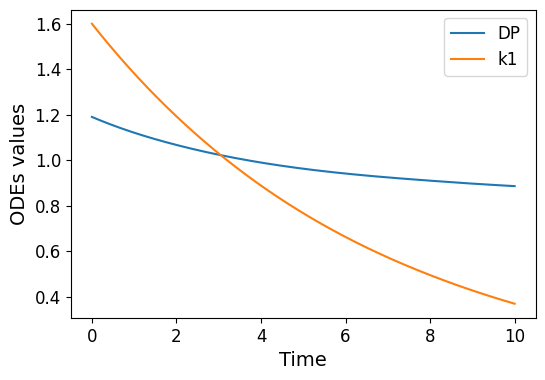

In [6]:
# Visualize the results
plt.figure(figsize=(6, 4))

plt.plot(u_obs[:, 0], u_obs[:, 1], label='DP')
plt.plot(u_obs[:, 0], u_obs[:, 2], label='k1')

plt.xlabel('Time', fontsize=14)
plt.ylabel('ODEs values', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, frameon=True)

### Generating data

In [5]:
# Set batch size
data_batch_size = 100
ODE_batch_size = 1000

# Samples for enforcing data loss
X_train_data = tf.convert_to_tensor(u_obs[:, :1], dtype=tf.float32)
y_train_data = tf.convert_to_tensor(u_obs[:, 1:], dtype=tf.float32)
train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
train_ds_data = train_ds_data.shuffle(1000).batch(data_batch_size)

# Samples for enforcing ODE residual loss
N_collocation = 10000
X_train_ODE = tf.convert_to_tensor(np.linspace(0, 10, N_collocation).reshape(-1, 1), dtype=tf.float32)
train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

# Generate testing data
u_obs_test = simulate_ODEs(u_init, t_span, 5000)
X_test, y_test = u_obs_test[:, :1], u_obs_test[:, 1:]

### Class for the parameter to estimate
In this case what it is defined as parameter a it corresponds to k2 in the Emsley's system of ODEs.

In [6]:
class ParameterLayer(tf.keras.layers.Layer):

    def __init__(self, a, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self.trainable = trainable
      
  
    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        
    def get_config(self):
        return super().get_config()
    

    @classmethod
    def from_config(cls, config):
        return cls(**config)

### PINN model

In [7]:
def u_net(input_layer):
    """Definition of the network for u prediction."""
    
    hidden = input_layer
    for _ in range(13):  #13
        hidden = tf.keras.layers.Dense(35, activation="tanh")(hidden)  #35
    output = tf.keras.layers.Dense(2)(hidden)
    return output


def f_net(input_layers, a_init=None):
    """Definition of the network for f prediction."""
    
    hidden = tf.keras.layers.Concatenate()(input_layers)
    for _ in range(12):  #12
        hidden = tf.keras.layers.Dense(53, activation="tanh")(hidden)  #53
    output = tf.keras.layers.Dense(1)(hidden)
    output = ParameterLayer(a_init)(output)
    return output


def create_PINN(a_init=None, verbose=False):
    """Definition of a physics-informed neural network.
    
    Args:
    ----
    a_init: initial value for parameter a
    b_init: initial value for parameter b
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the PINN model
    """
    # Input
    t_input = tf.keras.Input(shape=(1,), name="time")
    
    # u-NN
    u = u_net(t_input)
    
    # f-NN
    f = f_net([t_input, u], a_init)

    # PINN model
    model = tf.keras.models.Model(inputs=t_input, outputs=[u, f])
    
    if verbose:
        model.summary()
        
    return model

In [8]:
@tf.function
def ODE_residual_calculator(t, model):
    """ODE residual calculation.
    
    Args:
    ----
    t: temporal coordinate
    model: PINN model
    
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    
    # Retrieve parameters
    a = model.layers[-1].a
    
    with tf.GradientTape() as tape:
        tape.watch(t)
        u, f = model(t)
    
    # Calculate gradients
    dudt = tape.batch_jacobian(u, t)[:, :, 0]
    du1_dt, du2_dt = dudt[:, :1], dudt[:, 1:2]
    
    # Compute residuals
    res1 = du1_dt - f[:, :1]
    res2 = du2_dt - (-a*u[:, 1:2])
    ODE_residual = tf.concat([res1, res2], axis=1)
    
    return ODE_residual

### Training

In [9]:
@tf.function
def train_step(X_ODE, X, y, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X_ODE: Collocation points for evaluating ODE residuals
    X: observed samples
    y: target values of the observed samples
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: PINN model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC, _ = model(tf.zeros((1, 1)))

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X_ODE, model=model)
        
        # Data loss
        y_pred_data, _ = model(X)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(tf.constant([[1.19, 1.6]]), y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))
        
        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

### Losses and parameter

In [10]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

In [11]:
class PrintParameters(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}")

### Training configuration

In [12]:
# Set up training configurations

n_epochs = 2000

#weights for losses
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list = []

# Initial value for unknown parameters
a_init = 1

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3) #1e-2

with tf.device("CPU:0"):
    
    # Instantiate the PINN model
    PINN = create_PINN(a_init=a_init)
    PINN.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=100),
                 tf.keras.callbacks.ModelCheckpoint('PINN_model.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PINN)
    
    # Start training process
    for epoch in range(1, n_epochs + 1):  
        print(f"Epoch {epoch}:")

        for (X_ODE), (X, y) in zip(train_ds_ODE, train_ds_data):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X_ODE, X, y, IC_weight, 
                                                                             ODE_weight, data_weight, PINN)
            # Gradient descent
            PINN.optimizer.apply_gradients(zip(gradients, PINN.trainable_variables))

            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()
        
        # Parameter recording
        a_list.append(PINN.layers[-1].a.numpy())

        ####### Validation
        val_res = ODE_residual_calculator(tf.reshape(tf.linspace(0.0, 10.0, 1000), [-1, 1]), PINN)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        u_init=tf.constant([[1.19, 1.6]])
        val_pred_init, _ = PINN.predict(tf.zeros((1, 1)))
        val_IC = tf.reduce_mean(tf.square(val_pred_init - u_init))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PINN.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test, _ = PINN.predict(X_test, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")
        
        
        # Re-shuffle dataset
        train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
        train_ds_data = train_ds_data.shuffle(10000).batch(data_batch_size) 
        
        train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
        train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size) 

Epoch 1:
IC=1.0478e+00,               ODE=1.7345e-01,               data=2.3990e-01,               total_loss=1.4611e+00
1/1 [==============================] - 0s 120ms/step
val_IC: 1.0451e-01, val_ODE: 1.1588e-01, lr: 1.00e-03

a: [0.9906671]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.2635024160457552
Epoch 2:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.7065e-02,               ODE=6.6415e-02,               data=8.9536e-02,               total_loss=2.2302e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.3664e-02, val_ODE: 5.1194e-02, lr: 1.00e-03

a: [0.981323]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.29750721050326395
Epoch 3:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1712e-02,               ODE=7.4613e-02,               data=7.9648e-02,               total_loss=1.6597e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.3122e-04, val_ODE: 3.9670e-02, lr: 1.00e-03

a: [0.9726557]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.32362696329630936
Epoch 4:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9801e-03,               ODE=5.2948e-02,               data=8.0007e-02,               total_loss=1.4293e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8876e-04, val_ODE: 7.2749e-02, lr: 1.00e-03

a: [0.96395934]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.24415383416592454
Epoch 5:
IC=1.2264e-03,               ODE=6.6111e-02,               data=6.6488e-02,               total_loss=1.3383e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 2.5111e-03, val_ODE: 6.0782e-02, lr: 1.00e-03

a: [0.9547045]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.2575097395536524
Epoch 6:
IC=1.7323e-03,               ODE=6.1780e-02,               data=6.4555e-02,               total_loss=1.2807e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 3.5459e-05, val_ODE: 5.8321e-02, lr: 1.00e-03

a: [0.9451183]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.26151927446155376
Epoch 7:
IC=8.4996e-04,               ODE=5.88

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3051e-04,               ODE=4.2133e-02,               data=2.3729e-02,               total_loss=6.6292e-02
1/1 [==============================] - 0s 12ms/step
val_IC: 8.3625e-04, val_ODE: 4.6684e-02, lr: 1.00e-03

a: [0.64555043]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.13334481346241742
Epoch 37:
IC=5.2947e-04,               ODE=4.1318e-02,               data=2.2450e-02,               total_loss=6.4297e-02
1/1 [==============================] - 0s 12ms/step
val_IC: 4.7337e-04, val_ODE: 3.5878e-02, lr: 1.00e-03

a: [0.6355275]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.16366791844642087
Epoch 38:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6631e-04,               ODE=4.0383e-02,               data=2.1233e-02,               total_loss=6.2082e-02
1/1 [==============================] - 0s 16ms/step
val_IC: 7.9283e-04, val_ODE: 4.3338e-02, lr: 1.00e-03

a: [0.6255793]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.12980390066887884
Epoch 39:
IC=5.4620e-04,               ODE=3.9633e-02,               data=1.9870e-02,               total_loss=6.0049e-02
1/1 [==============================] - 0s 17ms/step
val_IC: 1.8517e-04, val_ODE: 3.3928e-02, lr: 1.00e-03

a: [0.6156286]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.1587901886977435
Epoch 40:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.0500e-04,               ODE=3.8088e-02,               data=1.9697e-02,               total_loss=5.8390e-02
1/1 [==============================] - 0s 17ms/step
val_IC: 3.3577e-04, val_ODE: 3.7784e-02, lr: 1.00e-03

a: [0.6057971]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.1365267778167386
Epoch 41:
IC=4.2504e-04,               ODE=3.7127e-02,               data=1.8544e-02,               total_loss=5.6096e-02
1/1 [==============================] - 0s 16ms/step
val_IC: 4.8764e-04, val_ODE: 3.7526e-02, lr: 1.00e-03

a: [0.5959898]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.12968083242298245
Epoch 42:
IC=4.4210e-04,               ODE=3.6580e-02,               data=1.6976e-02,               total_loss=5.3999e-02
1/1 [==============================] - 0s 21ms/step
val_IC: 3.1830e-04, val_ODE: 3.5843e-02, lr: 1.00e-03

a: [0.5862046]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.1294472484283198
Epoch 43:
IC=4.3233e-04,               ODE=3.5

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5263e-04,               ODE=3.1790e-02,               data=1.4562e-02,               total_loss=4.6805e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 4.4910e-04, val_ODE: 3.4132e-02, lr: 1.00e-03

a: [0.5477224]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.10569512400987494
Epoch 47:
IC=4.1242e-04,               ODE=3.1716e-02,               data=1.2821e-02,               total_loss=4.4949e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 4.3190e-04, val_ODE: 3.1524e-02, lr: 1.00e-03

a: [0.5382458]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.10875494472594953
Epoch 48:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8313e-04,               ODE=3.0615e-02,               data=1.2188e-02,               total_loss=4.3186e-02
1/1 [==============================] - 0s 24ms/step
val_IC: 2.8717e-04, val_ODE: 2.7588e-02, lr: 1.00e-03

a: [0.5288367]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.11981003972874348
Epoch 49:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6640e-04,               ODE=2.9332e-02,               data=1.1642e-02,               total_loss=4.1441e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 4.4126e-04, val_ODE: 2.8553e-02, lr: 1.00e-03

a: [0.5195045]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.10638401018241321
Epoch 50:
IC=4.1370e-04,               ODE=2.8352e-02,               data=1.0959e-02,               total_loss=3.9725e-02
1/1 [==============================] - 0s 22ms/step
val_IC: 2.8685e-04, val_ODE: 2.6109e-02, lr: 1.00e-03

a: [0.51029277]
1/1 [==============================] - 0s 47ms/step
RMSE: 0.11148431709975376
Epoch 51:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7999e-04,               ODE=2.7712e-02,               data=1.0001e-02,               total_loss=3.8093e-02
1/1 [==============================] - 0s 16ms/step
val_IC: 6.2805e-04, val_ODE: 2.5634e-02, lr: 1.00e-03

a: [0.5011152]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.10409019442357512
Epoch 52:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2890e-04,               ODE=2.6219e-02,               data=9.7243e-03,               total_loss=3.6373e-02
1/1 [==============================] - 0s 16ms/step
val_IC: 4.5588e-04, val_ODE: 2.6737e-02, lr: 1.00e-03

a: [0.49206504]
1/1 [==============================] - 0s 44ms/step
RMSE: 0.09082077159664065
Epoch 53:
IC=3.3846e-04,               ODE=2.5602e-02,               data=8.7961e-03,               total_loss=3.4737e-02
1/1 [==============================] - 0s 41ms/step
val_IC: 6.0217e-04, val_ODE: 2.4146e-02, lr: 1.00e-03

a: [0.48307356]
1/1 [==============================] - 0s 40ms/step
RMSE: 0.09556077902757999
Epoch 54:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9054e-04,               ODE=2.4281e-02,               data=8.5996e-03,               total_loss=3.3271e-02
1/1 [==============================] - 0s 24ms/step
val_IC: 5.0478e-04, val_ODE: 2.4632e-02, lr: 1.00e-03

a: [0.47419405]
1/1 [==============================] - 0s 48ms/step
RMSE: 0.08482499635289781
Epoch 55:
IC=2.9762e-04,               ODE=2.3773e-02,               data=7.5846e-03,               total_loss=3.1655e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7519e-04, val_ODE: 2.2842e-02, lr: 1.00e-03

a: [0.4653944]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.08757668564300086
Epoch 56:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8946e-04,               ODE=2.2474e-02,               data=7.4290e-03,               total_loss=3.0192e-02
1/1 [==============================] - 0s 16ms/step
val_IC: 4.7661e-04, val_ODE: 2.3208e-02, lr: 1.00e-03

a: [0.45670524]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.07581337836731036
Epoch 57:
IC=2.8159e-04,               ODE=2.1892e-02,               data=6.6058e-03,               total_loss=2.8780e-02
1/1 [==============================] - 0s 19ms/step
val_IC: 4.2064e-04, val_ODE: 2.0158e-02, lr: 1.00e-03

a: [0.4481136]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0861012109751357
Epoch 58:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3898e-04,               ODE=2.0682e-02,               data=6.3292e-03,               total_loss=2.7350e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 2.0230e-04, val_ODE: 2.0795e-02, lr: 1.00e-03

a: [0.4396443]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.07457019655301111
Epoch 59:
IC=2.8119e-04,               ODE=1.9853e-02,               data=5.8337e-03,               total_loss=2.5968e-02
1/1 [==============================] - 0s 16ms/step
val_IC: 2.2682e-04, val_ODE: 1.8679e-02, lr: 1.00e-03

a: [0.43125927]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.07953587691869698
Epoch 60:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9655e-04,               ODE=1.8948e-02,               data=5.4274e-03,               total_loss=2.4672e-02
1/1 [==============================] - 0s 17ms/step
val_IC: 2.4087e-04, val_ODE: 1.8456e-02, lr: 1.00e-03

a: [0.42301962]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.07223750904675943
Epoch 61:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4185e-04,               ODE=1.7967e-02,               data=5.1928e-03,               total_loss=2.3402e-02
1/1 [==============================] - 0s 18ms/step
val_IC: 5.4213e-04, val_ODE: 1.7933e-02, lr: 1.00e-03

a: [0.41488922]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.06540804908266933
Epoch 62:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2590e-04,               ODE=1.7512e-02,               data=4.4556e-03,               total_loss=2.2194e-02
1/1 [==============================] - 0s 16ms/step
val_IC: 2.4062e-04, val_ODE: 1.6317e-02, lr: 1.00e-03

a: [0.40686888]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.07021246829436156
Epoch 63:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6948e-04,               ODE=1.6314e-02,               data=4.3900e-03,               total_loss=2.0973e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0066e-04, val_ODE: 1.5521e-02, lr: 1.00e-03

a: [0.39895877]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.06770214611019046
Epoch 64:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0496e-04,               ODE=1.5549e-02,               data=4.1347e-03,               total_loss=1.9889e-02
1/1 [==============================] - 0s 17ms/step
val_IC: 4.8764e-04, val_ODE: 1.6544e-02, lr: 1.00e-03

a: [0.39121035]
1/1 [==============================] - 0s 30ms/step
RMSE: 0.04904502839780321
Epoch 65:
IC=2.3708e-04,               ODE=1.4810e-02,               data=3.7924e-03,               total_loss=1.8839e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 3.0939e-04, val_ODE: 1.4580e-02, lr: 1.00e-03

a: [0.3835383]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.05674078652110784
Epoch 66:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4082e-04,               ODE=1.4131e-02,               data=3.3123e-03,               total_loss=1.7684e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 8.7481e-05, val_ODE: 1.2631e-02, lr: 1.00e-03

a: [0.37601852]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.06715167888434975
Epoch 67:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8322e-04,               ODE=1.3264e-02,               data=3.2185e-03,               total_loss=1.6665e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5968e-04, val_ODE: 1.3362e-02, lr: 1.00e-03

a: [0.3686362]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.05057780573651103
Epoch 68:
IC=2.1520e-04,               ODE=1.2501e-02,               data=2.9522e-03,               total_loss=1.5668e-02
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3761e-04, val_ODE: 1.3041e-02, lr: 1.00e-03

a: [0.36137903]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.04486340242415218
Epoch 69:
IC=1.6617e-04,               ODE=1.1929e-02,               data=2.6878e-03,               total_loss=1.4783e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 2.9532e-04, val_ODE: 1.2592e-02, lr: 1.00e-03

a: [0.3542761]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.03886482033188974
Epoch 70:
IC=1.6379e-04,               ODE=

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5066e-04,               ODE=1.0680e-02,               data=2.1529e-03,               total_loss=1.2984e-02
1/1 [==============================] - 0s 18ms/step
val_IC: 1.3953e-04, val_ODE: 9.9358e-03, lr: 1.00e-03

a: [0.3404412]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.04907083691509022
Epoch 72:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9564e-04,               ODE=9.9115e-03,               data=2.0686e-03,               total_loss=1.2176e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3869e-04, val_ODE: 8.8689e-03, lr: 1.00e-03

a: [0.33374465]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.05267701921496264
Epoch 73:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4778e-04,               ODE=9.2843e-03,               data=1.9582e-03,               total_loss=1.1390e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 2.8519e-04, val_ODE: 9.2559e-03, lr: 1.00e-03

a: [0.32720095]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.03777446570434959
Epoch 74:
IC=1.4624e-04,               ODE=8.7019e-03,               data=1.7788e-03,               total_loss=1.0627e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0857e-04, val_ODE: 8.6585e-03, lr: 1.00e-03

a: [0.3207822]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.03681972236842152
Epoch 75:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3405e-04,               ODE=8.3006e-03,               data=1.5135e-03,               total_loss=9.9481e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 1.0369e-04, val_ODE: 7.5913e-03, lr: 1.00e-03

a: [0.31451744]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.043104650144213684
Epoch 76:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3795e-04,               ODE=7.6753e-03,               data=1.4599e-03,               total_loss=9.2732e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 3.2500e-05, val_ODE: 7.0812e-03, lr: 1.00e-03

a: [0.30839002]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.04269416893226743
Epoch 77:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1196e-04,               ODE=7.1899e-03,               data=1.3147e-03,               total_loss=8.6165e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 5.4411e-05, val_ODE: 6.9022e-03, lr: 1.00e-03

a: [0.3024176]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.03617426634337298
Epoch 78:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1076e-04,               ODE=6.7095e-03,               data=1.2203e-03,               total_loss=8.0406e-03
1/1 [==============================] - 0s 16ms/step
val_IC: 6.6958e-05, val_ODE: 6.8812e-03, lr: 1.00e-03

a: [0.29657963]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.028090286581686035
Epoch 79:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0072e-04,               ODE=6.2599e-03,               data=1.1071e-03,               total_loss=7.4677e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 6.4897e-05, val_ODE: 6.2596e-03, lr: 1.00e-03

a: [0.2909084]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.02871616430199069
Epoch 80:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9114e-05,               ODE=5.8481e-03,               data=9.6334e-04,               total_loss=6.9105e-03
1/1 [==============================] - 0s 16ms/step
val_IC: 6.8520e-05, val_ODE: 5.5777e-03, lr: 1.00e-03

a: [0.2853677]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.03113929367113847
Epoch 81:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.0925e-05,               ODE=5.4343e-03,               data=8.9060e-04,               total_loss=6.4058e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 5.4527e-05, val_ODE: 5.1277e-03, lr: 1.00e-03

a: [0.27998388]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.03089241897703924
Epoch 82:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.7393e-05,               ODE=5.0453e-03,               data=8.0558e-04,               total_loss=5.9382e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4545e-05, val_ODE: 4.5882e-03, lr: 1.00e-03

a: [0.27473575]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.03384200613947093
Epoch 83:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8516e-05,               ODE=4.7114e-03,               data=7.3688e-04,               total_loss=5.5168e-03
1/1 [==============================] - 0s 16ms/step
val_IC: 2.9947e-05, val_ODE: 4.2314e-03, lr: 1.00e-03

a: [0.26963234]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.03217159213391564
Epoch 84:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6223e-05,               ODE=4.2928e-03,               data=7.1788e-04,               total_loss=5.0869e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 1.0108e-04, val_ODE: 4.1976e-03, lr: 1.00e-03

a: [0.26468343]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.02357006819967509
Epoch 85:
IC=6.2333e-05,               ODE=4.0325e-03,               data=6.0633e-04,               total_loss=4.7012e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 8.7724e-05, val_ODE: 4.0077e-03, lr: 1.00e-03

a: [0.25986567]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.019940487114099827
Epoch 86:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.7857e-05,               ODE=3.6944e-03,               data=5.8288e-04,               total_loss=4.3451e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 6.0287e-05, val_ODE: 3.7387e-03, lr: 1.00e-03

a: [0.25519025]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.01863876423448378
Epoch 87:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.3283e-05,               ODE=3.4370e-03,               data=4.9503e-04,               total_loss=3.9853e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 6.9432e-05, val_ODE: 3.3713e-03, lr: 1.00e-03

a: [0.25065207]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.01899131802320901
Epoch 88:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2157e-05,               ODE=3.1627e-03,               data=4.4382e-04,               total_loss=3.6587e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 5.1037e-05, val_ODE: 3.0301e-03, lr: 1.00e-03

a: [0.2462596]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.020130485663414178
Epoch 89:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6353e-05,               ODE=2.9103e-03,               data=4.0879e-04,               total_loss=3.3654e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 5.6455e-05, val_ODE: 2.6654e-03, lr: 1.00e-03

a: [0.24200763]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.022168020328433072
Epoch 90:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0692e-05,               ODE=2.6906e-03,               data=3.6137e-04,               total_loss=3.1027e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 1.7719e-05, val_ODE: 2.3904e-03, lr: 1.00e-03

a: [0.23788896]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.02388119818822953
Epoch 91:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1283e-05,               ODE=2.4430e-03,               data=3.5836e-04,               total_loss=2.8527e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 5.0135e-06, val_ODE: 2.2596e-03, lr: 1.00e-03

a: [0.23390557]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.02151406226993144
Epoch 92:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8778e-05,               ODE=2.2852e-03,               data=2.9071e-04,               total_loss=2.6047e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9379e-05, val_ODE: 2.0995e-03, lr: 1.00e-03

a: [0.23005112]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.018829676216494843
Epoch 93:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3606e-05,               ODE=2.0465e-03,               data=2.8973e-04,               total_loss=2.3799e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 4.9656e-05, val_ODE: 1.9700e-03, lr: 1.00e-03

a: [0.22632974]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.015392271101250897
Epoch 94:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6903e-05,               ODE=1.9073e-03,               data=2.3748e-04,               total_loss=2.1817e-03
1/1 [==============================] - 0s 15ms/step
val_IC: 1.0143e-05, val_ODE: 1.7262e-03, lr: 1.00e-03

a: [0.22272965]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.018510884813710562
Epoch 95:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9841e-05,               ODE=1.7225e-03,               data=2.3395e-04,               total_loss=1.9863e-03
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6380e-05, val_ODE: 1.6678e-03, lr: 1.00e-03

a: [0.21926728]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.013624359769432434
Epoch 96:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9605e-05,               ODE=1.5839e-03,               data=1.9887e-04,               total_loss=1.8124e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 9.7957e-06, val_ODE: 1.5687e-03, lr: 1.00e-03

a: [0.21592455]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.011924812480909182
Epoch 97:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6018e-05,               ODE=1.4493e-03,               data=1.8771e-04,               total_loss=1.6630e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 2.5330e-05, val_ODE: 1.4254e-03, lr: 1.00e-03

a: [0.21270005]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.010804927322617638
Epoch 98:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3758e-05,               ODE=1.3220e-03,               data=1.6481e-04,               total_loss=1.5106e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 2.9106e-05, val_ODE: 1.2370e-03, lr: 1.00e-03

a: [0.20959744]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.012377956884544955
Epoch 99:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9860e-05,               ODE=1.1960e-03,               data=1.4673e-04,               total_loss=1.3626e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0300e-05, val_ODE: 1.1702e-03, lr: 1.00e-03

a: [0.20661357]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00969042173798068
Epoch 100:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7864e-05,               ODE=1.0926e-03,               data=1.2637e-04,               total_loss=1.2368e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 1.8028e-05, val_ODE: 1.0078e-03, lr: 1.00e-03

a: [0.20373107]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.012048364961037875
Epoch 101:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8483e-05,               ODE=9.9021e-04,               data=1.1712e-04,               total_loss=1.1258e-03
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7411e-05, val_ODE: 9.3356e-04, lr: 1.00e-03

a: [0.2009774]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.01049068785509946
Epoch 102:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8481e-05,               ODE=8.9278e-04,               data=1.1055e-04,               total_loss=1.0218e-03
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3053e-05, val_ODE: 8.6059e-04, lr: 1.00e-03

a: [0.19832863]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.009361796655257241
Epoch 103:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2042e-05,               ODE=8.1993e-04,               data=9.1702e-05,               total_loss=9.2367e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 2.3240e-05, val_ODE: 7.8933e-04, lr: 1.00e-03

a: [0.19577768]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.007840786586432072
Epoch 104:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4138e-05,               ODE=7.3315e-04,               data=8.7053e-05,               total_loss=8.3434e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 2.5037e-05, val_ODE: 7.3073e-04, lr: 1.00e-03

a: [0.1933363]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0064026021792058085
Epoch 105:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2618e-05,               ODE=6.6996e-04,               data=7.3121e-05,               total_loss=7.5570e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2672e-05, val_ODE: 6.5128e-04, lr: 1.00e-03

a: [0.19099143]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.007027302048735996
Epoch 106:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9338e-06,               ODE=6.0709e-04,               data=6.5156e-05,               total_loss=6.8218e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1021e-05, val_ODE: 5.6977e-04, lr: 1.00e-03

a: [0.18874508]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.007747994413733006
Epoch 107:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0629e-05,               ODE=5.4290e-04,               data=6.2094e-05,               total_loss=6.1562e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 6.5555e-06, val_ODE: 4.9296e-04, lr: 1.00e-03

a: [0.1865968]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00900774142634882
Epoch 108:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.2332e-06,               ODE=4.8846e-04,               data=5.6664e-05,               total_loss=5.5336e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2799e-05, val_ODE: 4.7187e-04, lr: 1.00e-03

a: [0.18454343]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.006104977473796859
Epoch 109:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.1726e-06,               ODE=4.4155e-04,               data=5.7299e-05,               total_loss=5.0803e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6434e-05, val_ODE: 4.6205e-04, lr: 1.00e-03

a: [0.18257043]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0034747195715773144
Epoch 110:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0693e-06,               ODE=3.9907e-04,               data=4.5578e-05,               total_loss=4.5371e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 8.1619e-06, val_ODE: 3.7858e-04, lr: 1.00e-03

a: [0.18069005]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.005854338619399446
Epoch 111:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.0357e-06,               ODE=3.5835e-04,               data=4.0139e-05,               total_loss=4.0553e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 3.4956e-06, val_ODE: 3.3411e-04, lr: 1.00e-03

a: [0.17889382]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.006387077870231693
Epoch 112:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7265e-06,               ODE=3.2099e-04,               data=3.4575e-05,               total_loss=3.6129e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 2.3139e-06, val_ODE: 3.1178e-04, lr: 1.00e-03

a: [0.17717601]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00513604579383801
Epoch 113:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2339e-06,               ODE=2.9068e-04,               data=2.9068e-05,               total_loss=3.2498e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 2.3297e-06, val_ODE: 2.4879e-04, lr: 1.00e-03

a: [0.17553648]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.007856991585589935
Epoch 114:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2060e-06,               ODE=2.5518e-04,               data=3.2974e-05,               total_loss=2.9436e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 6.3663e-06, val_ODE: 2.3107e-04, lr: 1.00e-03

a: [0.17397414]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.006083469477903166
Epoch 115:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7448e-06,               ODE=2.3309e-04,               data=2.4998e-05,               total_loss=2.6183e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 5.7973e-06, val_ODE: 2.2283e-04, lr: 1.00e-03

a: [0.17248277]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.004050104378430368
Epoch 116:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4081e-06,               ODE=2.0618e-04,               data=2.3233e-05,               total_loss=2.3382e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 4.9922e-06, val_ODE: 2.0044e-04, lr: 1.00e-03

a: [0.17106593]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0037000083460663794
Epoch 117:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3743e-06,               ODE=1.8735e-04,               data=1.9225e-05,               total_loss=2.0995e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0132e-06, val_ODE: 1.5796e-04, lr: 1.00e-03

a: [0.16971418]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.006251824368124904
Epoch 118:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6289e-06,               ODE=1.6281e-04,               data=2.0800e-05,               total_loss=1.8724e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8727e-06, val_ODE: 1.6449e-04, lr: 1.00e-03

a: [0.16843277]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0028365581493760886
Epoch 119:
IC=2.3085e-06,               ODE=1.4910e-04,               data=1.4848e-05,               total_loss=1.6626e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 3.6349e-06, val_ODE: 1.4578e-04, lr: 1.00e-03

a: [0.1672082]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0028538023904202915
Epoch 120:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6010e-06,               ODE=1.3229e-04,               data=1.4575e-05,               total_loss=1.4947e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8241e-06, val_ODE: 1.1932e-04, lr: 1.00e-03

a: [0.1660475]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00426534577596421
Epoch 121:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4297e-06,               ODE=1.1654e-04,               data=1.4485e-05,               total_loss=1.3345e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 3.4723e-06, val_ODE: 1.1744e-04, lr: 1.00e-03

a: [0.16494332]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0022615079875683516
Epoch 122:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4208e-06,               ODE=1.0651e-04,               data=1.2154e-05,               total_loss=1.2109e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9307e-07, val_ODE: 8.9515e-05, lr: 1.00e-03

a: [0.16389337]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00510565758882799
Epoch 123:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9350e-06,               ODE=9.1886e-05,               data=1.3140e-05,               total_loss=1.0696e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4332e-06, val_ODE: 8.6385e-05, lr: 1.00e-03

a: [0.16289982]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0030773252583856715
Epoch 124:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4267e-06,               ODE=8.3501e-05,               data=8.8947e-06,               total_loss=9.3822e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 2.7841e-06, val_ODE: 8.0341e-05, lr: 1.00e-03

a: [0.16195874]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0022941508649340202
Epoch 125:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5463e-06,               ODE=7.3545e-05,               data=8.0836e-06,               total_loss=8.3175e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 8.0154e-07, val_ODE: 6.8013e-05, lr: 1.00e-03

a: [0.1610673]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0030116073851098333
Epoch 126:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0452e-06,               ODE=6.5721e-05,               data=7.1495e-06,               total_loss=7.3916e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8608e-06, val_ODE: 6.2602e-05, lr: 1.00e-03

a: [0.16021991]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0022046620545525327
Epoch 127:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0938e-06,               ODE=5.8196e-05,               data=6.4957e-06,               total_loss=6.5785e-05
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0156e-06, val_ODE: 5.5287e-05, lr: 1.00e-03

a: [0.1594201]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.002256356286733453
Epoch 128:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4200e-07,               ODE=5.1883e-05,               data=5.5335e-06,               total_loss=5.8359e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4653e-07, val_ODE: 4.6713e-05, lr: 1.00e-03

a: [0.1586624]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0029211054500483356
Epoch 129:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2863e-07,               ODE=4.5943e-05,               data=5.9080e-06,               total_loss=5.2780e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0927e-06, val_ODE: 4.4245e-05, lr: 1.00e-03

a: [0.15794745]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.001846916166401815
Epoch 130:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8236e-07,               ODE=4.0876e-05,               data=4.7916e-06,               total_loss=4.6450e-05
1/1 [==============================] - 0s 15ms/step
val_IC: 1.8962e-07, val_ODE: 3.7342e-05, lr: 1.00e-03

a: [0.15726997]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.002433698667080815
Epoch 131:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9843e-07,               ODE=3.6332e-05,               data=4.8982e-06,               total_loss=4.2028e-05
1/1 [==============================] - 0s 15ms/step
val_IC: 6.9908e-07, val_ODE: 3.3734e-05, lr: 1.00e-03

a: [0.15662917]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0019605115894782217
Epoch 132:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.2914e-07,               ODE=3.2040e-05,               data=4.2340e-06,               total_loss=3.6903e-05
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7370e-07, val_ODE: 3.0239e-05, lr: 1.00e-03

a: [0.15602587]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0018823478710364423
Epoch 133:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2667e-07,               ODE=2.8514e-05,               data=3.5590e-06,               total_loss=3.2600e-05
1/1 [==============================] - 0s 14ms/step
val_IC: 5.7836e-07, val_ODE: 2.7919e-05, lr: 1.00e-03

a: [0.1554567]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0014599761125999142
Epoch 134:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7709e-07,               ODE=2.5273e-05,               data=3.8861e-06,               total_loss=2.9636e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9664e-06, val_ODE: 2.6415e-05, lr: 1.00e-03

a: [0.15491866]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0011443647945495437
Epoch 135:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.0736e-07,               ODE=2.2657e-05,               data=3.2579e-06,               total_loss=2.6522e-05
1/1 [==============================] - 0s 15ms/step
val_IC: 2.9105e-07, val_ODE: 2.0646e-05, lr: 1.00e-03

a: [0.15441084]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0017414962732963943
Epoch 136:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0714e-07,               ODE=2.0089e-05,               data=2.4682e-06,               total_loss=2.2865e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 4.0787e-07, val_ODE: 1.9723e-05, lr: 1.00e-03

a: [0.15393414]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0012281724083163313
Epoch 137:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5580e-07,               ODE=1.7799e-05,               data=2.6254e-06,               total_loss=2.0781e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 4.9535e-07, val_ODE: 1.7703e-05, lr: 1.00e-03

a: [0.15348437]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0010954921668966289
Epoch 138:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5136e-07,               ODE=1.5804e-05,               data=2.4832e-06,               total_loss=1.8639e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 5.1503e-07, val_ODE: 1.5669e-05, lr: 1.00e-03

a: [0.15306073]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00106034055154296
Epoch 139:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8876e-07,               ODE=1.4170e-05,               data=2.0237e-06,               total_loss=1.6482e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7638e-07, val_ODE: 1.3413e-05, lr: 1.00e-03

a: [0.15266417]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0012456736337218197
Epoch 140:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6497e-07,               ODE=1.2657e-05,               data=1.9386e-06,               total_loss=1.4860e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8181e-08, val_ODE: 1.1037e-05, lr: 1.00e-03

a: [0.15228991]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0017481235269850685
Epoch 141:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9733e-07,               ODE=1.1269e-05,               data=1.9506e-06,               total_loss=1.3517e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6703e-08, val_ODE: 9.4154e-06, lr: 1.00e-03

a: [0.15193732]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0019198586626737702
Epoch 142:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2811e-07,               ODE=1.0158e-05,               data=2.6870e-06,               total_loss=1.3273e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 2.1777e-07, val_ODE: 8.0610e-06, lr: 1.00e-03

a: [0.15160835]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0023521545565200383
Epoch 143:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2064e-07,               ODE=8.8417e-06,               data=1.8690e-06,               total_loss=1.0931e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8160e-07, val_ODE: 9.0342e-06, lr: 1.00e-03

a: [0.15129907]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0008670397055116825
Epoch 144:
IC=2.0099e-07,               ODE=8.0885e-06,               data=1.5442e-06,               total_loss=9.8337e-06
1/1 [==============================] - 0s 13ms/step
val_IC: 4.6978e-07, val_ODE: 8.1439e-06, lr: 1.00e-03

a: [0.15100911]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0008195286259058041
Epoch 145:
IC=1.8121e-07,               ODE=7.2941e-06,               data=1.2855e-06,               total_loss=8.7608e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7011e-09, val_ODE: 6.6174e-06, lr: 1.00e-03

a: [0.15073703]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0012398331575156239
Epoch 146:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4194e-07,               ODE=6.5024e-06,               data=1.3277e-06,               total_loss=7.9720e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 2.7772e-07, val_ODE: 6.6655e-06, lr: 1.00e-03

a: [0.15048231]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.000770833846638624
Epoch 147:
IC=1.5163e-07,               ODE=5.8914e-06,               data=1.0590e-06,               total_loss=7.1021e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 7.1109e-08, val_ODE: 5.7472e-06, lr: 1.00e-03

a: [0.15024358]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0008391528059109406
Epoch 148:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2347e-07,               ODE=5.3719e-06,               data=9.8266e-07,               total_loss=6.4780e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 4.8997e-09, val_ODE: 4.7867e-06, lr: 1.00e-03

a: [0.15001954]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0011869260557184956
Epoch 149:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9612e-07,               ODE=4.8732e-06,               data=1.1908e-06,               total_loss=6.2601e-06
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7622e-08, val_ODE: 4.0197e-06, lr: 1.00e-03

a: [0.14981031]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0015553243359560389
Epoch 150:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6655e-07,               ODE=4.4776e-06,               data=2.2796e-06,               total_loss=7.1238e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 2.1473e-09, val_ODE: 4.1955e-06, lr: 1.00e-03

a: [0.14961423]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000900679729568584
Epoch 151:
IC=2.9930e-07,               ODE=4.0368e-06,               data=1.8117e-06,               total_loss=6.1478e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 5.3733e-07, val_ODE: 4.2335e-06, lr: 1.00e-03

a: [0.1494311]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0007780416799187913
Epoch 152:
IC=1.1535e-07,               ODE=3.6921e-06,               data=7.5752e-07,               total_loss=4.5649e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2885e-09, val_ODE: 3.6513e-06, lr: 1.00e-03

a: [0.14926104]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000716558943678829
Epoch 153:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5239e-08,               ODE=3.3774e-06,               data=5.7859e-07,               total_loss=4.0012e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4177e-07, val_ODE: 3.3199e-06, lr: 1.00e-03

a: [0.1491014]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000669740963264679
Epoch 154:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0848e-07,               ODE=3.1678e-06,               data=8.0848e-07,               total_loss=4.0848e-06
1/1 [==============================] - 0s 11ms/step
val_IC: 1.1331e-07, val_ODE: 2.6959e-06, lr: 1.00e-03

a: [0.1489535]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.001317492886209668
Epoch 155:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5802e-07,               ODE=2.9450e-06,               data=1.8398e-06,               total_loss=5.1428e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3252e-07, val_ODE: 2.4571e-06, lr: 1.00e-03

a: [0.14881386]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0014855543951066915
Epoch 156:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0773e-07,               ODE=2.6823e-06,               data=9.7443e-07,               total_loss=3.7644e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 2.5412e-07, val_ODE: 2.9270e-06, lr: 1.00e-03

a: [0.14868425]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0007964860567550724
Epoch 157:
IC=1.2347e-07,               ODE=2.5372e-06,               data=7.5801e-07,               total_loss=3.4187e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3577e-07, val_ODE: 2.1248e-06, lr: 1.00e-03

a: [0.14856324]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0013915629657956811
Epoch 158:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6667e-07,               ODE=2.3511e-06,               data=1.7021e-06,               total_loss=4.3199e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6451e-07, val_ODE: 2.5598e-06, lr: 1.00e-03

a: [0.14845097]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0008214888707244433
Epoch 159:
IC=6.6503e-07,               ODE=2.4142e-06,               data=3.3427e-06,               total_loss=6.4220e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7787e-06, val_ODE: 1.7875e-06, lr: 1.00e-03

a: [0.14834629]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.003691157213874564
Epoch 160:
IC=8.2965e-07,               ODE=2.2101e-06,               data=4.3779e-06,               total_loss=7.4177e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 7.2334e-08, val_ODE: 2.4876e-06, lr: 1.00e-03

a: [0.14825007]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0010611597033805835
Epoch 161:
IC=2.3298e-07,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7989e-08,               ODE=1.8329e-06,               data=4.3120e-07,               total_loss=2.3221e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0073e-07, val_ODE: 2.0675e-06, lr: 1.00e-03

a: [0.14807527]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0008328244196709935
Epoch 163:
IC=1.4926e-07,               ODE=1.7748e-06,               data=1.0265e-06,               total_loss=2.9506e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 6.9263e-07, val_ODE: 2.1197e-06, lr: 1.00e-03

a: [0.14799704]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0014224628574773812
Epoch 164:
IC=4.9261e-06,               ODE=2.8259e-06,               data=2.5180e-05,               total_loss=3.2932e-05
1/1 [==============================] - 0s 11ms/step
val_IC: 2.5057e-05, val_ODE: 9.2141e-06, lr: 1.00e-03

a: [0.14792542]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.010350014333668852
Epoch 165:
IC=1.2699e-04,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9148e-08,               ODE=1.3975e-06,               data=2.3187e-07,               total_loss=1.6785e-06
1/1 [==============================] - 0s 13ms/step
val_IC: 8.8549e-08, val_ODE: 1.4014e-06, lr: 1.00e-03

a: [0.1473695]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0005229738772359391
Epoch 175:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1336e-08,               ODE=1.3327e-06,               data=2.9535e-07,               total_loss=1.6794e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9716e-08, val_ODE: 1.3274e-06, lr: 1.00e-03

a: [0.14734349]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0004407295323718706
Epoch 176:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.8031e-08,               ODE=1.2766e-06,               data=3.2908e-07,               total_loss=1.6637e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 8.7932e-08, val_ODE: 1.3516e-06, lr: 1.00e-03

a: [0.14731929]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0007082303219299895
Epoch 177:
IC=4.4786e-08,               ODE=1.2342e-06,               data=3.1830e-07,               total_loss=1.5973e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7316e-08, val_ODE: 1.2772e-06, lr: 1.00e-03

a: [0.14729753]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.000525332774262938
Epoch 178:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8025e-08,               ODE=1.1953e-06,               data=2.8319e-07,               total_loss=1.5165e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7950e-08, val_ODE: 1.1963e-06, lr: 1.00e-03

a: [0.14727792]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0005355361318027694
Epoch 179:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9155e-08,               ODE=1.1532e-06,               data=2.7266e-07,               total_loss=1.4650e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3780e-08, val_ODE: 1.1612e-06, lr: 1.00e-03

a: [0.14725898]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00047601054517277424
Epoch 180:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.3673e-08,               ODE=1.1247e-06,               data=4.2611e-07,               total_loss=1.6145e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 9.8331e-09, val_ODE: 1.1270e-06, lr: 1.00e-03

a: [0.14724204]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00044906696693066973
Epoch 181:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8897e-08,               ODE=1.1035e-06,               data=6.1120e-07,               total_loss=1.8136e-06
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0921e-09, val_ODE: 1.1100e-06, lr: 1.00e-03

a: [0.14722633]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00042912031125595185
Epoch 182:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1023e-08,               ODE=1.0590e-06,               data=3.2539e-07,               total_loss=1.4254e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 8.9479e-09, val_ODE: 1.0882e-06, lr: 1.00e-03

a: [0.14721176]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0004448746362340866
Epoch 183:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7275e-07,               ODE=1.0713e-06,               data=1.0431e-06,               total_loss=2.2871e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 6.8664e-07, val_ODE: 1.1961e-06, lr: 1.00e-03

a: [0.14719859]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0014995722629666864
Epoch 184:
IC=4.3181e-07,               ODE=1.1028e-06,               data=2.1529e-06,               total_loss=3.6876e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3383e-06, val_ODE: 1.4514e-06, lr: 1.00e-03

a: [0.14718653]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0024471781165133068
Epoch 185:
IC=2.1800e-06,               ODE=1.5470e-06,               data=1.0897e-05,               total_loss=1.4624e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 5.3946e-06, val_ODE: 2.7737e-06, lr: 1.00e-03

a: [0.14717485]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.005508738766343976
Epoch 186:
IC=2.4938e-05,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0185e-07,               ODE=9.8943e-07,               data=1.3043e-06,               total_loss=2.5955e-06
1/1 [==============================] - 0s 19ms/step
val_IC: 7.5685e-08, val_ODE: 1.0143e-06, lr: 1.00e-03

a: [0.1470715]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0011261235766060094
Epoch 196:
IC=8.1750e-08,               ODE=9.4104e-07,               data=5.0292e-07,               total_loss=1.5257e-06
1/1 [==============================] - 0s 13ms/step
val_IC: 3.2492e-07, val_ODE: 1.0199e-06, lr: 1.00e-03

a: [0.14706841]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0012354203254795633
Epoch 197:
IC=3.8993e-07,               ODE=9.9055e-07,               data=1.9303e-06,               total_loss=3.3108e-06
1/1 [==============================] - 0s 15ms/step
val_IC: 3.9122e-07, val_ODE: 1.0292e-06, lr: 1.00e-03

a: [0.1470673]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0016083501016106452
Epoch 198:
IC=3.9915e-06,          

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4812e-08,               ODE=8.4583e-07,               data=3.7359e-07,               total_loss=1.2842e-06
1/1 [==============================] - 0s 13ms/step
val_IC: 3.2119e-07, val_ODE: 8.9744e-07, lr: 1.00e-03

a: [0.14705998]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0010877790802871132
Epoch 201:
IC=5.8291e-06,               ODE=2.3641e-06,               data=2.9408e-05,               total_loss=3.7601e-05
1/1 [==============================] - 0s 12ms/step
val_IC: 4.9576e-05, val_ODE: 9.1858e-06, lr: 1.00e-03

a: [0.14705606]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.013236845673962848
Epoch 202:
IC=2.8021e-04,               ODE=6.7624e-05,               data=1.2357e-03,               total_loss=1.5836e-03
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0589e-04, val_ODE: 2.4281e-05, lr: 1.00e-03

a: [0.1470145]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.02040839251994053
Epoch 203:
IC=1.5605e-04,            

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8016e-08,               ODE=8.3076e-07,               data=1.9384e-07,               total_loss=1.0426e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 9.8100e-09, val_ODE: 8.7045e-07, lr: 1.00e-03

a: [0.14701086]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0004078812590295644
Epoch 221:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6610e-08,               ODE=8.3784e-07,               data=1.9813e-07,               total_loss=1.0626e-06
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6885e-09, val_ODE: 9.0897e-07, lr: 1.00e-03

a: [0.14701504]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0003808295943569614
Epoch 222:
IC=1.7197e-08,               ODE=8.2106e-07,               data=1.7965e-07,               total_loss=1.0179e-06
1/1 [==============================] - 0s 25ms/step
val_IC: 3.8071e-08, val_ODE: 8.1738e-07, lr: 1.00e-03

a: [0.14701836]
1/1 [==============================] - 0s 37ms/step
RMSE: 0.00048280018049458437
Epoch 223:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2836e-08,               ODE=7.8866e-07,               data=1.9625e-07,               total_loss=1.0077e-06
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5018e-08, val_ODE: 7.9097e-07, lr: 1.00e-03

a: [0.14702171]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0003680807215710744
Epoch 224:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9985e-08,               ODE=7.7042e-07,               data=2.2636e-07,               total_loss=1.0268e-06
1/1 [==============================] - 0s 14ms/step
val_IC: 5.9315e-08, val_ODE: 7.7735e-07, lr: 1.00e-03

a: [0.14702408]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0003653908923838509
Epoch 225:
IC=2.8573e-08,               ODE=7.5643e-07,               data=1.6581e-07,               total_loss=9.5082e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3896e-08, val_ODE: 7.6652e-07, lr: 1.00e-03

a: [0.14702675]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0003244609623853337
Epoch 226:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2395e-08,               ODE=7.3952e-07,               data=1.7787e-07,               total_loss=9.3979e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.7488e-08, val_ODE: 7.7771e-07, lr: 1.00e-03

a: [0.14702891]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000563036929309642
Epoch 227:
IC=2.4203e-08,               ODE=7.3335e-07,               data=1.7260e-07,               total_loss=9.3015e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.2643e-10, val_ODE: 7.4950e-07, lr: 1.00e-03

a: [0.14703055]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0003410439898375909
Epoch 228:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5732e-08,               ODE=7.3674e-07,               data=3.0146e-07,               total_loss=1.0839e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 2.3198e-08, val_ODE: 8.2419e-07, lr: 1.00e-03

a: [0.14703241]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00040675407777492013
Epoch 229:
IC=3.6582e-08,               ODE=7.4943e-07,               data=2.5640e-07,               total_loss=1.0424e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 3.1437e-08, val_ODE: 7.3686e-07, lr: 1.00e-03

a: [0.1470339]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0005266285152577967
Epoch 230:
IC=7.7311e-08,               ODE=7.1232e-07,               data=4.3752e-07,               total_loss=1.2271e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 5.5942e-08, val_ODE: 7.5132e-07, lr: 1.00e-03

a: [0.14703502]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000820591368902883
Epoch 231:
IC=4.8576e-08,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5544e-08,               ODE=7.1200e-07,               data=3.8436e-07,               total_loss=1.1619e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 5.9239e-08, val_ODE: 7.0077e-07, lr: 1.00e-03

a: [0.14703603]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0006296867604025374
Epoch 233:
IC=3.5467e-08,               ODE=6.8288e-07,               data=2.4515e-07,               total_loss=9.6350e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.7080e-08, val_ODE: 6.9784e-07, lr: 1.00e-03

a: [0.14703666]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0005322755447261401
Epoch 234:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4536e-07,               ODE=6.9589e-07,               data=7.7452e-07,               total_loss=1.6158e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 3.4758e-07, val_ODE: 7.0268e-07, lr: 1.00e-03

a: [0.14703728]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0009348924563398551
Epoch 235:
IC=9.6183e-07,               ODE=9.0407e-07,               data=4.3911e-06,               total_loss=6.2570e-06
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0551e-06, val_ODE: 1.3745e-06, lr: 1.00e-03

a: [0.14703634]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0036664545008518786
Epoch 236:
IC=9.8439e-07,               ODE=8.5942e-07,               data=4.3123e-06,               total_loss=6.1561e-06
1/1 [==============================] - 0s 11ms/step
val_IC: 1.2947e-06, val_ODE: 9.6676e-07, lr: 5.00e-04

a: [0.14703625]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.002075739474122343
Epoch 237:
IC=3.7689e-07,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2622e-08,               ODE=6.3069e-07,               data=1.8906e-07,               total_loss=8.4237e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.4486e-10, val_ODE: 6.4995e-07, lr: 5.00e-04

a: [0.14703664]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0003102757400031265
Epoch 241:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5975e-09,               ODE=6.2422e-07,               data=1.0950e-07,               total_loss=7.4032e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.1542e-09, val_ODE: 6.4095e-07, lr: 5.00e-04

a: [0.14703685]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00030329956532900446
Epoch 242:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2778e-09,               ODE=6.2013e-07,               data=1.0442e-07,               total_loss=7.2883e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.8350e-09, val_ODE: 6.4226e-07, lr: 5.00e-04

a: [0.14703679]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00033656439575361935
Epoch 243:
IC=5.2122e-09,               ODE=6.1624e-07,               data=1.0486e-07,               total_loss=7.2632e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2894e-09, val_ODE: 6.3639e-07, lr: 5.00e-04

a: [0.147037]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00033799088521892744
Epoch 244:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4546e-09,               ODE=6.1148e-07,               data=1.0252e-07,               total_loss=7.1945e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.3011e-09, val_ODE: 6.3471e-07, lr: 5.00e-04

a: [0.1470371]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00031373256043435994
Epoch 245:
IC=6.6931e-09,               ODE=6.1000e-07,               data=1.0753e-07,               total_loss=7.2422e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.5959e-09, val_ODE: 6.3099e-07, lr: 5.00e-04

a: [0.147037]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0003089959814576329
Epoch 246:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.4835e-09,               ODE=6.0849e-07,               data=9.8164e-08,               total_loss=7.1114e-07
1/1 [==============================] - 0s 24ms/step
val_IC: 1.2138e-09, val_ODE: 6.2211e-07, lr: 5.00e-04

a: [0.14703703]
1/1 [==============================] - 0s 52ms/step
RMSE: 0.00031050067432452435
Epoch 247:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3420e-09,               ODE=6.0195e-07,               data=9.4071e-08,               total_loss=7.0037e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3252e-11, val_ODE: 6.2566e-07, lr: 5.00e-04

a: [0.14703725]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00030805437383980117
Epoch 248:
IC=2.1811e-09,               ODE=5.9952e-07,               data=9.2304e-08,               total_loss=6.9400e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.5021e-09, val_ODE: 6.3822e-07, lr: 5.00e-04

a: [0.14703716]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00030387277889037836
Epoch 249:
IC=3.6813e-09,               ODE=5.9803e-07,               data=9.5896e-08,               total_loss=6.9761e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6521e-09, val_ODE: 6.1423e-07, lr: 5.00e-04

a: [0.1470372]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00032522591915271006
Epoch 250:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7094e-09,               ODE=5.9440e-07,               data=9.5384e-08,               total_loss=6.9449e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8427e-09, val_ODE: 6.1707e-07, lr: 5.00e-04

a: [0.1470373]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0003109871257062958
Epoch 251:
IC=2.9756e-09,               ODE=5.8356e-07,               data=9.1469e-08,               total_loss=6.7800e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.1293e-10, val_ODE: 6.0776e-07, lr: 5.00e-04

a: [0.14703733]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002993236381529226
Epoch 252:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4458e-09,               ODE=5.8655e-07,               data=9.2234e-08,               total_loss=6.8223e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.7149e-09, val_ODE: 6.2113e-07, lr: 5.00e-04

a: [0.1470375]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0003058236154053455
Epoch 253:
IC=2.7092e-09,               ODE=5.8924e-07,               data=8.8767e-08,               total_loss=6.8071e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5169e-09, val_ODE: 5.9626e-07, lr: 5.00e-04

a: [0.14703718]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002989915823356578
Epoch 254:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7088e-09,               ODE=5.7871e-07,               data=8.9568e-08,               total_loss=6.7298e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2497e-09, val_ODE: 5.9783e-07, lr: 5.00e-04

a: [0.147037]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002949252095434975
Epoch 255:
IC=3.4224e-09,               ODE=5.7314e-07,               data=8.6708e-08,               total_loss=6.6327e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4244e-10, val_ODE: 5.9280e-07, lr: 5.00e-04

a: [0.1470371]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00029988482396466434
Epoch 256:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7544e-09,               ODE=5.6894e-07,               data=8.7516e-08,               total_loss=6.5821e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.1453e-09, val_ODE: 5.8780e-07, lr: 5.00e-04

a: [0.14703715]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002927130019085043
Epoch 257:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0446e-09,               ODE=5.6590e-07,               data=9.1575e-08,               total_loss=6.6052e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.6174e-09, val_ODE: 5.8358e-07, lr: 5.00e-04

a: [0.14703697]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00029900153852135795
Epoch 258:
IC=4.0118e-09,               ODE=5.6341e-07,               data=9.1935e-08,               total_loss=6.5935e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.3510e-09, val_ODE: 5.8053e-07, lr: 5.00e-04

a: [0.14703701]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002918762729866681
Epoch 259:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.6903e-09,               ODE=5.5841e-07,               data=1.0847e-07,               total_loss=6.7456e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.6861e-09, val_ODE: 5.8627e-07, lr: 5.00e-04

a: [0.14703691]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0003548271646747623
Epoch 260:
IC=9.7861e-09,               ODE=5.6118e-07,               data=1.1506e-07,               total_loss=6.8603e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3414e-08, val_ODE: 5.7882e-07, lr: 5.00e-04

a: [0.14703672]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0003172929964950743
Epoch 261:
IC=7.2995e-09,               ODE=5.5569e-07,               data=9.6645e-08,               total_loss=6.5963e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3527e-09, val_ODE: 5.7294e-07, lr: 5.00e-04

a: [0.14703658]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0003050947935278474
Epoch 262:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.7909e-09,               ODE=5.5376e-07,               data=9.3738e-08,               total_loss=6.5629e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.6848e-10, val_ODE: 5.7053e-07, lr: 5.00e-04

a: [0.14703645]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00028863902303996456
Epoch 263:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0298e-08,               ODE=5.4641e-07,               data=1.0331e-07,               total_loss=6.6002e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1940e-08, val_ODE: 5.7143e-07, lr: 5.00e-04

a: [0.14703664]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00035325337754347634
Epoch 264:
IC=1.1277e-08,               ODE=5.4771e-07,               data=1.3004e-07,               total_loss=6.8902e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.3761e-09, val_ODE: 5.6857e-07, lr: 5.00e-04

a: [0.14703643]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0003647341748266654
Epoch 265:
IC=7.2947e-09,               ODE=5.4270e-07,               data=1.0036e-07,               total_loss=6.5035e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.7323e-11, val_ODE: 5.5887e-07, lr: 5.00e-04

a: [0.14703624]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002900373558221605
Epoch 266:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3450e-09,               ODE=5.3662e-07,               data=8.7251e-08,               total_loss=6.2722e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 8.4744e-10, val_ODE: 5.5567e-07, lr: 5.00e-04

a: [0.14703625]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002924515951609206
Epoch 267:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0459e-09,               ODE=5.3446e-07,               data=8.1600e-08,               total_loss=6.1810e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0294e-09, val_ODE: 5.5226e-07, lr: 5.00e-04

a: [0.14703616]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002818122478866519
Epoch 268:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1106e-09,               ODE=5.3449e-07,               data=8.3839e-08,               total_loss=6.2044e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2354e-09, val_ODE: 5.5087e-07, lr: 5.00e-04

a: [0.14703594]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00028192291585440874
Epoch 269:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1769e-09,               ODE=5.3293e-07,               data=8.1461e-08,               total_loss=6.1656e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7772e-09, val_ODE: 5.4924e-07, lr: 5.00e-04

a: [0.14703579]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00028396836056253713
Epoch 270:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3339e-09,               ODE=5.2583e-07,               data=8.1438e-08,               total_loss=6.0960e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.6906e-09, val_ODE: 5.5138e-07, lr: 5.00e-04

a: [0.1470358]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00031884844367876543
Epoch 271:
IC=3.2874e-09,               ODE=5.2364e-07,               data=8.7941e-08,               total_loss=6.1487e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.8874e-09, val_ODE: 5.4019e-07, lr: 5.00e-04

a: [0.14703575]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00028847380032117064
Epoch 272:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2640e-09,               ODE=5.2179e-07,               data=8.2159e-08,               total_loss=6.0621e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5563e-09, val_ODE: 5.5214e-07, lr: 5.00e-04

a: [0.14703555]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00028403226820597726
Epoch 273:
IC=3.7247e-09,               ODE=5.2091e-07,               data=8.5305e-08,               total_loss=6.0994e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.2769e-09, val_ODE: 5.3463e-07, lr: 5.00e-04

a: [0.14703557]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00029656278595065937
Epoch 274:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7860e-09,               ODE=5.1904e-07,               data=8.3677e-08,               total_loss=6.0751e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6286e-09, val_ODE: 5.3225e-07, lr: 5.00e-04

a: [0.14703554]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00029428056022793697
Epoch 275:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2245e-09,               ODE=5.1591e-07,               data=7.9437e-08,               total_loss=5.9757e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.2077e-10, val_ODE: 5.3009e-07, lr: 5.00e-04

a: [0.14703545]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00028407670963894827
Epoch 276:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8544e-09,               ODE=5.1535e-07,               data=8.0304e-08,               total_loss=5.9850e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.4885e-10, val_ODE: 5.3083e-07, lr: 5.00e-04

a: [0.14703523]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000283817851832006
Epoch 277:
IC=4.0022e-09,               ODE=5.1008e-07,               data=8.2248e-08,               total_loss=5.9633e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6787e-08, val_ODE: 5.2407e-07, lr: 5.00e-04

a: [0.14703512]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00032911262283620866
Epoch 278:
IC=8.5431e-09,               ODE=5.0725e-07,               data=9.9437e-08,               total_loss=6.1523e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.8447e-09, val_ODE: 5.2777e-07, lr: 5.00e-04

a: [0.14703508]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00035866005413682833
Epoch 279:
IC=9.1076e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7899e-09,               ODE=4.9310e-07,               data=8.0248e-08,               total_loss=5.7614e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.5601e-10, val_ODE: 5.1490e-07, lr: 5.00e-04

a: [0.14703469]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00028112799071504976
Epoch 283:
IC=2.2996e-09,               ODE=4.9083e-07,               data=8.3021e-08,               total_loss=5.7615e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0301e-08, val_ODE: 5.1547e-07, lr: 5.00e-04

a: [0.14703476]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0003187862234083918
Epoch 284:
IC=5.8443e-09,               ODE=4.8917e-07,               data=9.1691e-08,               total_loss=5.8671e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.7624e-09, val_ODE: 5.1057e-07, lr: 5.00e-04

a: [0.14703475]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0003174310154340091
Epoch 285:
IC=4.0642e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7393e-09,               ODE=4.8940e-07,               data=1.0653e-07,               total_loss=6.0366e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.6944e-09, val_ODE: 4.9984e-07, lr: 5.00e-04

a: [0.1470346]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002884488968537243
Epoch 288:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.1585e-09,               ODE=4.8169e-07,               data=9.5858e-08,               total_loss=5.8471e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.2939e-09, val_ODE: 4.9779e-07, lr: 5.00e-04

a: [0.14703429]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00030846925115467845
Epoch 289:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.8463e-09,               ODE=4.7431e-07,               data=8.7655e-08,               total_loss=5.6781e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.9669e-11, val_ODE: 4.9129e-07, lr: 5.00e-04

a: [0.14703426]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002737650362573739
Epoch 290:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8042e-09,               ODE=4.7734e-07,               data=7.6250e-08,               total_loss=5.5639e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.0374e-09, val_ODE: 4.9210e-07, lr: 5.00e-04

a: [0.1470343]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002814855377986218
Epoch 291:
IC=5.2439e-09,               ODE=4.9477e-07,               data=8.9993e-08,               total_loss=5.9001e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.7712e-09, val_ODE: 5.3177e-07, lr: 5.00e-04

a: [0.14703429]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00027562417989918277
Epoch 292:
IC=8.9252e-09,               ODE=4.9275e-07,               data=1.0375e-07,               total_loss=6.0543e-07
1/1 [==============================] - 0s 11ms/step
val_IC: 1.2375e-08, val_ODE: 5.0561e-07, lr: 5.00e-04

a: [0.1470343]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0003224643327812416
Epoch 293:
IC=8.0826e-09,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5977e-09,               ODE=4.6592e-07,               data=1.0504e-07,               total_loss=5.8056e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.1152e-09, val_ODE: 4.7934e-07, lr: 5.00e-04

a: [0.14703417]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00026683120033326753
Epoch 296:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6914e-09,               ODE=4.5761e-07,               data=8.3895e-08,               total_loss=5.4619e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.7692e-09, val_ODE: 4.7432e-07, lr: 5.00e-04

a: [0.14703403]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0002822908150979823
Epoch 297:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.9981e-09,               ODE=4.5798e-07,               data=8.3253e-08,               total_loss=5.4523e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0639e-09, val_ODE: 4.7308e-07, lr: 5.00e-04

a: [0.14703386]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00029782498964329475
Epoch 298:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0858e-09,               ODE=4.5680e-07,               data=7.7323e-08,               total_loss=5.3821e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.7708e-10, val_ODE: 4.6915e-07, lr: 5.00e-04

a: [0.1470336]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00026967207122848913
Epoch 299:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4398e-09,               ODE=4.5536e-07,               data=7.6204e-08,               total_loss=5.3500e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 5.9623e-10, val_ODE: 4.6642e-07, lr: 5.00e-04

a: [0.14703357]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00027531952275632894
Epoch 300:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7363e-09,               ODE=4.5150e-07,               data=8.3067e-08,               total_loss=5.4030e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 9.6043e-09, val_ODE: 4.6583e-07, lr: 5.00e-04

a: [0.14703363]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0002698966824945822
Epoch 301:
IC=6.3588e-09,               ODE=4.5190e-07,               data=8.5818e-08,               total_loss=5.4408e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.0209e-09, val_ODE: 4.7001e-07, lr: 5.00e-04

a: [0.14703347]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00028596377987775523
Epoch 302:
IC=3.8312e-09,               ODE=4.4846e-07,               data=7.4028e-08,               total_loss=5.2632e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.5114e-09, val_ODE: 4.6152e-07, lr: 5.00e-04

a: [0.14703344]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002765961492298112
Epoch 303:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0749e-09,               ODE=4.4400e-07,               data=7.3722e-08,               total_loss=5.2079e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6802e-09, val_ODE: 4.5636e-07, lr: 5.00e-04

a: [0.14703329]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00026774887734049344
Epoch 304:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1005e-09,               ODE=4.4361e-07,               data=7.6145e-08,               total_loss=5.2186e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.8448e-09, val_ODE: 4.6110e-07, lr: 5.00e-04

a: [0.14703327]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002605797862478441
Epoch 305:
IC=1.7292e-09,               ODE=4.4174e-07,               data=7.1011e-08,               total_loss=5.1448e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8450e-09, val_ODE: 4.6198e-07, lr: 5.00e-04

a: [0.14703314]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002632706298529641
Epoch 306:
IC=2.8931e-09,               ODE=4.4393e-07,               data=7.2512e-08,               total_loss=5.1934e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.6489e-09, val_ODE: 4.5475e-07, lr: 5.00e-04

a: [0.1470332]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002601870818491438
Epoch 307:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3532e-09,               ODE=4.4156e-07,               data=7.0872e-08,               total_loss=5.1479e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3145e-12, val_ODE: 4.5757e-07, lr: 5.00e-04

a: [0.14703333]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00027272991290634837
Epoch 308:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6838e-09,               ODE=4.3850e-07,               data=7.6201e-08,               total_loss=5.1838e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7724e-09, val_ODE: 4.4723e-07, lr: 5.00e-04

a: [0.14703333]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002713609699880644
Epoch 309:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.1215e-09,               ODE=4.3235e-07,               data=9.2421e-08,               total_loss=5.3289e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7248e-08, val_ODE: 4.5661e-07, lr: 5.00e-04

a: [0.14703314]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0003769016752689113
Epoch 310:
IC=7.4212e-09,               ODE=4.3323e-07,               data=8.8492e-08,               total_loss=5.2915e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8090e-09, val_ODE: 4.5066e-07, lr: 5.00e-04

a: [0.1470331]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002645730450512126
Epoch 311:
IC=5.0048e-09,               ODE=4.3422e-07,               data=7.4911e-08,               total_loss=5.1413e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7142e-09, val_ODE: 4.5533e-07, lr: 5.00e-04

a: [0.1470332]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00027936467352587645
Epoch 312:
IC=5.6591e-09,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6628e-09,               ODE=4.1892e-07,               data=7.6653e-08,               total_loss=4.9924e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.2698e-09, val_ODE: 4.2915e-07, lr: 5.00e-04

a: [0.1470331]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00027421558821988466
Epoch 315:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4842e-09,               ODE=4.1626e-07,               data=8.2131e-08,               total_loss=5.0388e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.3762e-09, val_ODE: 4.4168e-07, lr: 5.00e-04

a: [0.14703298]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002760343394324975
Epoch 316:
IC=3.7041e-09,               ODE=4.2232e-07,               data=7.0833e-08,               total_loss=4.9686e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 2.2932e-09, val_ODE: 4.3576e-07, lr: 5.00e-04

a: [0.14703302]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002675400610730336
Epoch 317:
IC=3.3278e-09,               ODE=4.1996e-07,               data=7.2456e-08,               total_loss=4.9575e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.1542e-09, val_ODE: 4.3284e-07, lr: 5.00e-04

a: [0.1470331]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002651354177515496
Epoch 318:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.2373e-09,               ODE=4.1164e-07,               data=9.0082e-08,               total_loss=5.0896e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.1089e-09, val_ODE: 4.2409e-07, lr: 5.00e-04

a: [0.14703293]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00028814548257805316
Epoch 319:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.1770e-09,               ODE=4.1006e-07,               data=9.0695e-08,               total_loss=5.0793e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.6784e-09, val_ODE: 4.4359e-07, lr: 5.00e-04

a: [0.14703299]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00029221900790205653
Epoch 320:
IC=4.1791e-09,               ODE=4.1318e-07,               data=7.8307e-08,               total_loss=4.9567e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 2.7551e-09, val_ODE: 4.1864e-07, lr: 5.00e-04

a: [0.147033]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00025509590201168626
Epoch 321:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9157e-09,               ODE=4.0514e-07,               data=7.7323e-08,               total_loss=4.8738e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8486e-08, val_ODE: 4.2117e-07, lr: 5.00e-04

a: [0.14703293]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0003543521452495595
Epoch 322:
IC=1.1059e-08,               ODE=4.0580e-07,               data=1.0267e-07,               total_loss=5.1954e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 1.3827e-09, val_ODE: 4.1114e-07, lr: 5.00e-04

a: [0.14703272]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002684657957377011
Epoch 323:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1819e-09,               ODE=3.9777e-07,               data=6.9335e-08,               total_loss=4.7029e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6460e-10, val_ODE: 4.2111e-07, lr: 5.00e-04

a: [0.14703271]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00026107174035076895
Epoch 324:
IC=1.4710e-09,               ODE=4.0451e-07,               data=6.6853e-08,               total_loss=4.7283e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 8.6454e-10, val_ODE: 4.2850e-07, lr: 5.00e-04

a: [0.1470326]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000260004831378692
Epoch 325:
IC=1.5492e-09,               ODE=4.0405e-07,               data=6.8282e-08,               total_loss=4.7388e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0629e-09, val_ODE: 4.1254e-07, lr: 5.00e-04

a: [0.14703256]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00025508183452616697
Epoch 326:
IC=2.1983e-09,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9579e-09,               ODE=3.8904e-07,               data=8.2438e-08,               total_loss=4.7843e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.2291e-09, val_ODE: 4.0142e-07, lr: 5.00e-04

a: [0.1470326]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002651678891238832
Epoch 329:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2934e-09,               ODE=3.9006e-07,               data=7.5473e-08,               total_loss=4.6982e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3212e-08, val_ODE: 4.0221e-07, lr: 5.00e-04

a: [0.14703278]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0003215790406393927
Epoch 330:
IC=5.2668e-09,               ODE=3.9083e-07,               data=7.9941e-08,               total_loss=4.7604e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0590e-09, val_ODE: 4.0586e-07, lr: 5.00e-04

a: [0.14703278]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002527327125977207
Epoch 331:
IC=4.8265e-09,               ODE=3.8307e-07,               data=6.9394e-08,               total_loss=4.5729e-07
1/1 [==============================] - 0s 11ms/step
val_IC: 2.5034e-09, val_ODE: 3.9395e-07, lr: 5.00e-04

a: [0.14703266]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00026471407277144576
Epoch 332:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6506e-09,               ODE=3.8100e-07,               data=7.1228e-08,               total_loss=4.5587e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.7367e-10, val_ODE: 3.9372e-07, lr: 5.00e-04

a: [0.14703259]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00025516477453453595
Epoch 333:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.7100e-09,               ODE=3.7927e-07,               data=8.2270e-08,               total_loss=4.6725e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.5953e-09, val_ODE: 4.0160e-07, lr: 5.00e-04

a: [0.14703245]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00026677300312705855
Epoch 334:
IC=1.1579e-08,               ODE=3.8352e-07,               data=1.0787e-07,               total_loss=5.0297e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5221e-09, val_ODE: 3.9303e-07, lr: 5.00e-04

a: [0.14703234]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00025213020754813014
Epoch 335:
IC=7.8356e-09,               ODE=3.8569e-07,               data=8.5121e-08,               total_loss=4.7864e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4491e-08, val_ODE: 4.0348e-07, lr: 5.00e-04

a: [0.1470326]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002515141941213564
Epoch 336:
IC=4.7200e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2231e-09,               ODE=3.7864e-07,               data=6.3802e-08,               total_loss=4.4566e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.6688e-10, val_ODE: 3.8604e-07, lr: 2.50e-04

a: [0.14703248]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00025095179862669826
Epoch 338:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4398e-09,               ODE=3.7091e-07,               data=6.2859e-08,               total_loss=4.3521e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.9559e-09, val_ODE: 3.8499e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002478270643233225
Epoch 339:
IC=1.1332e-09,               ODE=3.6987e-07,               data=6.5459e-08,               total_loss=4.3647e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4795e-09, val_ODE: 3.8164e-07, lr: 2.50e-04

a: [0.14703257]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0002616400010977753
Epoch 340:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3727e-09,               ODE=3.6957e-07,               data=6.4860e-08,               total_loss=4.3680e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.0114e-10, val_ODE: 3.8442e-07, lr: 2.50e-04

a: [0.14703245]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00025193400659226383
Epoch 341:
IC=1.0033e-09,               ODE=3.6835e-07,               data=6.3884e-08,               total_loss=4.3324e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.8091e-09, val_ODE: 3.7997e-07, lr: 2.50e-04

a: [0.14703247]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002461295513928328
Epoch 342:
IC=1.9579e-09,               ODE=3.6749e-07,               data=6.7320e-08,               total_loss=4.3677e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6168e-09, val_ODE: 3.8122e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00024725531476962637
Epoch 343:
IC=2.4471e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6388e-09,               ODE=3.6747e-07,               data=6.3188e-08,               total_loss=4.3330e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6904e-09, val_ODE: 3.7759e-07, lr: 2.50e-04

a: [0.14703248]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00024558456229716144
Epoch 346:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.5998e-10,               ODE=3.6305e-07,               data=6.3163e-08,               total_loss=4.2718e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.8750e-10, val_ODE: 3.7502e-07, lr: 2.50e-04

a: [0.14703251]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00024900711120422897
Epoch 347:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3107e-09,               ODE=3.6157e-07,               data=6.2366e-08,               total_loss=4.2525e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7458e-09, val_ODE: 3.7470e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002493512487752896
Epoch 348:
IC=1.6652e-09,               ODE=3.6266e-07,               data=6.4375e-08,               total_loss=4.2870e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.8329e-10, val_ODE: 3.7456e-07, lr: 2.50e-04

a: [0.14703251]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00025810387328143754
Epoch 349:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1602e-09,               ODE=3.6020e-07,               data=6.9436e-08,               total_loss=4.3180e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1079e-09, val_ODE: 3.7304e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002592249331107657
Epoch 350:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3378e-09,               ODE=3.6117e-07,               data=6.5712e-08,               total_loss=4.3021e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.6402e-10, val_ODE: 3.7355e-07, lr: 2.50e-04

a: [0.14703248]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002614811624772009
Epoch 351:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1215e-09,               ODE=3.5957e-07,               data=6.4151e-08,               total_loss=4.2584e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7516e-10, val_ODE: 3.7430e-07, lr: 2.50e-04

a: [0.14703247]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00025170911044352084
Epoch 352:
IC=1.5402e-09,               ODE=3.5928e-07,               data=6.1927e-08,               total_loss=4.2275e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.5320e-09, val_ODE: 3.6861e-07, lr: 2.50e-04

a: [0.14703245]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0002544591518093963
Epoch 353:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6068e-09,               ODE=3.5750e-07,               data=6.9103e-08,               total_loss=4.2921e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 5.0114e-09, val_ODE: 3.7100e-07, lr: 2.50e-04

a: [0.14703248]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00027036330686577007
Epoch 354:
IC=2.5507e-09,               ODE=3.5551e-07,               data=6.6270e-08,               total_loss=4.2433e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.6258e-09, val_ODE: 3.6807e-07, lr: 2.50e-04

a: [0.14703244]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00025193290004714815
Epoch 355:
IC=3.6014e-09,               ODE=3.5538e-07,               data=6.7360e-08,               total_loss=4.2634e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3613e-09, val_ODE: 3.6806e-07, lr: 2.50e-04

a: [0.14703245]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002529331964034573
Epoch 356:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1989e-09,               ODE=3.5398e-07,               data=7.2158e-08,               total_loss=4.3034e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8297e-09, val_ODE: 3.7179e-07, lr: 2.50e-04

a: [0.14703237]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002525736583263183
Epoch 357:
IC=4.0594e-09,               ODE=3.5540e-07,               data=6.8642e-08,               total_loss=4.2811e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 6.9923e-10, val_ODE: 3.6925e-07, lr: 2.50e-04

a: [0.14703245]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0002493612976761558
Epoch 358:
IC=1.9276e-09,               ODE=3.5397e-07,               data=6.3686e-08,               total_loss=4.1959e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.2136e-09, val_ODE: 3.6406e-07, lr: 2.50e-04

a: [0.14703251]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002483279387594495
Epoch 359:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2636e-09,               ODE=3.5291e-07,               data=6.1713e-08,               total_loss=4.1689e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.7179e-09, val_ODE: 3.6213e-07, lr: 2.50e-04

a: [0.1470325]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00025900554583671614
Epoch 360:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6598e-09,               ODE=3.4802e-07,               data=6.3279e-08,               total_loss=4.1396e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3284e-09, val_ODE: 3.6512e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00026198685084382353
Epoch 361:
IC=2.1694e-09,               ODE=3.5018e-07,               data=7.0538e-08,               total_loss=4.2288e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.7880e-10, val_ODE: 3.6225e-07, lr: 2.50e-04

a: [0.14703248]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00024702170258871083
Epoch 362:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2777e-09,               ODE=3.5157e-07,               data=6.6956e-08,               total_loss=4.2180e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 2.5905e-10, val_ODE: 3.6174e-07, lr: 2.50e-04

a: [0.14703248]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0002455417627026339
Epoch 363:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0838e-09,               ODE=3.4810e-07,               data=6.5495e-08,               total_loss=4.1668e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.1637e-09, val_ODE: 3.6274e-07, lr: 2.50e-04

a: [0.14703248]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00025006921403748306
Epoch 364:
IC=2.1837e-09,               ODE=3.4794e-07,               data=6.4186e-08,               total_loss=4.1431e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.4009e-09, val_ODE: 3.6527e-07, lr: 2.50e-04

a: [0.14703241]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00024179715710033272
Epoch 365:
IC=5.8074e-09,               ODE=3.4670e-07,               data=7.0036e-08,               total_loss=4.2255e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.0110e-10, val_ODE: 3.5851e-07, lr: 2.50e-04

a: [0.14703237]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002453514430736104
Epoch 366:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4260e-09,               ODE=3.4451e-07,               data=6.2257e-08,               total_loss=4.0920e-07
1/1 [==============================] - 0s 21ms/step
val_IC: 1.5783e-10, val_ODE: 3.5639e-07, lr: 2.50e-04

a: [0.1470323]
1/1 [==============================] - 0s 40ms/step
RMSE: 0.0002564556671314046
Epoch 367:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6928e-09,               ODE=3.4403e-07,               data=6.4838e-08,               total_loss=4.1156e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.2017e-09, val_ODE: 3.5534e-07, lr: 2.50e-04

a: [0.14703235]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00024751623647852527
Epoch 368:
IC=5.8368e-09,               ODE=3.4373e-07,               data=8.0174e-08,               total_loss=4.2974e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5501e-09, val_ODE: 3.5647e-07, lr: 2.50e-04

a: [0.14703235]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00024296017930678724
Epoch 369:
IC=4.7331e-09,               ODE=3.4364e-07,               data=7.0109e-08,               total_loss=4.1848e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.8374e-10, val_ODE: 3.5283e-07, lr: 2.50e-04

a: [0.14703232]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00025515210888725243
Epoch 370:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3416e-09,               ODE=3.4354e-07,               data=6.8718e-08,               total_loss=4.1560e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.9641e-09, val_ODE: 3.6843e-07, lr: 2.50e-04

a: [0.14703245]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00024169576887296966
Epoch 371:
IC=2.2572e-09,               ODE=3.5049e-07,               data=6.6770e-08,               total_loss=4.1952e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.2441e-09, val_ODE: 3.6836e-07, lr: 2.50e-04

a: [0.14703247]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002766469303964638
Epoch 372:
IC=6.2697e-09,               ODE=3.4324e-07,               data=7.8204e-08,               total_loss=4.2771e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.8854e-10, val_ODE: 3.5425e-07, lr: 2.50e-04

a: [0.14703237]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.000249374672848675
Epoch 373:
IC=2.3513e-09,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2192e-09,               ODE=3.3792e-07,               data=5.9365e-08,               total_loss=3.9950e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.1369e-09, val_ODE: 3.4690e-07, lr: 2.50e-04

a: [0.14703247]
1/1 [==============================] - 0s 47ms/step
RMSE: 0.00025217104397529317
Epoch 376:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7972e-09,               ODE=3.3438e-07,               data=5.9059e-08,               total_loss=3.9524e-07
1/1 [==============================] - 0s 53ms/step
val_IC: 8.0696e-10, val_ODE: 3.4815e-07, lr: 2.50e-04

a: [0.14703248]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.00024773277830992646
Epoch 377:
IC=1.2467e-09,               ODE=3.3531e-07,               data=5.9346e-08,               total_loss=3.9590e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 2.4185e-09, val_ODE: 3.4361e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.0002477045755227602
Epoch 378:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7387e-09,               ODE=3.3242e-07,               data=6.1106e-08,               total_loss=3.9527e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.6673e-10, val_ODE: 3.4410e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00025163071346115943
Epoch 379:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6980e-09,               ODE=3.3267e-07,               data=6.2568e-08,               total_loss=3.9794e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.9084e-09, val_ODE: 3.4221e-07, lr: 2.50e-04

a: [0.1470325]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00025616310453244835
Epoch 380:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0394e-09,               ODE=3.3241e-07,               data=6.3964e-08,               total_loss=4.0041e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.0507e-09, val_ODE: 3.4431e-07, lr: 2.50e-04

a: [0.14703263]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00025006447217460485
Epoch 381:
IC=1.3267e-09,               ODE=3.3119e-07,               data=5.8944e-08,               total_loss=3.9146e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4985e-09, val_ODE: 3.4645e-07, lr: 2.50e-04

a: [0.14703259]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0002404731995985061
Epoch 382:
IC=1.3394e-09,               ODE=3.3116e-07,               data=6.0024e-08,               total_loss=3.9252e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.5007e-10, val_ODE: 3.4192e-07, lr: 2.50e-04

a: [0.14703266]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002473965156285936
Epoch 383:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7661e-09,               ODE=3.3017e-07,               data=6.0296e-08,               total_loss=3.9324e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.6039e-09, val_ODE: 3.3807e-07, lr: 2.50e-04

a: [0.1470327]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.000238820466671893
Epoch 384:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7776e-09,               ODE=3.2857e-07,               data=5.9757e-08,               total_loss=3.9011e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3313e-09, val_ODE: 3.4148e-07, lr: 2.50e-04

a: [0.1470325]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00026664274105648656
Epoch 385:
IC=3.8542e-09,               ODE=3.2784e-07,               data=6.5439e-08,               total_loss=3.9713e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.3397e-09, val_ODE: 3.3899e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00024049644234090542
Epoch 386:
IC=2.7024e-09,               ODE=3.2556e-07,               data=6.1043e-08,               total_loss=3.8931e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 3.4503e-09, val_ODE: 3.3928e-07, lr: 2.50e-04

a: [0.14703262]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00023833141574150968
Epoch 387:
IC=2.1086e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0558e-09,               ODE=3.2435e-07,               data=6.6111e-08,               total_loss=3.9352e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.7810e-09, val_ODE: 3.3493e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00027380373647571514
Epoch 391:
IC=5.2138e-09,               ODE=3.2729e-07,               data=7.4921e-08,               total_loss=4.0743e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.9929e-09, val_ODE: 3.3221e-07, lr: 2.50e-04

a: [0.14703256]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00023215844718472083
Epoch 392:
IC=4.2090e-09,               ODE=3.2560e-07,               data=6.6958e-08,               total_loss=3.9677e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.1117e-09, val_ODE: 3.3002e-07, lr: 2.50e-04

a: [0.14703253]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00024764176648198877
Epoch 393:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4007e-09,               ODE=3.1700e-07,               data=6.1636e-08,               total_loss=3.8104e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.1035e-09, val_ODE: 3.3222e-07, lr: 2.50e-04

a: [0.14703263]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.000244091050047462
Epoch 394:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9128e-09,               ODE=3.2119e-07,               data=5.7283e-08,               total_loss=3.8039e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.0347e-09, val_ODE: 3.3184e-07, lr: 2.50e-04

a: [0.14703262]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00024831011305116545
Epoch 395:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6881e-09,               ODE=3.1768e-07,               data=5.8944e-08,               total_loss=3.7831e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.3039e-10, val_ODE: 3.3041e-07, lr: 2.50e-04

a: [0.14703263]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00024588576226368706
Epoch 396:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3086e-09,               ODE=3.1720e-07,               data=6.1952e-08,               total_loss=3.8146e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.8837e-09, val_ODE: 3.3249e-07, lr: 2.50e-04

a: [0.14703277]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00028530596276599303
Epoch 397:
IC=3.3132e-09,               ODE=3.1517e-07,               data=6.6490e-08,               total_loss=3.8498e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 6.3145e-10, val_ODE: 3.2728e-07, lr: 2.50e-04

a: [0.14703265]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00023955439933734428
Epoch 398:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8165e-09,               ODE=3.1495e-07,               data=6.0798e-08,               total_loss=3.7856e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 5.4232e-09, val_ODE: 3.2900e-07, lr: 2.50e-04

a: [0.1470326]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00029283963119338324
Epoch 399:
IC=3.2097e-09,               ODE=3.1595e-07,               data=6.6840e-08,               total_loss=3.8600e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 1.3969e-09, val_ODE: 3.3062e-07, lr: 2.50e-04

a: [0.14703259]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0002514764056823492
Epoch 400:
IC=3.7782e-09,               ODE=3.1380e-07,               data=6.8392e-08,               total_loss=3.8597e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.8685e-10, val_ODE: 3.2647e-07, lr: 2.50e-04

a: [0.14703257]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00024060909093150996
Epoch 401:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6891e-09,               ODE=3.1488e-07,               data=6.3903e-08,               total_loss=3.8248e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.1820e-08, val_ODE: 3.1978e-07, lr: 2.50e-04

a: [0.14703259]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0002864675946059289
Epoch 402:
IC=3.4305e-09,               ODE=3.0926e-07,               data=6.3626e-08,               total_loss=3.7631e-07
1/1 [==============================] - 0s 23ms/step
val_IC: 7.1726e-10, val_ODE: 3.2239e-07, lr: 2.50e-04

a: [0.1470326]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0002310368750653805
Epoch 403:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3809e-09,               ODE=3.0949e-07,               data=5.7577e-08,               total_loss=3.6844e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 2.2063e-09, val_ODE: 3.1789e-07, lr: 2.50e-04

a: [0.14703271]
1/1 [==============================] - 0s 34ms/step
RMSE: 0.0002523989508697614
Epoch 404:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6169e-09,               ODE=3.0992e-07,               data=6.1100e-08,               total_loss=3.7364e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 1.1665e-09, val_ODE: 3.2297e-07, lr: 2.50e-04

a: [0.14703277]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0002353899220995317
Epoch 405:
IC=1.4848e-09,               ODE=3.1291e-07,               data=5.7150e-08,               total_loss=3.7154e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.5048e-10, val_ODE: 3.2040e-07, lr: 2.50e-04

a: [0.14703293]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00023649576379330853
Epoch 406:
IC=2.7142e-09,               ODE=3.0810e-07,               data=6.3769e-08,               total_loss=3.7458e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.7657e-09, val_ODE: 3.2017e-07, lr: 2.50e-04

a: [0.14703268]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00025924621074862236
Epoch 407:
IC=4.0935e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6394e-09,               ODE=3.0353e-07,               data=6.9532e-08,               total_loss=3.7870e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.6289e-09, val_ODE: 3.1494e-07, lr: 2.50e-04

a: [0.14703268]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00022971778035239007
Epoch 410:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7348e-09,               ODE=3.0336e-07,               data=6.1129e-08,               total_loss=3.6723e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.9525e-09, val_ODE: 3.1152e-07, lr: 2.50e-04

a: [0.14703289]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0002555739316239835
Epoch 411:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7534e-09,               ODE=3.0517e-07,               data=5.7006e-08,               total_loss=3.6393e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.7481e-09, val_ODE: 3.1432e-07, lr: 2.50e-04

a: [0.14703287]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00023535449691069324
Epoch 412:
IC=2.3556e-09,               ODE=3.0389e-07,               data=5.7904e-08,               total_loss=3.6415e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.8425e-09, val_ODE: 3.1129e-07, lr: 2.50e-04

a: [0.14703283]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00023424758507559472
Epoch 413:
IC=2.0185e-09,               ODE=3.0397e-07,               data=5.4988e-08,               total_loss=3.6098e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.0110e-10, val_ODE: 3.1479e-07, lr: 2.50e-04

a: [0.14703293]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0002401825213247906
Epoch 414:
IC=1.7920e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0113e-09,               ODE=2.9872e-07,               data=6.0206e-08,               total_loss=3.6093e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.2553e-09, val_ODE: 3.1021e-07, lr: 2.50e-04

a: [0.14703287]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002289992757321707
Epoch 417:
IC=2.5970e-09,               ODE=2.9935e-07,               data=5.5665e-08,               total_loss=3.5761e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6417e-10, val_ODE: 3.0636e-07, lr: 2.50e-04

a: [0.14703307]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00023947810073056305
Epoch 418:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1977e-09,               ODE=2.9936e-07,               data=5.7880e-08,               total_loss=3.5943e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0920e-08, val_ODE: 3.1875e-07, lr: 2.50e-04

a: [0.14703307]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00032063817048369383
Epoch 419:
IC=6.7950e-09,               ODE=3.0451e-07,               data=7.0652e-08,               total_loss=3.8196e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 7.9385e-09, val_ODE: 3.1105e-07, lr: 2.50e-04

a: [0.14703318]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00027687488054302595
Epoch 420:
IC=3.4357e-09,               ODE=2.9879e-07,               data=6.1918e-08,               total_loss=3.6415e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0259e-09, val_ODE: 3.0560e-07, lr: 2.50e-04

a: [0.14703315]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00022797180163770786
Epoch 421:
IC=3.0735e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2953e-09,               ODE=2.9574e-07,               data=5.8619e-08,               total_loss=3.5666e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.9727e-10, val_ODE: 3.0700e-07, lr: 2.50e-04

a: [0.14703323]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002377053750046671
Epoch 423:
IC=1.4703e-09,               ODE=2.9472e-07,               data=5.6657e-08,               total_loss=3.5284e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.7901e-09, val_ODE: 3.0398e-07, lr: 2.50e-04

a: [0.14703333]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00023492576407846982
Epoch 424:
IC=2.4991e-09,               ODE=2.9183e-07,               data=5.5455e-08,               total_loss=3.4979e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.5008e-09, val_ODE: 3.0022e-07, lr: 2.50e-04

a: [0.1470334]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00023151844768135366
Epoch 425:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1026e-09,               ODE=2.9215e-07,               data=6.0922e-08,               total_loss=3.5618e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0070e-09, val_ODE: 3.1435e-07, lr: 2.50e-04

a: [0.14703324]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00023169650100899152
Epoch 426:
IC=5.5626e-09,               ODE=2.9243e-07,               data=6.2280e-08,               total_loss=3.6027e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1988e-09, val_ODE: 3.0133e-07, lr: 2.50e-04

a: [0.14703313]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00024824457264964537
Epoch 427:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3615e-09,               ODE=2.9240e-07,               data=6.6698e-08,               total_loss=3.6246e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.9092e-09, val_ODE: 3.0419e-07, lr: 2.50e-04

a: [0.14703318]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00023176054303344226
Epoch 428:
IC=2.2422e-09,               ODE=2.8927e-07,               data=5.6809e-08,               total_loss=3.4832e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.3473e-09, val_ODE: 2.9876e-07, lr: 2.50e-04

a: [0.14703324]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00024143549124129704
Epoch 429:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0431e-09,               ODE=2.8743e-07,               data=5.7562e-08,               total_loss=3.4703e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.3289e-09, val_ODE: 2.9573e-07, lr: 2.50e-04

a: [0.14703324]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00024308773807037547
Epoch 430:
IC=3.4106e-09,               ODE=2.8435e-07,               data=5.8065e-08,               total_loss=3.4582e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.6299e-10, val_ODE: 2.9683e-07, lr: 2.50e-04

a: [0.14703326]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00023315098557524466
Epoch 431:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9074e-09,               ODE=2.8665e-07,               data=5.4304e-08,               total_loss=3.4286e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 2.4082e-10, val_ODE: 3.0212e-07, lr: 2.50e-04

a: [0.1470334]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00022851030409232938
Epoch 432:
IC=1.3249e-09,               ODE=2.8477e-07,               data=5.4408e-08,               total_loss=3.4050e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3756e-10, val_ODE: 2.9766e-07, lr: 2.50e-04

a: [0.14703333]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0002469486599827689
Epoch 433:
IC=4.0588e-09,               ODE=2.8795e-07,               data=6.3846e-08,               total_loss=3.5586e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.8406e-10, val_ODE: 3.0106e-07, lr: 2.50e-04

a: [0.14703326]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002365116400857303
Epoch 434:
IC=1.6530e-09,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0499e-09,               ODE=2.8516e-07,               data=5.3995e-08,               total_loss=3.4220e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.0462e-10, val_ODE: 2.9001e-07, lr: 2.50e-04

a: [0.1470333]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022726271030473034
Epoch 436:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0023e-09,               ODE=2.7999e-07,               data=5.3126e-08,               total_loss=3.3411e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7439e-09, val_ODE: 2.8906e-07, lr: 1.25e-04

a: [0.14703338]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00023540943525156332
Epoch 437:
IC=2.0161e-09,               ODE=2.7995e-07,               data=5.1134e-08,               total_loss=3.3310e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.0550e-09, val_ODE: 2.8866e-07, lr: 1.25e-04

a: [0.14703326]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00024820055050175146
Epoch 438:
IC=2.0948e-09,               ODE=2.7931e-07,               data=5.4904e-08,               total_loss=3.3630e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.5626e-10, val_ODE: 2.8738e-07, lr: 1.25e-04

a: [0.14703327]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002324588655228885
Epoch 439:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0684e-09,               ODE=2.7851e-07,               data=5.1644e-08,               total_loss=3.3123e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5621e-09, val_ODE: 2.8846e-07, lr: 1.25e-04

a: [0.14703335]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00022559809104148845
Epoch 440:
IC=8.5632e-10,               ODE=2.7803e-07,               data=5.1739e-08,               total_loss=3.3062e-07
1/1 [==============================] - 0s 28ms/step
val_IC: 8.7912e-10, val_ODE: 2.8727e-07, lr: 1.25e-04

a: [0.14703336]
1/1 [==============================] - 0s 50ms/step
RMSE: 0.00022968359028529653
Epoch 441:
IC=8.7970e-10,               ODE=2.7743e-07,               data=5.1911e-08,               total_loss=3.3022e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.1753e-09, val_ODE: 2.8632e-07, lr: 1.25e-04

a: [0.14703338]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00023204744068564911
Epoch 442:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7872e-09,               ODE=2.7725e-07,               data=5.5903e-08,               total_loss=3.3494e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.2897e-10, val_ODE: 2.8692e-07, lr: 1.25e-04

a: [0.1470334]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022916153442933298
Epoch 443:
IC=1.4188e-09,               ODE=2.7675e-07,               data=5.2782e-08,               total_loss=3.3095e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0961e-09, val_ODE: 2.8749e-07, lr: 1.25e-04

a: [0.14703344]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002301250726675322
Epoch 444:
IC=1.3882e-09,               ODE=2.7679e-07,               data=5.4160e-08,               total_loss=3.3233e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.1408e-10, val_ODE: 2.8559e-07, lr: 1.25e-04

a: [0.14703342]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00023115793587613257
Epoch 445:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6774e-09,               ODE=2.7634e-07,               data=5.6329e-08,               total_loss=3.3535e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.1708e-10, val_ODE: 2.9090e-07, lr: 1.25e-04

a: [0.14703345]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022489762567331302
Epoch 446:
IC=1.0288e-09,               ODE=2.7953e-07,               data=5.1808e-08,               total_loss=3.3236e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.7979e-10, val_ODE: 2.8609e-07, lr: 1.25e-04

a: [0.14703344]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022268856577867773
Epoch 447:
IC=1.3809e-09,               ODE=2.7549e-07,               data=5.0702e-08,               total_loss=3.2757e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.0408e-09, val_ODE: 2.8477e-07, lr: 1.25e-04

a: [0.14703341]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00022591058641546147
Epoch 448:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2470e-09,               ODE=2.7453e-07,               data=5.2126e-08,               total_loss=3.2790e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5099e-09, val_ODE: 2.8503e-07, lr: 1.25e-04

a: [0.14703341]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022671233715910137
Epoch 449:
IC=2.3995e-09,               ODE=2.7570e-07,               data=5.2467e-08,               total_loss=3.3057e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0952e-09, val_ODE: 2.8387e-07, lr: 1.25e-04

a: [0.14703338]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00023722536983221548
Epoch 450:
IC=2.0049e-09,               ODE=2.7419e-07,               data=5.3499e-08,               total_loss=3.2969e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 6.6407e-09, val_ODE: 2.8218e-07, lr: 1.25e-04

a: [0.1470334]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.000230256523343843
Epoch 451:
IC=2.5742e-09,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4297e-09,               ODE=2.7319e-07,               data=5.9072e-08,               total_loss=3.3569e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.0017e-09, val_ODE: 2.8528e-07, lr: 1.25e-04

a: [0.14703353]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.000256493385832788
Epoch 453:
IC=2.5134e-09,               ODE=2.7281e-07,               data=5.7409e-08,               total_loss=3.3273e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.0791e-09, val_ODE: 2.8277e-07, lr: 1.25e-04

a: [0.14703344]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00023766284058893283
Epoch 454:
IC=1.8087e-09,               ODE=2.7254e-07,               data=5.1891e-08,               total_loss=3.2624e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3060e-09, val_ODE: 2.8247e-07, lr: 1.25e-04

a: [0.1470335]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002256072262170082
Epoch 455:
IC=1.2071e-09,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1917e-09,               ODE=2.7158e-07,               data=5.2122e-08,               total_loss=3.2489e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.9256e-11, val_ODE: 2.8332e-07, lr: 1.25e-04

a: [0.14703356]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00022394150589610015
Epoch 457:
IC=1.1044e-09,               ODE=2.7452e-07,               data=5.2749e-08,               total_loss=3.2837e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.5390e-10, val_ODE: 2.8193e-07, lr: 1.25e-04

a: [0.1470336]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002303651297884609
Epoch 458:
IC=1.1105e-09,               ODE=2.6983e-07,               data=5.1003e-08,               total_loss=3.2194e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.6540e-10, val_ODE: 2.7894e-07, lr: 1.25e-04

a: [0.14703351]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.000227129890740609
Epoch 459:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1232e-09,               ODE=2.6999e-07,               data=5.0108e-08,               total_loss=3.2122e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 9.1323e-10, val_ODE: 2.7991e-07, lr: 1.25e-04

a: [0.14703354]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00022529927152474674
Epoch 460:
IC=1.9354e-09,               ODE=2.6948e-07,               data=5.5135e-08,               total_loss=3.2655e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5616e-09, val_ODE: 2.7983e-07, lr: 1.25e-04

a: [0.1470335]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00026305059776769653
Epoch 461:
IC=1.9696e-09,               ODE=2.7012e-07,               data=5.6246e-08,               total_loss=3.2834e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 6.5798e-10, val_ODE: 2.8398e-07, lr: 1.25e-04

a: [0.1470335]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00023624379738607475
Epoch 462:
IC=1.5209e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.7821e-10,               ODE=2.7088e-07,               data=5.2013e-08,               total_loss=3.2377e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 1.5493e-09, val_ODE: 2.7932e-07, lr: 1.25e-04

a: [0.14703351]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00022898179088018692
Epoch 466:
IC=1.5488e-09,               ODE=2.6773e-07,               data=5.1309e-08,               total_loss=3.2059e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9127e-09, val_ODE: 2.7620e-07, lr: 1.25e-04

a: [0.14703353]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00023041411973366734
Epoch 467:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0299e-09,               ODE=2.6690e-07,               data=5.0467e-08,               total_loss=3.1840e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.3849e-10, val_ODE: 2.7912e-07, lr: 1.25e-04

a: [0.14703362]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00022517745450594613
Epoch 468:
IC=9.6557e-10,               ODE=2.6645e-07,               data=4.9709e-08,               total_loss=3.1712e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.3920e-10, val_ODE: 2.7403e-07, lr: 1.25e-04

a: [0.14703356]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002325440932247909
Epoch 469:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5790e-09,               ODE=2.6713e-07,               data=5.2142e-08,               total_loss=3.2086e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 8.4601e-10, val_ODE: 2.7711e-07, lr: 1.25e-04

a: [0.14703356]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002350915740201476
Epoch 470:
IC=1.7449e-09,               ODE=2.6826e-07,               data=5.3600e-08,               total_loss=3.2361e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.0718e-10, val_ODE: 2.7314e-07, lr: 1.25e-04

a: [0.14703354]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022616145081645841
Epoch 471:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6669e-09,               ODE=2.6681e-07,               data=5.0633e-08,               total_loss=3.1911e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.1532e-09, val_ODE: 2.7565e-07, lr: 1.25e-04

a: [0.14703347]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00022271157259744326
Epoch 472:
IC=1.4490e-09,               ODE=2.6583e-07,               data=5.1211e-08,               total_loss=3.1849e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7490e-09, val_ODE: 2.7320e-07, lr: 1.25e-04

a: [0.14703359]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00022809049965302956
Epoch 473:
IC=1.7136e-09,               ODE=2.6726e-07,               data=5.1457e-08,               total_loss=3.2043e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6939e-09, val_ODE: 2.7835e-07, lr: 1.25e-04

a: [0.1470336]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002231789898259713
Epoch 474:
IC=1.4880e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5464e-09,               ODE=2.6332e-07,               data=4.9708e-08,               total_loss=3.1458e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.2371e-10, val_ODE: 2.7314e-07, lr: 1.25e-04

a: [0.1470337]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00022228606797585658
Epoch 476:
IC=1.0302e-09,               ODE=2.6385e-07,               data=4.9060e-08,               total_loss=3.1394e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.9188e-09, val_ODE: 2.7159e-07, lr: 1.25e-04

a: [0.14703369]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00022075051476849438
Epoch 477:
IC=1.4112e-09,               ODE=2.6216e-07,               data=5.0423e-08,               total_loss=3.1399e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9652e-10, val_ODE: 2.7167e-07, lr: 1.25e-04

a: [0.14703368]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00022195444326884764
Epoch 478:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0992e-09,               ODE=2.6260e-07,               data=5.1365e-08,               total_loss=3.1507e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.7918e-10, val_ODE: 2.7147e-07, lr: 1.25e-04

a: [0.14703368]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00021955891370533493
Epoch 479:
IC=8.4982e-10,               ODE=2.6288e-07,               data=4.9571e-08,               total_loss=3.1330e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.9695e-10, val_ODE: 2.7069e-07, lr: 1.25e-04

a: [0.14703372]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00024093885921523854
Epoch 480:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7457e-09,               ODE=2.6283e-07,               data=5.8890e-08,               total_loss=3.2447e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.7415e-09, val_ODE: 2.7220e-07, lr: 1.25e-04

a: [0.14703372]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002232865542284291
Epoch 481:
IC=2.6485e-09,               ODE=2.6246e-07,               data=5.6328e-08,               total_loss=3.2144e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8706e-09, val_ODE: 2.6961e-07, lr: 1.25e-04

a: [0.14703369]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002330341263592531
Epoch 482:
IC=1.8371e-09,               ODE=2.5926e-07,               data=5.2841e-08,               total_loss=3.1394e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 5.8296e-10, val_ODE: 2.6900e-07, lr: 1.25e-04

a: [0.14703369]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00022841183109790014
Epoch 483:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.6667e-10,               ODE=2.5875e-07,               data=5.1082e-08,               total_loss=3.1080e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.0969e-09, val_ODE: 2.6682e-07, lr: 1.25e-04

a: [0.14703372]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00023489873631325718
Epoch 484:
IC=1.7241e-09,               ODE=2.5831e-07,               data=5.0698e-08,               total_loss=3.1074e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8873e-10, val_ODE: 2.6762e-07, lr: 1.25e-04

a: [0.14703375]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00022437931302414087
Epoch 485:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8139e-09,               ODE=2.5756e-07,               data=5.1745e-08,               total_loss=3.1112e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8136e-10, val_ODE: 2.6837e-07, lr: 1.25e-04

a: [0.14703378]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00021969808457746105
Epoch 486:
IC=6.4238e-10,               ODE=2.6127e-07,               data=4.8779e-08,               total_loss=3.1069e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0990e-09, val_ODE: 2.7900e-07, lr: 1.25e-04

a: [0.14703384]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00022088225316129956
Epoch 487:
IC=1.7082e-09,               ODE=2.6294e-07,               data=5.2693e-08,               total_loss=3.1734e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 6.9748e-10, val_ODE: 2.7063e-07, lr: 1.25e-04

a: [0.14703386]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00022598783297904116
Epoch 488:
IC=3.6524e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9802e-10,               ODE=2.6305e-07,               data=4.9133e-08,               total_loss=3.1288e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.4632e-10, val_ODE: 2.7241e-07, lr: 1.25e-04

a: [0.14703394]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002198220623782165
Epoch 490:
IC=1.2045e-09,               ODE=2.6026e-07,               data=5.0189e-08,               total_loss=3.1166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.0815e-10, val_ODE: 2.6992e-07, lr: 1.25e-04

a: [0.14703383]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00021832162991948205
Epoch 491:
IC=6.9514e-10,               ODE=2.5585e-07,               data=4.8910e-08,               total_loss=3.0546e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.9229e-09, val_ODE: 2.6347e-07, lr: 1.25e-04

a: [0.14703393]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00023605344405690427
Epoch 492:
IC=2.6449e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3601e-09,               ODE=2.5041e-07,               data=5.1201e-08,               total_loss=3.0297e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.3989e-11, val_ODE: 2.5958e-07, lr: 1.25e-04

a: [0.14703408]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00021676426195070599
Epoch 502:
IC=1.2396e-09,               ODE=2.5411e-07,               data=5.0031e-08,               total_loss=3.0538e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8035e-11, val_ODE: 2.6069e-07, lr: 1.25e-04

a: [0.1470341]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00021975764138386643
Epoch 503:
IC=1.3444e-09,               ODE=2.5149e-07,               data=4.9760e-08,               total_loss=3.0260e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0414e-10, val_ODE: 2.5761e-07, lr: 1.25e-04

a: [0.1470341]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002190328839264437
Epoch 504:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6203e-09,               ODE=2.4967e-07,               data=4.9158e-08,               total_loss=3.0045e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.7849e-10, val_ODE: 2.5892e-07, lr: 1.25e-04

a: [0.14703406]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00021604735660208746
Epoch 505:
IC=1.0132e-09,               ODE=2.4819e-07,               data=4.9513e-08,               total_loss=2.9872e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.6251e-10, val_ODE: 2.5748e-07, lr: 1.25e-04

a: [0.14703408]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0002171244855692192
Epoch 506:
IC=1.0181e-09,               ODE=2.5025e-07,               data=4.8477e-08,               total_loss=2.9974e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.9337e-09, val_ODE: 2.6272e-07, lr: 1.25e-04

a: [0.14703412]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002310052127202484
Epoch 507:
IC=2.8749e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4914e-09,               ODE=2.5007e-07,               data=5.0500e-08,               total_loss=3.0306e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6400e-10, val_ODE: 2.5605e-07, lr: 1.25e-04

a: [0.14703436]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00021817255672606373
Epoch 513:
IC=1.5202e-09,               ODE=2.4766e-07,               data=4.7867e-08,               total_loss=2.9705e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.7938e-09, val_ODE: 2.5447e-07, lr: 1.25e-04

a: [0.14703423]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00022821210203233006
Epoch 514:
IC=2.2364e-09,               ODE=2.4783e-07,               data=4.9606e-08,               total_loss=2.9968e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0536e-09, val_ODE: 2.5339e-07, lr: 1.25e-04

a: [0.14703417]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00023946070855536487
Epoch 515:
IC=2.9448e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5401e-09,               ODE=2.4918e-07,               data=5.1827e-08,               total_loss=3.0355e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.1233e-10, val_ODE: 2.5355e-07, lr: 1.25e-04

a: [0.14703418]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00021359889521612325
Epoch 518:
IC=2.5836e-09,               ODE=2.4730e-07,               data=5.6395e-08,               total_loss=3.0627e-07
1/1 [==============================] - 0s 11ms/step
val_IC: 5.9789e-10, val_ODE: 2.5415e-07, lr: 1.25e-04

a: [0.14703418]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00024298532617709491
Epoch 519:
IC=4.5586e-09,               ODE=2.4688e-07,               data=6.0711e-08,               total_loss=3.1215e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0993e-09, val_ODE: 2.5188e-07, lr: 1.25e-04

a: [0.1470342]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002122222839891493
Epoch 520:
IC=2.8090e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7142e-09,               ODE=2.4238e-07,               data=4.8118e-08,               total_loss=2.9222e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.5340e-10, val_ODE: 2.4765e-07, lr: 1.25e-04

a: [0.14703444]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0002222622560580816
Epoch 526:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6856e-09,               ODE=2.4016e-07,               data=4.8617e-08,               total_loss=2.9046e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.4613e-10, val_ODE: 2.4980e-07, lr: 1.25e-04

a: [0.14703445]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022271526256308262
Epoch 527:
IC=2.8718e-09,               ODE=2.4152e-07,               data=5.0984e-08,               total_loss=2.9537e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 6.4274e-10, val_ODE: 2.5596e-07, lr: 1.25e-04

a: [0.14703447]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00022029967522700956
Epoch 528:
IC=1.7896e-09,               ODE=2.4158e-07,               data=4.6609e-08,               total_loss=2.8998e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.2400e-10, val_ODE: 2.4913e-07, lr: 1.25e-04

a: [0.14703448]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021824650404081864
Epoch 529:
IC=1.7177e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5752e-09,               ODE=2.3818e-07,               data=5.0792e-08,               total_loss=2.9154e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 8.4081e-10, val_ODE: 2.4565e-07, lr: 1.25e-04

a: [0.1470345]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022008331696159444
Epoch 531:
IC=1.6250e-09,               ODE=2.3861e-07,               data=4.7958e-08,               total_loss=2.8819e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.6962e-10, val_ODE: 2.4566e-07, lr: 1.25e-04

a: [0.14703456]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00021824441519428705
Epoch 532:
IC=1.2996e-09,               ODE=2.4252e-07,               data=4.8547e-08,               total_loss=2.9237e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3308e-10, val_ODE: 2.5179e-07, lr: 1.25e-04

a: [0.14703447]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002145997417170457
Epoch 533:
IC=2.1301e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6050e-09,               ODE=2.3529e-07,               data=4.9412e-08,               total_loss=2.8631e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.8282e-09, val_ODE: 2.4291e-07, lr: 1.25e-04

a: [0.14703448]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021971702280289228
Epoch 536:
IC=8.0258e-10,               ODE=2.3425e-07,               data=4.5281e-08,               total_loss=2.8034e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.8717e-11, val_ODE: 2.4234e-07, lr: 6.25e-05

a: [0.14703462]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.00021368331254415974
Epoch 537:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2801e-10,               ODE=2.3440e-07,               data=4.5973e-08,               total_loss=2.8080e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.1237e-10, val_ODE: 2.4407e-07, lr: 6.25e-05

a: [0.14703459]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021183102364714926
Epoch 538:
IC=1.3002e-09,               ODE=2.3509e-07,               data=4.4752e-08,               total_loss=2.8115e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 2.4480e-09, val_ODE: 2.4502e-07, lr: 6.25e-05

a: [0.14703453]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021714219091579422
Epoch 539:
IC=1.1754e-09,               ODE=2.3547e-07,               data=4.6120e-08,               total_loss=2.8276e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.5100e-10, val_ODE: 2.4412e-07, lr: 6.25e-05

a: [0.14703457]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021261278122706873
Epoch 540:
IC=7.8616e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9544e-10,               ODE=2.3229e-07,               data=4.6840e-08,               total_loss=2.7982e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.6937e-10, val_ODE: 2.4080e-07, lr: 6.25e-05

a: [0.14703465]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0002108199581415518
Epoch 548:
IC=9.7153e-10,               ODE=2.3264e-07,               data=4.5446e-08,               total_loss=2.7905e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 6.2781e-10, val_ODE: 2.4166e-07, lr: 6.25e-05

a: [0.14703472]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00020925951275379894
Epoch 549:
IC=6.9442e-10,               ODE=2.3267e-07,               data=4.4871e-08,               total_loss=2.7824e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2031e-09, val_ODE: 2.4128e-07, lr: 6.25e-05

a: [0.14703469]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021033654919216726
Epoch 550:
IC=7.1162e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1208e-10,               ODE=2.3103e-07,               data=4.4377e-08,               total_loss=2.7602e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.9027e-10, val_ODE: 2.3908e-07, lr: 6.25e-05

a: [0.1470347]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021015523531770606
Epoch 552:
IC=2.9680e-10,               ODE=2.3128e-07,               data=4.4675e-08,               total_loss=2.7625e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.3624e-10, val_ODE: 2.3851e-07, lr: 6.25e-05

a: [0.14703476]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021099500887917662
Epoch 553:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2036e-09,               ODE=2.3062e-07,               data=4.4553e-08,               total_loss=2.7637e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.0298e-11, val_ODE: 2.3975e-07, lr: 6.25e-05

a: [0.14703473]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00021295046434686714
Epoch 554:
IC=1.1949e-09,               ODE=2.3078e-07,               data=4.6436e-08,               total_loss=2.7841e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0664e-09, val_ODE: 2.3908e-07, lr: 6.25e-05

a: [0.14703469]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00021071236141450856
Epoch 555:
IC=1.0461e-09,               ODE=2.3075e-07,               data=4.6704e-08,               total_loss=2.7850e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4855e-09, val_ODE: 2.3967e-07, lr: 6.25e-05

a: [0.14703473]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00021311175991341603
Epoch 556:
IC=1.1155e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.9563e-10,               ODE=2.3045e-07,               data=4.4217e-08,               total_loss=2.7556e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 6.2693e-10, val_ODE: 2.3800e-07, lr: 6.25e-05

a: [0.14703478]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002100614750495155
Epoch 559:
IC=6.2179e-10,               ODE=2.2920e-07,               data=4.5488e-08,               total_loss=2.7531e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5321e-09, val_ODE: 2.3701e-07, lr: 6.25e-05

a: [0.14703476]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0002111918999396564
Epoch 560:
IC=1.1490e-09,               ODE=2.2892e-07,               data=4.4715e-08,               total_loss=2.7478e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3201e-09, val_ODE: 2.3767e-07, lr: 6.25e-05

a: [0.14703481]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002112604325448479
Epoch 561:
IC=1.0008e-09,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0738e-09,               ODE=2.2831e-07,               data=4.7780e-08,               total_loss=2.7716e-07
1/1 [==============================] - 0s 22ms/step
val_IC: 3.5385e-09, val_ODE: 2.3677e-07, lr: 6.25e-05

a: [0.14703473]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00022595350893917735
Epoch 563:
IC=1.4843e-09,               ODE=2.3036e-07,               data=4.7529e-08,               total_loss=2.7937e-07
1/1 [==============================] - 0s 66ms/step
val_IC: 2.4101e-09, val_ODE: 2.3898e-07, lr: 6.25e-05

a: [0.14703476]
1/1 [==============================] - 0s 66ms/step
RMSE: 0.00022674870646280523
Epoch 564:
IC=1.6511e-09,               ODE=2.2891e-07,               data=4.8358e-08,               total_loss=2.7892e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.9808e-09, val_ODE: 2.3471e-07, lr: 6.25e-05

a: [0.1470347]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00023531472051574326
Epoch 565:
IC=1.1115e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1191e-10,               ODE=2.2772e-07,               data=4.4384e-08,               total_loss=2.7252e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.8868e-10, val_ODE: 2.3520e-07, lr: 6.25e-05

a: [0.14703476]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00020887512901584908
Epoch 567:
IC=6.6029e-10,               ODE=2.2695e-07,               data=4.4125e-08,               total_loss=2.7174e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.0468e-10, val_ODE: 2.3406e-07, lr: 6.25e-05

a: [0.14703476]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021524800460423756
Epoch 568:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6918e-10,               ODE=2.2648e-07,               data=4.4887e-08,               total_loss=2.7194e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 6.5896e-10, val_ODE: 2.3390e-07, lr: 6.25e-05

a: [0.14703481]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021285372947646948
Epoch 569:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.8617e-10,               ODE=2.2673e-07,               data=4.4041e-08,               total_loss=2.7166e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.6296e-09, val_ODE: 2.3469e-07, lr: 6.25e-05

a: [0.14703482]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00021071195798012538
Epoch 570:
IC=9.5882e-10,               ODE=2.2649e-07,               data=4.4348e-08,               total_loss=2.7180e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.5778e-10, val_ODE: 2.3431e-07, lr: 6.25e-05

a: [0.14703485]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002140587215822423
Epoch 571:
IC=8.9931e-10,               ODE=2.2600e-07,               data=4.6221e-08,               total_loss=2.7312e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7143e-09, val_ODE: 2.3505e-07, lr: 6.25e-05

a: [0.14703485]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00021922946348469448
Epoch 572:
IC=7.9803e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9153e-10,               ODE=2.2594e-07,               data=4.4470e-08,               total_loss=2.7110e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.2774e-10, val_ODE: 2.3802e-07, lr: 6.25e-05

a: [0.14703485]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00021033343098101704
Epoch 574:
IC=1.6644e-09,               ODE=2.2638e-07,               data=4.4236e-08,               total_loss=2.7228e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 6.5052e-10, val_ODE: 2.3575e-07, lr: 6.25e-05

a: [0.1470349]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00020923545457974553
Epoch 575:
IC=4.9531e-10,               ODE=2.2557e-07,               data=4.4807e-08,               total_loss=2.7087e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.3437e-09, val_ODE: 2.3655e-07, lr: 6.25e-05

a: [0.14703487]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00020634525159679164
Epoch 576:
IC=9.2971e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.5687e-10,               ODE=2.2660e-07,               data=4.4666e-08,               total_loss=2.7212e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3251e-09, val_ODE: 2.3565e-07, lr: 6.25e-05

a: [0.14703493]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00020947104570752113
Epoch 578:
IC=7.2553e-10,               ODE=2.2555e-07,               data=4.4951e-08,               total_loss=2.7122e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.3973e-10, val_ODE: 2.3238e-07, lr: 6.25e-05

a: [0.14703493]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002138630227095913
Epoch 579:
IC=1.1924e-09,               ODE=2.2457e-07,               data=4.5406e-08,               total_loss=2.7117e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 6.1267e-10, val_ODE: 2.3371e-07, lr: 6.25e-05

a: [0.14703502]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020870727950381916
Epoch 580:
IC=7.7862e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.0444e-10,               ODE=2.2311e-07,               data=4.4140e-08,               total_loss=2.6815e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0682e-09, val_ODE: 2.3140e-07, lr: 6.25e-05

a: [0.14703502]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020795334887282335
Epoch 583:
IC=1.0848e-09,               ODE=2.2286e-07,               data=4.3911e-08,               total_loss=2.6785e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4906e-10, val_ODE: 2.3027e-07, lr: 6.25e-05

a: [0.14703505]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002091049641348616
Epoch 584:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2176e-09,               ODE=2.2287e-07,               data=4.4798e-08,               total_loss=2.6888e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.3904e-10, val_ODE: 2.3188e-07, lr: 6.25e-05

a: [0.14703502]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00020802513071689044
Epoch 585:
IC=1.0897e-09,               ODE=2.2312e-07,               data=4.5156e-08,               total_loss=2.6936e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0908e-09, val_ODE: 2.2913e-07, lr: 6.25e-05

a: [0.14703496]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000213375432760722
Epoch 586:
IC=9.0431e-10,               ODE=2.2231e-07,               data=4.5162e-08,               total_loss=2.6838e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0957e-09, val_ODE: 2.3119e-07, lr: 6.25e-05

a: [0.147035]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00020465564086965174
Epoch 587:
IC=4.5429e-10,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7142e-10,               ODE=2.2154e-07,               data=4.3769e-08,               total_loss=2.6628e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 6.8605e-10, val_ODE: 2.2817e-07, lr: 6.25e-05

a: [0.14703499]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021930005858357082
Epoch 591:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1384e-09,               ODE=2.2070e-07,               data=4.5675e-08,               total_loss=2.6751e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.9504e-09, val_ODE: 2.2947e-07, lr: 6.25e-05

a: [0.14703497]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020883391898003398
Epoch 592:
IC=1.2251e-09,               ODE=2.2156e-07,               data=4.4763e-08,               total_loss=2.6755e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.6706e-10, val_ODE: 2.2876e-07, lr: 6.25e-05

a: [0.14703503]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00020776712733371657
Epoch 593:
IC=1.5785e-09,               ODE=2.1990e-07,               data=4.7146e-08,               total_loss=2.6862e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.4159e-10, val_ODE: 2.2854e-07, lr: 6.25e-05

a: [0.14703503]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00021178555009511728
Epoch 594:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6033e-09,               ODE=2.2451e-07,               data=4.5862e-08,               total_loss=2.7197e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.8434e-09, val_ODE: 2.2761e-07, lr: 6.25e-05

a: [0.147035]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00021788926809780928
Epoch 595:
IC=1.9159e-09,               ODE=2.2194e-07,               data=5.0251e-08,               total_loss=2.7411e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 3.1520e-09, val_ODE: 2.2985e-07, lr: 6.25e-05

a: [0.14703506]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.00022853437819954085
Epoch 596:
IC=1.3244e-09,               ODE=2.2188e-07,               data=4.5853e-08,               total_loss=2.6905e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.6631e-10, val_ODE: 2.2796e-07, lr: 6.25e-05

a: [0.14703505]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020511155386916986
Epoch 597:
IC=1.0458e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1721e-09,               ODE=2.1923e-07,               data=4.6555e-08,               total_loss=2.6696e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.5546e-09, val_ODE: 2.2629e-07, lr: 6.25e-05

a: [0.14703518]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002131997555164133
Epoch 599:
IC=1.6135e-09,               ODE=2.2002e-07,               data=4.8466e-08,               total_loss=2.7010e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.2763e-09, val_ODE: 2.2718e-07, lr: 6.25e-05

a: [0.14703517]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.000215909541435688
Epoch 600:
IC=1.8144e-09,               ODE=2.1913e-07,               data=4.5220e-08,               total_loss=2.6617e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.9135e-10, val_ODE: 2.2722e-07, lr: 6.25e-05

a: [0.14703514]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021034094574982887
Epoch 601:
IC=8.4106e-10,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1075e-09,               ODE=2.1855e-07,               data=4.4637e-08,               total_loss=2.6430e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0995e-09, val_ODE: 2.2539e-07, lr: 6.25e-05

a: [0.14703517]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021196262816994317
Epoch 604:
IC=1.2228e-09,               ODE=2.1774e-07,               data=4.5610e-08,               total_loss=2.6457e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 8.9785e-10, val_ODE: 2.2478e-07, lr: 6.25e-05

a: [0.1470351]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020784549964539983
Epoch 605:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5215e-09,               ODE=2.1754e-07,               data=4.5635e-08,               total_loss=2.6470e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 8.2333e-10, val_ODE: 2.2602e-07, lr: 6.25e-05

a: [0.14703515]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021639740103935394
Epoch 606:
IC=1.0416e-09,               ODE=2.1749e-07,               data=4.5495e-08,               total_loss=2.6402e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.0846e-10, val_ODE: 2.2535e-07, lr: 6.25e-05

a: [0.1470351]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021389738635269712
Epoch 607:
IC=7.3467e-10,               ODE=2.1839e-07,               data=4.4441e-08,               total_loss=2.6357e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.6289e-09, val_ODE: 2.2582e-07, lr: 6.25e-05

a: [0.1470352]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00021620309190688007
Epoch 608:
IC=1.2513e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.7648e-10,               ODE=2.1883e-07,               data=4.3251e-08,               total_loss=2.6276e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.8201e-09, val_ODE: 2.2721e-07, lr: 6.25e-05

a: [0.14703514]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020746248566261294
Epoch 610:
IC=1.4474e-09,               ODE=2.1886e-07,               data=4.6834e-08,               total_loss=2.6714e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.6619e-09, val_ODE: 2.2915e-07, lr: 6.25e-05

a: [0.14703514]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00023555261111776627
Epoch 611:
IC=2.1007e-09,               ODE=2.1786e-07,               data=5.2621e-08,               total_loss=2.7258e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.7832e-09, val_ODE: 2.2464e-07, lr: 6.25e-05

a: [0.14703518]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00023606215280107807
Epoch 612:
IC=1.9590e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7034e-09,               ODE=2.1655e-07,               data=4.8150e-08,               total_loss=2.6640e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.9780e-09, val_ODE: 2.2422e-07, lr: 6.25e-05

a: [0.14703529]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0002180077292825455
Epoch 614:
IC=1.7340e-09,               ODE=2.1617e-07,               data=4.6125e-08,               total_loss=2.6403e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 8.1214e-10, val_ODE: 2.2684e-07, lr: 6.25e-05

a: [0.14703533]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00020414888852498042
Epoch 615:
IC=9.1958e-10,               ODE=2.1869e-07,               data=4.3791e-08,               total_loss=2.6341e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.0438e-09, val_ODE: 2.2333e-07, lr: 6.25e-05

a: [0.14703538]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00020840480561258148
Epoch 616:
IC=1.9306e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0729e-09,               ODE=2.1435e-07,               data=4.9724e-08,               total_loss=2.6614e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.3940e-11, val_ODE: 2.2512e-07, lr: 6.25e-05

a: [0.14703524]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.00021505124424162588
Epoch 619:
IC=9.7453e-10,               ODE=2.1480e-07,               data=4.8019e-08,               total_loss=2.6380e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.1939e-09, val_ODE: 2.1999e-07, lr: 6.25e-05

a: [0.14703529]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00023888808996083027
Epoch 620:
IC=1.7515e-09,               ODE=2.1534e-07,               data=4.7456e-08,               total_loss=2.6455e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.4886e-10, val_ODE: 2.2221e-07, lr: 6.25e-05

a: [0.14703539]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020919009590943677
Epoch 621:
IC=8.1536e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8238e-10,               ODE=2.1367e-07,               data=4.3799e-08,               total_loss=2.5815e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.0595e-11, val_ODE: 2.2103e-07, lr: 6.25e-05

a: [0.1470354]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020680890613318406
Epoch 624:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3802e-09,               ODE=2.1319e-07,               data=4.6311e-08,               total_loss=2.6088e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.2201e-10, val_ODE: 2.1976e-07, lr: 6.25e-05

a: [0.14703539]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020603989588087563
Epoch 625:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9247e-09,               ODE=2.1374e-07,               data=4.8834e-08,               total_loss=2.6450e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.8704e-09, val_ODE: 2.2132e-07, lr: 6.25e-05

a: [0.1470354]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020658557141526487
Epoch 626:
IC=1.6189e-09,               ODE=2.1349e-07,               data=4.6677e-08,               total_loss=2.6178e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 3.9549e-09, val_ODE: 2.2082e-07, lr: 6.25e-05

a: [0.14703535]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002109301916100067
Epoch 627:
IC=1.3308e-09,               ODE=2.1472e-07,               data=4.4271e-08,               total_loss=2.6032e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.6870e-10, val_ODE: 2.2143e-07, lr: 6.25e-05

a: [0.14703539]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00022589955045509137
Epoch 628:
IC=1.9019e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.8810e-10,               ODE=2.1213e-07,               data=4.2375e-08,               total_loss=2.5549e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 8.7034e-10, val_ODE: 2.2133e-07, lr: 6.25e-05

a: [0.14703557]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0002035068515624547
Epoch 631:
IC=1.1396e-09,               ODE=2.1182e-07,               data=4.3995e-08,               total_loss=2.5695e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.7053e-09, val_ODE: 2.1660e-07, lr: 6.25e-05

a: [0.14703546]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002407719456567224
Epoch 632:
IC=2.3745e-09,               ODE=2.1132e-07,               data=5.1529e-08,               total_loss=2.6522e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.1381e-10, val_ODE: 2.1869e-07, lr: 6.25e-05

a: [0.14703546]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00021054728368822428
Epoch 633:
IC=1.4251e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8361e-09,               ODE=2.1021e-07,               data=4.4998e-08,               total_loss=2.5704e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1296e-09, val_ODE: 2.2052e-07, lr: 6.25e-05

a: [0.1470355]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020461994231792477
Epoch 635:
IC=7.4190e-10,               ODE=2.1064e-07,               data=4.1903e-08,               total_loss=2.5329e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.9840e-10, val_ODE: 2.1966e-07, lr: 6.25e-05

a: [0.14703552]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020346246086448875
Epoch 636:
IC=4.2216e-10,               ODE=2.1063e-07,               data=4.1560e-08,               total_loss=2.5261e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.8001e-11, val_ODE: 2.1685e-07, lr: 3.13e-05

a: [0.14703554]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020396417879042512
Epoch 637:
IC=5.5281e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.2737e-10,               ODE=2.0848e-07,               data=4.1696e-08,               total_loss=2.5070e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2493e-09, val_ODE: 2.1640e-07, lr: 3.13e-05

a: [0.14703557]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020447919499720768
Epoch 644:
IC=6.0999e-10,               ODE=2.0882e-07,               data=4.2628e-08,               total_loss=2.5206e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2610e-09, val_ODE: 2.1567e-07, lr: 3.13e-05

a: [0.14703551]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002048399570813411
Epoch 645:
IC=3.9372e-10,               ODE=2.0882e-07,               data=4.1279e-08,               total_loss=2.5049e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.0142e-10, val_ODE: 2.1530e-07, lr: 3.13e-05

a: [0.1470355]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002031965735467283
Epoch 646:
IC=1.0875e-09,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.1515e-10,               ODE=2.0671e-07,               data=4.1735e-08,               total_loss=2.4896e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.3359e-11, val_ODE: 2.1390e-07, lr: 3.13e-05

a: [0.14703557]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020347017396073677
Epoch 651:
IC=3.1501e-10,               ODE=2.0718e-07,               data=4.1194e-08,               total_loss=2.4869e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 2.6731e-10, val_ODE: 2.1477e-07, lr: 3.13e-05

a: [0.14703558]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020135679505211987
Epoch 652:
IC=3.5563e-10,               ODE=2.0724e-07,               data=4.0958e-08,               total_loss=2.4855e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.5624e-10, val_ODE: 2.1381e-07, lr: 3.13e-05

a: [0.14703558]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.0002018162032678611
Epoch 653:
IC=3.3797e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.0239e-10,               ODE=2.0626e-07,               data=4.1796e-08,               total_loss=2.4886e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.0089e-09, val_ODE: 2.1359e-07, lr: 3.13e-05

a: [0.14703563]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00021035901320637466
Epoch 657:
IC=1.2310e-09,               ODE=2.0606e-07,               data=4.4652e-08,               total_loss=2.5194e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.8816e-09, val_ODE: 2.1358e-07, lr: 3.13e-05

a: [0.1470356]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002045033216052779
Epoch 658:
IC=1.4780e-09,               ODE=2.0659e-07,               data=4.3423e-08,               total_loss=2.5149e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.0418e-10, val_ODE: 2.1382e-07, lr: 3.13e-05

a: [0.14703561]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020876245559419996
Epoch 659:
IC=1.5737e-09,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1050e-09,               ODE=2.0580e-07,               data=4.2421e-08,               total_loss=2.4933e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.7432e-10, val_ODE: 2.1276e-07, lr: 3.13e-05

a: [0.14703563]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020135477588040604
Epoch 661:
IC=4.1280e-10,               ODE=2.0582e-07,               data=4.0707e-08,               total_loss=2.4694e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.1486e-09, val_ODE: 2.1225e-07, lr: 3.13e-05

a: [0.14703563]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020256300916024692
Epoch 662:
IC=5.3086e-10,               ODE=2.0507e-07,               data=4.1591e-08,               total_loss=2.4719e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3471e-09, val_ODE: 2.1365e-07, lr: 3.13e-05

a: [0.14703563]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020113368288074166
Epoch 663:
IC=1.3810e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0227e-09,               ODE=2.0452e-07,               data=4.1930e-08,               total_loss=2.4747e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.5445e-11, val_ODE: 2.1277e-07, lr: 3.13e-05

a: [0.1470357]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00020467047269536004
Epoch 666:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.3184e-10,               ODE=2.0606e-07,               data=4.2046e-08,               total_loss=2.4894e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.4026e-09, val_ODE: 2.1279e-07, lr: 3.13e-05

a: [0.14703569]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00020759645848949525
Epoch 667:
IC=1.0824e-09,               ODE=2.0596e-07,               data=4.4778e-08,               total_loss=2.5182e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 4.1289e-09, val_ODE: 2.1388e-07, lr: 3.13e-05

a: [0.14703569]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00021665150546490214
Epoch 668:
IC=1.3718e-09,               ODE=2.0562e-07,               data=4.5351e-08,               total_loss=2.5235e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.1476e-10, val_ODE: 2.1168e-07, lr: 3.13e-05

a: [0.14703569]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00020277689595058458
Epoch 669:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3873e-09,               ODE=2.0416e-07,               data=4.4000e-08,               total_loss=2.4955e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.1474e-10, val_ODE: 2.1258e-07, lr: 3.13e-05

a: [0.14703579]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021284778364865116
Epoch 670:
IC=1.4078e-09,               ODE=2.0497e-07,               data=4.3802e-08,               total_loss=2.5017e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 1.4346e-09, val_ODE: 2.1178e-07, lr: 3.13e-05

a: [0.14703572]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0001996246315788347
Epoch 671:
IC=7.4091e-10,               ODE=2.0493e-07,               data=4.3222e-08,               total_loss=2.4890e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.0866e-10, val_ODE: 2.1171e-07, lr: 3.13e-05

a: [0.14703578]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00020218178867723792
Epoch 672:
IC=1.0151e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1905e-09,               ODE=2.0530e-07,               data=4.3936e-08,               total_loss=2.5042e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.3188e-10, val_ODE: 2.1160e-07, lr: 3.13e-05

a: [0.14703572]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021723886978045046
Epoch 674:
IC=1.0234e-09,               ODE=2.0494e-07,               data=4.1919e-08,               total_loss=2.4789e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.4304e-09, val_ODE: 2.0975e-07, lr: 3.13e-05

a: [0.14703576]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020550345966503634
Epoch 675:
IC=1.8873e-09,               ODE=2.0403e-07,               data=4.1425e-08,               total_loss=2.4735e-07
1/1 [==============================] - 0s 20ms/step
val_IC: 4.5038e-10, val_ODE: 2.0986e-07, lr: 3.13e-05

a: [0.14703576]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020711359724030905
Epoch 676:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.1532e-10,               ODE=2.0356e-07,               data=4.1374e-08,               total_loss=2.4565e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.6196e-10, val_ODE: 2.1055e-07, lr: 3.13e-05

a: [0.1470358]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002014323110171431
Epoch 677:
IC=8.8700e-10,               ODE=2.0332e-07,               data=4.0654e-08,               total_loss=2.4486e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.6330e-11, val_ODE: 2.1230e-07, lr: 3.13e-05

a: [0.14703578]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020217306430232932
Epoch 678:
IC=3.8018e-10,               ODE=2.0382e-07,               data=4.1333e-08,               total_loss=2.4553e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 8.0579e-10, val_ODE: 2.1075e-07, lr: 3.13e-05

a: [0.14703575]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020058762516447174
Epoch 679:
IC=8.3081e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5862e-10,               ODE=2.0246e-07,               data=4.1190e-08,               total_loss=2.4411e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.7025e-10, val_ODE: 2.0914e-07, lr: 3.13e-05

a: [0.14703573]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0002007096664610638
Epoch 681:
IC=4.9743e-10,               ODE=2.0310e-07,               data=4.1017e-08,               total_loss=2.4461e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.0386e-09, val_ODE: 2.1037e-07, lr: 3.13e-05

a: [0.1470357]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00021052610417100073
Epoch 682:
IC=8.9569e-10,               ODE=2.0187e-07,               data=4.1576e-08,               total_loss=2.4434e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 6.1829e-10, val_ODE: 2.1000e-07, lr: 3.13e-05

a: [0.14703576]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020139713460210469
Epoch 683:
IC=2.5022e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0365e-09,               ODE=2.0137e-07,               data=4.2505e-08,               total_loss=2.4491e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.8700e-10, val_ODE: 2.0902e-07, lr: 3.13e-05

a: [0.14703579]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002048974022564267
Epoch 688:
IC=1.4816e-09,               ODE=2.0220e-07,               data=4.4776e-08,               total_loss=2.4846e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4836e-11, val_ODE: 2.1002e-07, lr: 3.13e-05

a: [0.14703585]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00021006902107371052
Epoch 689:
IC=1.2479e-09,               ODE=2.0210e-07,               data=4.1846e-08,               total_loss=2.4519e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 9.7408e-10, val_ODE: 2.0840e-07, lr: 3.13e-05

a: [0.14703579]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0001998990892430633
Epoch 690:
IC=4.3837e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6227e-10,               ODE=2.0167e-07,               data=4.2122e-08,               total_loss=2.4436e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.3818e-09, val_ODE: 2.0798e-07, lr: 3.13e-05

a: [0.14703575]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020294353604054195
Epoch 694:
IC=9.8739e-10,               ODE=2.0157e-07,               data=4.1927e-08,               total_loss=2.4449e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 7.5325e-10, val_ODE: 2.0667e-07, lr: 3.13e-05

a: [0.14703582]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020256976569194376
Epoch 695:
IC=8.0373e-10,               ODE=2.0221e-07,               data=4.1380e-08,               total_loss=2.4439e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.6581e-09, val_ODE: 2.0751e-07, lr: 3.13e-05

a: [0.14703578]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020243399459565165
Epoch 696:
IC=1.2331e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1613e-10,               ODE=2.0009e-07,               data=4.1317e-08,               total_loss=2.4183e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.0501e-09, val_ODE: 2.0651e-07, lr: 3.13e-05

a: [0.14703575]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0002043474961114274
Epoch 698:
IC=1.5766e-09,               ODE=2.0032e-07,               data=4.1761e-08,               total_loss=2.4366e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 7.0060e-11, val_ODE: 2.0656e-07, lr: 3.13e-05

a: [0.14703578]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020253052236543227
Epoch 699:
IC=2.5644e-10,               ODE=1.9988e-07,               data=4.1293e-08,               total_loss=2.4143e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 7.4813e-10, val_ODE: 2.0609e-07, lr: 3.13e-05

a: [0.14703579]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020132151910167185
Epoch 700:
IC=7.3244e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9210e-10,               ODE=1.9917e-07,               data=4.0411e-08,               total_loss=2.4007e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 8.4260e-10, val_ODE: 2.0487e-07, lr: 3.13e-05

a: [0.14703585]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.0002015958130087544
Epoch 706:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.9236e-10,               ODE=1.9852e-07,               data=4.0818e-08,               total_loss=2.3993e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3837e-09, val_ODE: 2.0409e-07, lr: 3.13e-05

a: [0.14703591]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020628557375245956
Epoch 707:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5893e-10,               ODE=1.9918e-07,               data=4.1635e-08,               total_loss=2.4148e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.3557e-10, val_ODE: 2.0464e-07, lr: 3.13e-05

a: [0.14703579]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021310576583409343
Epoch 708:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4709e-09,               ODE=1.9824e-07,               data=4.3015e-08,               total_loss=2.4273e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.8738e-10, val_ODE: 2.0409e-07, lr: 3.13e-05

a: [0.14703585]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00020633456539930088
Epoch 709:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2226e-09,               ODE=1.9791e-07,               data=4.6364e-08,               total_loss=2.4550e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.9458e-09, val_ODE: 2.0664e-07, lr: 3.13e-05

a: [0.14703584]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00021298205694789517
Epoch 710:
IC=1.5470e-09,               ODE=1.9883e-07,               data=4.5212e-08,               total_loss=2.4559e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.3167e-10, val_ODE: 2.0399e-07, lr: 3.13e-05

a: [0.14703585]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020210349607651334
Epoch 711:
IC=9.8218e-10,               ODE=1.9804e-07,               data=4.2058e-08,               total_loss=2.4108e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.8245e-10, val_ODE: 2.0395e-07, lr: 3.13e-05

a: [0.14703576]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00020061353754563963
Epoch 712:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7779e-10,               ODE=1.9798e-07,               data=3.9615e-08,               total_loss=2.3777e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.4791e-09, val_ODE: 2.0413e-07, lr: 3.13e-05

a: [0.1470358]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00019701467000389492
Epoch 713:
IC=1.1466e-09,               ODE=1.9694e-07,               data=4.1485e-08,               total_loss=2.3957e-07
1/1 [==============================] - 0s 22ms/step
val_IC: 1.9111e-10, val_ODE: 2.0415e-07, lr: 3.13e-05

a: [0.1470359]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00020249639792215205
Epoch 714:
IC=5.1606e-10,               ODE=1.9816e-07,               data=3.9884e-08,               total_loss=2.3856e-07
1/1 [==============================] - 0s 21ms/step
val_IC: 3.1566e-10, val_ODE: 2.0492e-07, lr: 3.13e-05

a: [0.14703587]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.00019796188910966976
Epoch 715:
IC=5.9643e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1135e-09,               ODE=1.9645e-07,               data=4.3009e-08,               total_loss=2.4057e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 8.8460e-10, val_ODE: 2.0330e-07, lr: 3.13e-05

a: [0.14703585]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019785692326674466
Epoch 718:
IC=1.1685e-09,               ODE=1.9740e-07,               data=4.2416e-08,               total_loss=2.4098e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.7595e-09, val_ODE: 2.0268e-07, lr: 3.13e-05

a: [0.1470359]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020830131928874105
Epoch 719:
IC=7.8363e-10,               ODE=1.9636e-07,               data=4.2924e-08,               total_loss=2.4007e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.0033e-09, val_ODE: 2.0333e-07, lr: 3.13e-05

a: [0.14703596]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00021147735595265714
Epoch 720:
IC=1.0841e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9459e-10,               ODE=1.9566e-07,               data=4.1366e-08,               total_loss=2.3802e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.1344e-10, val_ODE: 2.0249e-07, lr: 3.13e-05

a: [0.14703605]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020763533427890953
Epoch 727:
IC=6.0660e-10,               ODE=1.9523e-07,               data=4.0885e-08,               total_loss=2.3672e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.7689e-10, val_ODE: 2.0217e-07, lr: 3.13e-05

a: [0.14703609]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019718794777121392
Epoch 728:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7313e-10,               ODE=1.9556e-07,               data=3.9825e-08,               total_loss=2.3636e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.0434e-10, val_ODE: 2.0165e-07, lr: 3.13e-05

a: [0.1470361]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0002030701607330634
Epoch 729:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0487e-09,               ODE=1.9488e-07,               data=4.5800e-08,               total_loss=2.4273e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.0981e-09, val_ODE: 2.0172e-07, lr: 3.13e-05

a: [0.14703609]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00020819646724107586
Epoch 730:
IC=2.3624e-09,               ODE=1.9684e-07,               data=4.6261e-08,               total_loss=2.4547e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.9468e-09, val_ODE: 2.0167e-07, lr: 3.13e-05

a: [0.14703602]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020775270394654766
Epoch 731:
IC=1.0142e-09,               ODE=1.9432e-07,               data=4.0842e-08,               total_loss=2.3618e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.3103e-09, val_ODE: 2.0021e-07, lr: 3.13e-05

a: [0.14703603]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019949079825511793
Epoch 732:
IC=8.2550e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.2344e-10,               ODE=1.9363e-07,               data=4.1731e-08,               total_loss=2.3628e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.1142e-09, val_ODE: 1.9970e-07, lr: 3.13e-05

a: [0.14703602]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019951087427044387
Epoch 736:
IC=9.9793e-10,               ODE=1.9376e-07,               data=3.9822e-08,               total_loss=2.3458e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9330e-10, val_ODE: 2.0044e-07, lr: 1.56e-05

a: [0.14703603]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001977662454985286
Epoch 737:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8570e-10,               ODE=1.9338e-07,               data=3.9820e-08,               total_loss=2.3368e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.9944e-10, val_ODE: 2.0017e-07, lr: 1.56e-05

a: [0.14703603]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020245596719626412
Epoch 738:
IC=5.2667e-10,               ODE=1.9389e-07,               data=3.9989e-08,               total_loss=2.3440e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8623e-10, val_ODE: 2.0045e-07, lr: 1.56e-05

a: [0.14703603]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019793912140040303
Epoch 739:
IC=4.8315e-10,               ODE=1.9404e-07,               data=3.9387e-08,               total_loss=2.3391e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0080e-11, val_ODE: 2.0076e-07, lr: 1.56e-05

a: [0.14703605]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00019922202133403058
Epoch 740:
IC=5.5524e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7574e-10,               ODE=1.9347e-07,               data=3.9411e-08,               total_loss=2.3316e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.5833e-10, val_ODE: 1.9970e-07, lr: 1.56e-05

a: [0.14703603]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019638284059176643
Epoch 742:
IC=7.1447e-10,               ODE=1.9373e-07,               data=3.9436e-08,               total_loss=2.3388e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.5540e-11, val_ODE: 2.0099e-07, lr: 1.56e-05

a: [0.14703606]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020420296335953083
Epoch 743:
IC=4.8797e-10,               ODE=1.9293e-07,               data=4.1514e-08,               total_loss=2.3494e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.2479e-10, val_ODE: 1.9830e-07, lr: 1.56e-05

a: [0.14703606]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001981490346151953
Epoch 744:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.1963e-10,               ODE=1.9274e-07,               data=3.9881e-08,               total_loss=2.3334e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.6250e-11, val_ODE: 1.9980e-07, lr: 1.56e-05

a: [0.14703606]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001981731893643132
Epoch 745:
IC=2.4568e-10,               ODE=1.9375e-07,               data=4.0081e-08,               total_loss=2.3408e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.9559e-10, val_ODE: 1.9931e-07, lr: 1.56e-05

a: [0.14703609]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019731327379304847
Epoch 746:
IC=6.0566e-10,               ODE=1.9258e-07,               data=3.9602e-08,               total_loss=2.3279e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7092e-09, val_ODE: 1.9844e-07, lr: 1.56e-05

a: [0.14703606]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020045453315145658
Epoch 747:
IC=4.7551e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1996e-09,               ODE=1.9212e-07,               data=3.9942e-08,               total_loss=2.3327e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0210e-10, val_ODE: 1.9822e-07, lr: 1.56e-05

a: [0.14703605]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0002013934508781936
Epoch 751:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2798e-10,               ODE=1.9225e-07,               data=3.9430e-08,               total_loss=2.3211e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.1216e-11, val_ODE: 1.9878e-07, lr: 1.56e-05

a: [0.14703606]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00020192238438489118
Epoch 752:
IC=8.2942e-10,               ODE=1.9218e-07,               data=4.0024e-08,               total_loss=2.3303e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5296e-09, val_ODE: 1.9841e-07, lr: 1.56e-05

a: [0.14703609]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019540251545265187
Epoch 753:
IC=5.8210e-10,               ODE=1.9220e-07,               data=3.9636e-08,               total_loss=2.3242e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.3696e-10, val_ODE: 2.0043e-07, lr: 1.56e-05

a: [0.14703609]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019747458100710633
Epoch 754:
IC=2.8843e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.5120e-10,               ODE=1.9153e-07,               data=3.9057e-08,               total_loss=2.3114e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.1096e-09, val_ODE: 1.9760e-07, lr: 1.56e-05

a: [0.14703606]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019741405747170318
Epoch 758:
IC=5.5328e-10,               ODE=1.9111e-07,               data=3.9579e-08,               total_loss=2.3125e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.6654e-10, val_ODE: 1.9900e-07, lr: 1.56e-05

a: [0.14703608]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00019811677803585585
Epoch 759:
IC=5.2158e-10,               ODE=1.9121e-07,               data=4.0265e-08,               total_loss=2.3199e-07
1/1 [==============================] - 0s 23ms/step
val_IC: 5.6082e-10, val_ODE: 1.9795e-07, lr: 1.56e-05

a: [0.14703609]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.00019662512509677804
Epoch 760:
IC=4.9837e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1446e-09,               ODE=1.9090e-07,               data=4.0025e-08,               total_loss=2.3207e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 7.6628e-10, val_ODE: 1.9755e-07, lr: 1.56e-05

a: [0.1470361]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019831700941123212
Epoch 763:
IC=3.3576e-10,               ODE=1.9104e-07,               data=4.0192e-08,               total_loss=2.3157e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.4720e-10, val_ODE: 1.9678e-07, lr: 1.56e-05

a: [0.14703609]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019779179508604497
Epoch 764:
IC=7.7683e-10,               ODE=1.9075e-07,               data=3.8843e-08,               total_loss=2.3037e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.0244e-09, val_ODE: 1.9679e-07, lr: 1.56e-05

a: [0.1470361]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019724401783986664
Epoch 765:
IC=2.6579e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4976e-10,               ODE=1.9034e-07,               data=4.0164e-08,               total_loss=2.3105e-07
1/1 [==============================] - 0s 31ms/step
val_IC: 5.0382e-10, val_ODE: 1.9708e-07, lr: 1.56e-05

a: [0.14703614]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.0001993226165836927
Epoch 768:
IC=4.3894e-10,               ODE=1.9001e-07,               data=3.9366e-08,               total_loss=2.2981e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 9.6524e-10, val_ODE: 1.9614e-07, lr: 1.56e-05

a: [0.1470361]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001972135494557397
Epoch 769:
IC=6.6955e-10,               ODE=1.9014e-07,               data=3.9331e-08,               total_loss=2.3014e-07
1/1 [==============================] - 0s 34ms/step
val_IC: 4.5174e-10, val_ODE: 1.9651e-07, lr: 1.56e-05

a: [0.1470361]
1/1 [==============================] - 0s 51ms/step
RMSE: 0.0001981062983254734
Epoch 770:
IC=3.3061e-10,          

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=8.5377e-10,               ODE=1.8996e-07,               data=4.0882e-08,               total_loss=2.3170e-07
1/1 [==============================] - 0s 29ms/step
val_IC: 1.2898e-09, val_ODE: 1.9601e-07, lr: 1.56e-05

a: [0.14703614]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.00020341006793211168
Epoch 772:
IC=4.7511e-10,               ODE=1.9031e-07,               data=4.0059e-08,               total_loss=2.3085e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.7088e-09, val_ODE: 1.9748e-07, lr: 1.56e-05

a: [0.14703612]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00019705339381228442
Epoch 773:
IC=5.5484e-10,               ODE=1.9023e-07,               data=3.8878e-08,               total_loss=2.2966e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.4071e-09, val_ODE: 1.9593e-07, lr: 1.56e-05

a: [0.14703612]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001969827622308192
Epoch 774:
IC=6.0960e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.7440e-10,               ODE=1.8963e-07,               data=4.1068e-08,               total_loss=2.3167e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.2892e-09, val_ODE: 1.9709e-07, lr: 1.56e-05

a: [0.14703614]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00021050632224099697
Epoch 777:
IC=1.0286e-09,               ODE=1.8993e-07,               data=4.0560e-08,               total_loss=2.3151e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 8.1890e-10, val_ODE: 1.9618e-07, lr: 1.56e-05

a: [0.14703615]
1/1 [==============================] - 0s 34ms/step
RMSE: 0.00020316469658182345
Epoch 778:
IC=1.0195e-09,               ODE=1.9022e-07,               data=4.0698e-08,               total_loss=2.3194e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.1431e-10, val_ODE: 1.9580e-07, lr: 1.56e-05

a: [0.14703615]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001959700971746728
Epoch 779:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8066e-10,               ODE=1.8942e-07,               data=3.8836e-08,               total_loss=2.2893e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2132e-09, val_ODE: 1.9473e-07, lr: 1.56e-05

a: [0.1470361]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0002008953106586448
Epoch 780:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5382e-10,               ODE=1.8888e-07,               data=4.0638e-08,               total_loss=2.2997e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.0579e-10, val_ODE: 1.9506e-07, lr: 1.56e-05

a: [0.14703615]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001974959917708036
Epoch 781:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6647e-10,               ODE=1.8897e-07,               data=3.8450e-08,               total_loss=2.2799e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.4128e-10, val_ODE: 1.9544e-07, lr: 1.56e-05

a: [0.14703615]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00019483482607303532
Epoch 782:
IC=5.8506e-10,               ODE=1.8895e-07,               data=3.8906e-08,               total_loss=2.2844e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.3650e-10, val_ODE: 1.9487e-07, lr: 1.56e-05

a: [0.14703614]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001981241954679162
Epoch 783:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4277e-10,               ODE=1.8859e-07,               data=3.9059e-08,               total_loss=2.2819e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.6969e-11, val_ODE: 1.9509e-07, lr: 1.56e-05

a: [0.14703612]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019669104991624188
Epoch 784:
IC=2.0119e-10,               ODE=1.8877e-07,               data=3.8835e-08,               total_loss=2.2781e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.1218e-10, val_ODE: 1.9484e-07, lr: 1.56e-05

a: [0.14703614]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00019726509217918406
Epoch 785:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6565e-10,               ODE=1.8890e-07,               data=3.8838e-08,               total_loss=2.2831e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.2705e-11, val_ODE: 1.9536e-07, lr: 1.56e-05

a: [0.14703616]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001964922799221768
Epoch 786:
IC=1.5402e-10,               ODE=1.8819e-07,               data=3.8768e-08,               total_loss=2.2711e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.9313e-10, val_ODE: 1.9486e-07, lr: 1.56e-05

a: [0.14703618]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001950674084031458
Epoch 787:
IC=8.9587e-10,               ODE=1.8823e-07,               data=3.9312e-08,               total_loss=2.2844e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3462e-09, val_ODE: 1.9613e-07, lr: 1.56e-05

a: [0.14703621]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00020108034136761003
Epoch 788:
IC=8.6560e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1104e-09,               ODE=1.8847e-07,               data=4.0353e-08,               total_loss=2.2994e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 2.9105e-10, val_ODE: 1.9344e-07, lr: 1.56e-05

a: [0.14703621]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00021008368525909097
Epoch 790:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.9633e-10,               ODE=1.8806e-07,               data=3.9883e-08,               total_loss=2.2864e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.9831e-12, val_ODE: 1.9421e-07, lr: 1.56e-05

a: [0.14703622]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019676165399181914
Epoch 791:
IC=5.6956e-10,               ODE=1.8814e-07,               data=3.9529e-08,               total_loss=2.2824e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 8.2176e-10, val_ODE: 1.9488e-07, lr: 1.56e-05

a: [0.14703625]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00019545476907641436
Epoch 792:
IC=4.1781e-10,               ODE=1.8816e-07,               data=3.8861e-08,               total_loss=2.2744e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.3342e-11, val_ODE: 1.9521e-07, lr: 1.56e-05

a: [0.14703627]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019586071182730775
Epoch 793:
IC=6.7052e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5660e-10,               ODE=1.8850e-07,               data=3.9409e-08,               total_loss=2.2857e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.2897e-10, val_ODE: 1.9239e-07, lr: 1.56e-05

a: [0.14703631]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00020452681759550292
Epoch 802:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.9275e-10,               ODE=1.8726e-07,               data=3.9171e-08,               total_loss=2.2702e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0147e-09, val_ODE: 1.9297e-07, lr: 1.56e-05

a: [0.14703634]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019534851645256314
Epoch 803:
IC=4.9074e-10,               ODE=1.8750e-07,               data=3.8140e-08,               total_loss=2.2613e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.8449e-10, val_ODE: 1.9289e-07, lr: 1.56e-05

a: [0.14703631]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019694005379041572
Epoch 804:
IC=6.8358e-10,               ODE=1.8644e-07,               data=3.9679e-08,               total_loss=2.2680e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.1942e-10, val_ODE: 1.9224e-07, lr: 1.56e-05

a: [0.14703636]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019936057621543497
Epoch 805:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.0699e-10,               ODE=1.8683e-07,               data=3.9382e-08,               total_loss=2.2662e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6330e-09, val_ODE: 1.9305e-07, lr: 1.56e-05

a: [0.14703637]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0002026971112171721
Epoch 806:
IC=1.1510e-09,               ODE=1.8667e-07,               data=4.0350e-08,               total_loss=2.2817e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 3.6837e-10, val_ODE: 1.9320e-07, lr: 1.56e-05

a: [0.1470364]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00019555023234801286
Epoch 807:
IC=9.6609e-10,               ODE=1.8666e-07,               data=3.9329e-08,               total_loss=2.2696e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3418e-10, val_ODE: 1.9267e-07, lr: 1.56e-05

a: [0.14703639]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001986239272598429
Epoch 808:
IC=6.4808e-10,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8087e-10,               ODE=1.8666e-07,               data=3.9815e-08,               total_loss=2.2715e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 9.0975e-10, val_ODE: 1.9235e-07, lr: 1.56e-05

a: [0.14703639]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019770104830502905
Epoch 811:
IC=7.0784e-10,               ODE=1.8634e-07,               data=3.9304e-08,               total_loss=2.2635e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 7.2674e-11, val_ODE: 1.9428e-07, lr: 1.56e-05

a: [0.14703639]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019616782462949744
Epoch 812:
IC=3.9495e-10,               ODE=1.8602e-07,               data=3.9034e-08,               total_loss=2.2544e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 5.8584e-11, val_ODE: 1.9429e-07, lr: 1.56e-05

a: [0.14703639]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.00019683899464195313
Epoch 813:
IC=1.2277e-09,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6351e-10,               ODE=1.8513e-07,               data=3.9176e-08,               total_loss=2.2487e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 2.8795e-10, val_ODE: 1.9220e-07, lr: 1.56e-05

a: [0.14703636]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00020076119719462503
Epoch 816:
IC=4.5890e-10,               ODE=1.8553e-07,               data=3.9874e-08,               total_loss=2.2586e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 5.8290e-10, val_ODE: 1.9306e-07, lr: 1.56e-05

a: [0.14703639]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00019880889368064844
Epoch 817:
IC=8.4053e-10,               ODE=1.8623e-07,               data=4.0780e-08,               total_loss=2.2785e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 7.9827e-10, val_ODE: 1.9228e-07, lr: 1.56e-05

a: [0.14703643]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00019828289569720598
Epoch 818:
IC=8.2144e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.7798e-10,               ODE=1.8475e-07,               data=4.0302e-08,               total_loss=2.2583e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.9352e-10, val_ODE: 1.8960e-07, lr: 1.56e-05

a: [0.14703651]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019586065218042353
Epoch 825:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4629e-10,               ODE=1.8553e-07,               data=3.9887e-08,               total_loss=2.2606e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2296e-10, val_ODE: 1.9049e-07, lr: 1.56e-05

a: [0.14703648]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001945848668822622
Epoch 826:
IC=8.4358e-10,               ODE=1.8589e-07,               data=4.0428e-08,               total_loss=2.2717e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.1806e-09, val_ODE: 1.9442e-07, lr: 1.56e-05

a: [0.14703648]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0002011164762591878
Epoch 827:
IC=1.0217e-09,               ODE=1.8568e-07,               data=3.9874e-08,               total_loss=2.2657e-07
1/1 [==============================] - 0s 27ms/step
val_IC: 1.3362e-10, val_ODE: 1.9233e-07, lr: 1.56e-05

a: [0.14703651]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.0002096734900886893
Epoch 828:
IC=7.4402e-10,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.8678e-10,               ODE=1.8349e-07,               data=3.8729e-08,               total_loss=2.2291e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.9299e-10, val_ODE: 1.8920e-07, lr: 1.56e-05

a: [0.14703651]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019508736962754798
Epoch 832:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.8724e-10,               ODE=1.8333e-07,               data=3.7942e-08,               total_loss=2.2186e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7013e-10, val_ODE: 1.8911e-07, lr: 1.56e-05

a: [0.14703652]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019621124758878908
Epoch 833:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.0563e-10,               ODE=1.8328e-07,               data=3.8476e-08,               total_loss=2.2236e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4138e-09, val_ODE: 1.8876e-07, lr: 1.56e-05

a: [0.14703655]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019459075422335428
Epoch 834:
IC=4.7983e-10,               ODE=1.8301e-07,               data=3.8216e-08,               total_loss=2.2170e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.9796e-11, val_ODE: 1.8859e-07, lr: 1.56e-05

a: [0.14703654]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019806927225059085
Epoch 835:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.5261e-10,               ODE=1.8376e-07,               data=3.8293e-08,               total_loss=2.2271e-07
1/1 [==============================] - 0s 55ms/step
val_IC: 3.0339e-10, val_ODE: 1.8898e-07, lr: 1.56e-05

a: [0.14703652]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00020243425778499838
Epoch 836:
IC=3.1919e-10,               ODE=1.8332e-07,               data=3.8263e-08,               total_loss=2.2190e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3234e-10, val_ODE: 1.8923e-07, lr: 7.81e-06

a: [0.14703652]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019322815559730385
Epoch 837:
IC=3.8781e-10,               ODE=1.8296e-07,               data=3.8409e-08,               total_loss=2.2176e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3586e-10, val_ODE: 1.8846e-07, lr: 7.81e-06

a: [0.14703651]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001943419906493258
Epoch 838:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7493e-10,               ODE=1.8250e-07,               data=3.8258e-08,               total_loss=2.2113e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.6960e-10, val_ODE: 1.8865e-07, lr: 7.81e-06

a: [0.14703654]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019412255357862643
Epoch 839:
IC=2.6190e-10,               ODE=1.8250e-07,               data=3.7714e-08,               total_loss=2.2047e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.0417e-11, val_ODE: 1.8899e-07, lr: 7.81e-06

a: [0.14703654]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019454605563559498
Epoch 840:
IC=3.4040e-10,               ODE=1.8252e-07,               data=3.7674e-08,               total_loss=2.2054e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.9555e-10, val_ODE: 1.8905e-07, lr: 7.81e-06

a: [0.14703654]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0001967502584852639
Epoch 841:
IC=4.4746e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8144e-10,               ODE=1.8277e-07,               data=3.7895e-08,               total_loss=2.2114e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.9913e-10, val_ODE: 1.8799e-07, lr: 7.81e-06

a: [0.14703658]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019378900847684651
Epoch 846:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1505e-10,               ODE=1.8233e-07,               data=3.8403e-08,               total_loss=2.2105e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.3254e-10, val_ODE: 1.8886e-07, lr: 7.81e-06

a: [0.1470366]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00019360759181185038
Epoch 847:
IC=3.9224e-10,               ODE=1.8232e-07,               data=3.7840e-08,               total_loss=2.2055e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 6.2727e-10, val_ODE: 1.8835e-07, lr: 7.81e-06

a: [0.1470366]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001928413088494399
Epoch 848:
IC=2.7370e-10,               ODE=1.8220e-07,               data=3.8061e-08,               total_loss=2.2053e-07
1/1 [==============================] - 0s 43ms/step
val_IC: 3.3408e-10, val_ODE: 1.8768e-07, lr: 7.81e-06

a: [0.1470366]
1/1 [==============================] - 0s 51ms/step
RMSE: 0.00019422624107378098
Epoch 849:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0444e-10,               ODE=1.8221e-07,               data=3.7812e-08,               total_loss=2.2032e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2981e-10, val_ODE: 1.8837e-07, lr: 7.81e-06

a: [0.14703658]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001932272162507188
Epoch 850:
IC=3.9642e-10,               ODE=1.8244e-07,               data=3.7415e-08,               total_loss=2.2025e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 6.2478e-11, val_ODE: 1.8800e-07, lr: 7.81e-06

a: [0.1470366]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0001947725704847129
Epoch 851:
IC=2.9612e-10,               ODE=1.8221e-07,               data=3.8084e-08,               total_loss=2.2059e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0414e-10, val_ODE: 1.8844e-07, lr: 7.81e-06

a: [0.14703658]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019545625715837808
Epoch 852:
IC=2.9173e-10,        

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1660e-10,               ODE=1.8166e-07,               data=3.8287e-08,               total_loss=2.2027e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4133e-10, val_ODE: 1.8747e-07, lr: 7.81e-06

a: [0.14703658]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001933224318155826
Epoch 857:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.2008e-10,               ODE=1.8162e-07,               data=3.6930e-08,               total_loss=2.1887e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 6.6507e-11, val_ODE: 1.8682e-07, lr: 7.81e-06

a: [0.14703658]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00019831440570407328
Epoch 858:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.9640e-10,               ODE=1.8140e-07,               data=3.8938e-08,               total_loss=2.2113e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.9352e-11, val_ODE: 1.8767e-07, lr: 7.81e-06

a: [0.14703657]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001938973914069351
Epoch 859:
IC=2.5144e-10,               ODE=1.8118e-07,               data=3.7897e-08,               total_loss=2.1932e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 8.0195e-10, val_ODE: 1.8755e-07, lr: 7.81e-06

a: [0.14703657]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019360670369528518
Epoch 860:
IC=5.8414e-10,               ODE=1.8153e-07,               data=3.8388e-08,               total_loss=2.2050e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 8.8359e-10, val_ODE: 1.8681e-07, lr: 7.81e-06

a: [0.14703652]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00019329055010064037
Epoch 861:
IC=5.3732e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1791e-10,               ODE=1.8084e-07,               data=3.8190e-08,               total_loss=2.1965e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.2712e-10, val_ODE: 1.8659e-07, lr: 7.81e-06

a: [0.14703661]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019383825696942403
Epoch 873:
IC=5.9586e-10,               ODE=1.8104e-07,               data=3.8671e-08,               total_loss=2.2031e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4229e-10, val_ODE: 1.8657e-07, lr: 7.81e-06

a: [0.14703664]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0001930176863296376
Epoch 874:
IC=4.0201e-10,               ODE=1.8040e-07,               data=3.7769e-08,               total_loss=2.1857e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.1787e-10, val_ODE: 1.8646e-07, lr: 7.81e-06

a: [0.14703661]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001926907451391695
Epoch 875:
IC=4.1806e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1954e-10,               ODE=1.7992e-07,               data=3.8474e-08,               total_loss=2.1901e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 2.0198e-10, val_ODE: 1.8520e-07, lr: 7.81e-06

a: [0.14703664]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019665246461461668
Epoch 878:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3962e-10,               ODE=1.8035e-07,               data=3.9109e-08,               total_loss=2.1990e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.6442e-10, val_ODE: 1.8636e-07, lr: 7.81e-06

a: [0.14703661]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00019446354252242116
Epoch 879:
IC=4.4387e-10,               ODE=1.8072e-07,               data=3.7376e-08,               total_loss=2.1854e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.3571e-10, val_ODE: 1.8659e-07, lr: 7.81e-06

a: [0.14703661]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019252329988833452
Epoch 880:
IC=1.6600e-10,               ODE=1.8002e-07,               data=3.7550e-08,               total_loss=2.1774e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 6.6218e-10, val_ODE: 1.8573e-07, lr: 7.81e-06

a: [0.14703664]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001954895320469847
Epoch 881:
IC=4.6208e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7469e-10,               ODE=1.7974e-07,               data=3.7887e-08,               total_loss=2.1810e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.9288e-10, val_ODE: 1.8692e-07, lr: 7.81e-06

a: [0.14703666]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019267404977562095
Epoch 890:
IC=3.4340e-10,               ODE=1.8009e-07,               data=3.8020e-08,               total_loss=2.1845e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.6322e-10, val_ODE: 1.8569e-07, lr: 7.81e-06

a: [0.14703669]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019739015340794705
Epoch 891:
IC=5.5816e-10,               ODE=1.7964e-07,               data=3.8700e-08,               total_loss=2.1890e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.9756e-10, val_ODE: 1.8399e-07, lr: 7.81e-06

a: [0.14703676]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.0001989271510459788
Epoch 892:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.3376e-10,               ODE=1.7855e-07,               data=3.8121e-08,               total_loss=2.1740e-07
1/1 [==============================] - 0s 29ms/step
val_IC: 1.4566e-11, val_ODE: 1.8523e-07, lr: 7.81e-06

a: [0.14703676]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.0001941808429008366
Epoch 893:
IC=2.4566e-10,               ODE=1.7920e-07,               data=3.7231e-08,               total_loss=2.1668e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 8.8370e-10, val_ODE: 1.8513e-07, lr: 7.81e-06

a: [0.14703676]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00019202422217496777
Epoch 894:
IC=3.0997e-10,               ODE=1.7907e-07,               data=3.7411e-08,               total_loss=2.1679e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 2.6787e-10, val_ODE: 1.8521e-07, lr: 7.81e-06

a: [0.14703682]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019265729755205021
Epoch 895:
IC=3.1065e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.7278e-10,               ODE=1.7827e-07,               data=3.7567e-08,               total_loss=2.1631e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.1369e-10, val_ODE: 1.8390e-07, lr: 7.81e-06

a: [0.14703685]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.000193165364989687
Epoch 902:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.6208e-10,               ODE=1.7814e-07,               data=3.8092e-08,               total_loss=2.1679e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 9.8448e-10, val_ODE: 1.8399e-07, lr: 7.81e-06

a: [0.1470368]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001910347618392588
Epoch 903:
IC=5.4679e-10,               ODE=1.7824e-07,               data=3.7266e-08,               total_loss=2.1605e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 3.2010e-10, val_ODE: 1.8412e-07, lr: 7.81e-06

a: [0.1470368]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.000191549142458466
Epoch 904:
IC=3.3381e-10,               ODE=1.7841e-07,               data=3.7411e-08,               total_loss=2.1615e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.0414e-10, val_ODE: 1.8482e-07, lr: 7.81e-06

a: [0.14703684]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019317517722041046
Epoch 905:
IC=5.2970e-10,          

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5629e-10,               ODE=1.7796e-07,               data=3.7549e-08,               total_loss=2.1566e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.6127e-10, val_ODE: 1.8436e-07, lr: 7.81e-06

a: [0.14703682]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001924504781829341
Epoch 907:
IC=5.1223e-10,               ODE=1.7834e-07,               data=3.7391e-08,               total_loss=2.1624e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7697e-11, val_ODE: 1.8453e-07, lr: 7.81e-06

a: [0.14703682]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00019263669250708896
Epoch 908:
IC=1.6614e-10,               ODE=1.7831e-07,               data=3.7317e-08,               total_loss=2.1579e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.4205e-10, val_ODE: 1.8411e-07, lr: 7.81e-06

a: [0.14703678]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019201606549199425
Epoch 909:
IC=3.7214e-10,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.1445e-10,               ODE=1.7800e-07,               data=3.7539e-08,               total_loss=2.1596e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.5469e-10, val_ODE: 1.8607e-07, lr: 7.81e-06

a: [0.14703687]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019382406579490633
Epoch 911:
IC=5.8139e-10,               ODE=1.7828e-07,               data=3.7103e-08,               total_loss=2.1596e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.3665e-10, val_ODE: 1.8347e-07, lr: 7.81e-06

a: [0.14703685]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001915709493323438
Epoch 912:
IC=3.6971e-10,               ODE=1.7830e-07,               data=3.7078e-08,               total_loss=2.1574e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.6740e-10, val_ODE: 1.8226e-07, lr: 7.81e-06

a: [0.14703682]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019513900484590343
Epoch 913:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.1353e-10,               ODE=1.7908e-07,               data=3.8176e-08,               total_loss=2.1787e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 9.1501e-10, val_ODE: 1.8304e-07, lr: 7.81e-06

a: [0.14703678]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019875693293145718
Epoch 914:
IC=8.5283e-10,               ODE=1.7876e-07,               data=3.8812e-08,               total_loss=2.1843e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.8667e-10, val_ODE: 1.8586e-07, lr: 7.81e-06

a: [0.14703678]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019857506740872797
Epoch 915:
IC=5.4022e-10,               ODE=1.7870e-07,               data=3.8344e-08,               total_loss=2.1759e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.7613e-11, val_ODE: 1.8379e-07, lr: 7.81e-06

a: [0.1470368]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001942444617602949
Epoch 916:
IC=4.8857e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3228e-10,               ODE=1.7713e-07,               data=3.7851e-08,               total_loss=2.1532e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.0371e-10, val_ODE: 1.8305e-07, lr: 7.81e-06

a: [0.14703687]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00019230375140165504
Epoch 920:
IC=6.1639e-10,               ODE=1.7734e-07,               data=3.7281e-08,               total_loss=2.1524e-07
1/1 [==============================] - 0s 20ms/step
val_IC: 4.4523e-10, val_ODE: 1.8279e-07, lr: 7.81e-06

a: [0.14703682]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.00019731093272841194
Epoch 921:
IC=4.5387e-10,               ODE=1.7697e-07,               data=3.7513e-08,               total_loss=2.1493e-07
1/1 [==============================] - 0s 20ms/step
val_IC: 7.8174e-10, val_ODE: 1.8206e-07, lr: 7.81e-06

a: [0.1470368]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.00019290659279943298
Epoch 922:
IC=1.1455e-09,      

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6890e-10,               ODE=1.7665e-07,               data=3.7004e-08,               total_loss=2.1412e-07
1/1 [==============================] - 0s 21ms/step
val_IC: 3.7451e-10, val_ODE: 1.8252e-07, lr: 7.81e-06

a: [0.14703682]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00019313037700485045
Epoch 929:
IC=5.7731e-10,               ODE=1.7640e-07,               data=3.8241e-08,               total_loss=2.1522e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.7528e-10, val_ODE: 1.8184e-07, lr: 7.81e-06

a: [0.14703685]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001945288061000075
Epoch 930:
IC=6.2948e-10,               ODE=1.7529e-07,               data=3.8824e-08,               total_loss=2.1475e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.2989e-11, val_ODE: 1.8207e-07, lr: 7.81e-06

a: [0.14703685]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001940556050621144
Epoch 931:
IC=3.4310e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=7.8639e-10,               ODE=1.7535e-07,               data=3.8719e-08,               total_loss=2.1486e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.2219e-10, val_ODE: 1.8113e-07, lr: 7.81e-06

a: [0.14703688]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019234190730499308
Epoch 935:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0287e-10,               ODE=1.7555e-07,               data=3.7862e-08,               total_loss=2.1392e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.6671e-11, val_ODE: 1.8106e-07, lr: 7.81e-06

a: [0.14703691]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001924859516865343
Epoch 936:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.4695e-10,               ODE=1.7523e-07,               data=3.7836e-08,               total_loss=2.1362e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.3318e-10, val_ODE: 1.8120e-07, lr: 3.91e-06

a: [0.1470369]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019190985805641453
Epoch 937:
IC=1.9624e-10,               ODE=1.7540e-07,               data=3.7033e-08,               total_loss=2.1263e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.8222e-11, val_ODE: 1.8178e-07, lr: 3.91e-06

a: [0.14703692]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00019160757034666104
Epoch 938:
IC=3.7709e-10,               ODE=1.7523e-07,               data=3.6819e-08,               total_loss=2.1243e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.3966e-10, val_ODE: 1.8037e-07, lr: 3.91e-06

a: [0.14703692]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001938499500839425
Epoch 939:
IC=3.5855e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7254e-10,               ODE=1.7506e-07,               data=3.6645e-08,               total_loss=2.1188e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.5338e-10, val_ODE: 1.8027e-07, lr: 3.91e-06

a: [0.14703695]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019222079951822541
Epoch 947:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5954e-10,               ODE=1.7464e-07,               data=3.7512e-08,               total_loss=2.1261e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0778e-09, val_ODE: 1.8036e-07, lr: 3.91e-06

a: [0.14703694]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001925971567552412
Epoch 948:
IC=4.8657e-10,               ODE=1.7479e-07,               data=3.7297e-08,               total_loss=2.1258e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 6.7966e-10, val_ODE: 1.8079e-07, lr: 3.91e-06

a: [0.14703695]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019092248011365977
Epoch 949:
IC=5.1335e-10,               ODE=1.7509e-07,               data=3.7169e-08,               total_loss=2.1277e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2871e-09, val_ODE: 1.8122e-07, lr: 3.91e-06

a: [0.14703694]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001943197993029491
Epoch 950:
IC=4.7164e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4670e-10,               ODE=1.7479e-07,               data=3.6555e-08,               total_loss=2.1159e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7981e-10, val_ODE: 1.8077e-07, lr: 3.91e-06

a: [0.14703697]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019019211341977
Epoch 954:
IC=3.4560e-10,               ODE=1.7463e-07,               data=3.7487e-08,               total_loss=2.1246e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.1142e-10, val_ODE: 1.8032e-07, lr: 3.91e-06

a: [0.14703697]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019074292709090712
Epoch 955:
IC=2.9444e-10,               ODE=1.7440e-07,               data=3.6649e-08,               total_loss=2.1134e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4926e-10, val_ODE: 1.7978e-07, lr: 3.91e-06

a: [0.14703697]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019136283098539244
Epoch 956:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2791e-10,               ODE=1.7436e-07,               data=3.6829e-08,               total_loss=2.1141e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.3683e-11, val_ODE: 1.8046e-07, lr: 3.91e-06

a: [0.14703697]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019063488312314584
Epoch 957:
IC=3.7052e-10,               ODE=1.7449e-07,               data=3.7250e-08,               total_loss=2.1211e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.1289e-10, val_ODE: 1.7948e-07, lr: 3.91e-06

a: [0.14703697]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019658717004902973
Epoch 958:
IC=3.1854e-10,               ODE=1.7421e-07,               data=3.7299e-08,               total_loss=2.1183e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.4535e-10, val_ODE: 1.8047e-07, lr: 3.91e-06

a: [0.14703697]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019060623239519983
Epoch 959:
IC=4.9186e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6744e-10,               ODE=1.7392e-07,               data=3.6965e-08,               total_loss=2.1125e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3497e-10, val_ODE: 1.8029e-07, lr: 3.91e-06

a: [0.14703697]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019119615524176224
Epoch 963:
IC=3.8974e-10,               ODE=1.7454e-07,               data=3.7590e-08,               total_loss=2.1252e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.5568e-10, val_ODE: 1.8084e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019158023128819571
Epoch 964:
IC=3.9355e-10,               ODE=1.7446e-07,               data=3.6332e-08,               total_loss=2.1119e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.2169e-10, val_ODE: 1.7950e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019124247236745737
Epoch 965:
IC=3.0503e-10,         

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0669e-10,               ODE=1.7404e-07,               data=3.6692e-08,               total_loss=2.1104e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2143e-10, val_ODE: 1.7988e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019067419311190187
Epoch 968:
IC=3.2845e-10,               ODE=1.7391e-07,               data=3.6794e-08,               total_loss=2.1104e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4104e-11, val_ODE: 1.7934e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001915585487860781
Epoch 969:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8580e-10,               ODE=1.7385e-07,               data=3.6725e-08,               total_loss=2.1086e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.5527e-11, val_ODE: 1.7967e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019244661010955064
Epoch 970:
IC=5.2081e-10,               ODE=1.7388e-07,               data=3.7074e-08,               total_loss=2.1148e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.6004e-11, val_ODE: 1.7955e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019420884809661498
Epoch 971:
IC=3.5343e-10,               ODE=1.7420e-07,               data=3.6727e-08,               total_loss=2.1128e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9114e-12, val_ODE: 1.8035e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001930411312054625
Epoch 972:
IC=1.6661e-10,            

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0088e-10,               ODE=1.7357e-07,               data=3.7051e-08,               total_loss=2.1092e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 9.3685e-11, val_ODE: 1.7913e-07, lr: 3.91e-06

a: [0.14703703]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019074423943120367
Epoch 977:
IC=4.8911e-10,               ODE=1.7340e-07,               data=3.7940e-08,               total_loss=2.1183e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2943e-10, val_ODE: 1.7940e-07, lr: 3.91e-06

a: [0.14703703]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019075270667936754
Epoch 978:
IC=3.1814e-10,               ODE=1.7362e-07,               data=3.7487e-08,               total_loss=2.1143e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3615e-10, val_ODE: 1.7886e-07, lr: 3.91e-06

a: [0.14703703]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019062714753836238
Epoch 979:
IC=5.9020e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7705e-10,               ODE=1.7267e-07,               data=3.6666e-08,               total_loss=2.0961e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 1.0871e-12, val_ODE: 1.7943e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019318013276888583
Epoch 990:
IC=3.7611e-10,               ODE=1.7271e-07,               data=3.7213e-08,               total_loss=2.1030e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 8.0594e-10, val_ODE: 1.7789e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001926696082345362
Epoch 991:
IC=4.5201e-10,               ODE=1.7240e-07,               data=3.7454e-08,               total_loss=2.1030e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 2.1337e-10, val_ODE: 1.7887e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.00019501171430908734
Epoch 992:
IC=5.0841e-10,            

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.8069e-10,               ODE=1.7243e-07,               data=3.8418e-08,               total_loss=2.1143e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 2.3888e-11, val_ODE: 1.7832e-07, lr: 3.91e-06

a: [0.14703704]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019335633576634262
Epoch 996:
IC=3.6827e-10,               ODE=1.7254e-07,               data=3.7599e-08,               total_loss=2.1051e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 2.4257e-10, val_ODE: 1.7785e-07, lr: 3.91e-06

a: [0.147037]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.00019286338170210754
Epoch 997:
IC=5.3240e-10,               ODE=1.7282e-07,               data=3.6908e-08,               total_loss=2.1026e-07
1/1 [==============================] - 0s 22ms/step
val_IC: 3.7183e-10, val_ODE: 1.7827e-07, lr: 3.91e-06

a: [0.14703703]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.00019267299468833863
Epoch 998:
IC=3.5868e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3647e-10,               ODE=1.7283e-07,               data=3.6990e-08,               total_loss=2.1026e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 2.8565e-10, val_ODE: 1.7830e-07, lr: 3.91e-06

a: [0.14703706]
1/1 [==============================] - 0s 31ms/step
RMSE: 0.00018936988790062913
Epoch 1002:
IC=4.5756e-10,               ODE=1.7218e-07,               data=3.6165e-08,               total_loss=2.0881e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 9.4907e-11, val_ODE: 1.7751e-07, lr: 3.91e-06

a: [0.14703707]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001918845712420272
Epoch 1003:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0348e-10,               ODE=1.7188e-07,               data=3.6382e-08,               total_loss=2.0877e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.2751e-10, val_ODE: 1.7740e-07, lr: 3.91e-06

a: [0.14703707]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019372333974026029
Epoch 1004:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6659e-10,               ODE=1.7192e-07,               data=3.6558e-08,               total_loss=2.0874e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.3638e-10, val_ODE: 1.7722e-07, lr: 3.91e-06

a: [0.14703707]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001905351908427544
Epoch 1005:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5812e-10,               ODE=1.7161e-07,               data=3.6398e-08,               total_loss=2.0827e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.4905e-11, val_ODE: 1.7777e-07, lr: 3.91e-06

a: [0.14703713]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019213828054628633
Epoch 1006:
IC=4.2626e-10,               ODE=1.7202e-07,               data=3.7109e-08,               total_loss=2.0956e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 3.7137e-10, val_ODE: 1.7698e-07, lr: 3.91e-06

a: [0.14703713]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019320592609172447
Epoch 1007:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4073e-10,               ODE=1.7186e-07,               data=3.6351e-08,               total_loss=2.0845e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.2769e-10, val_ODE: 1.7739e-07, lr: 3.91e-06

a: [0.1470371]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.00018989532289963824
Epoch 1008:
IC=3.7683e-10,               ODE=1.7189e-07,               data=3.7006e-08,               total_loss=2.0928e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 2.6638e-09, val_ODE: 1.7683e-07, lr: 3.91e-06

a: [0.14703716]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019722680143372347
Epoch 1009:
IC=9.0816e-10,               ODE=1.7162e-07,               data=3.7331e-08,               total_loss=2.0986e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.1406e-10, val_ODE: 1.7755e-07, lr: 3.91e-06

a: [0.14703716]
1/1 [==============================] - 0s 26ms/step
RMSE: 0.00019015421454639275
Epoch 1010:
IC=5.4083e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.9128e-10,               ODE=1.7165e-07,               data=3.6965e-08,               total_loss=2.0910e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.4622e-12, val_ODE: 1.7645e-07, lr: 3.91e-06

a: [0.14703716]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001927650245958178
Epoch 1012:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.4604e-10,               ODE=1.7196e-07,               data=3.6302e-08,               total_loss=2.0890e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 8.4778e-10, val_ODE: 1.7770e-07, lr: 3.91e-06

a: [0.14703715]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019498642219793286
Epoch 1013:
IC=5.7585e-10,               ODE=1.7167e-07,               data=3.6623e-08,               total_loss=2.0887e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 8.4185e-11, val_ODE: 1.7655e-07, lr: 3.91e-06

a: [0.14703715]
1/1 [==============================] - 0s 27ms/step
RMSE: 0.00019097478431903128
Epoch 1014:
IC=5.6613e-10,               ODE=1.7088e-07,               data=3.7167e-08,               total_loss=2.0861e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.3151e-10, val_ODE: 1.7688e-07, lr: 3.91e-06

a: [0.14703715]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00019251157200095477
Epoch 1015:
IC=1.4260e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2991e-10,               ODE=1.7081e-07,               data=3.6512e-08,               total_loss=2.0775e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 3.4985e-10, val_ODE: 1.7564e-07, lr: 3.91e-06

a: [0.14703722]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001908288253175972
Epoch 1027:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5997e-10,               ODE=1.7045e-07,               data=3.6174e-08,               total_loss=2.0689e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.1973e-11, val_ODE: 1.7647e-07, lr: 3.91e-06

a: [0.14703722]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001932975260984533
Epoch 1028:
IC=4.8396e-10,               ODE=1.7053e-07,               data=3.6879e-08,               total_loss=2.0789e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.9755e-10, val_ODE: 1.7614e-07, lr: 3.91e-06

a: [0.1470372]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019135342659008827
Epoch 1029:
IC=4.2684e-10,               ODE=1.7076e-07,               data=3.7444e-08,               total_loss=2.0863e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.9392e-10, val_ODE: 1.7594e-07, lr: 3.91e-06

a: [0.1470372]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019238223115599121
Epoch 1030:
IC=9.4371e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1909e-10,               ODE=1.7060e-07,               data=3.7686e-08,               total_loss=2.0851e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.1642e-09, val_ODE: 1.7555e-07, lr: 3.91e-06

a: [0.14703721]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001957890771537701
Epoch 1032:
IC=7.5521e-10,               ODE=1.7006e-07,               data=3.6636e-08,               total_loss=2.0745e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 8.3629e-10, val_ODE: 1.7641e-07, lr: 3.91e-06

a: [0.1470372]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018784555629316476
Epoch 1033:
IC=3.5653e-10,               ODE=1.7070e-07,               data=3.6285e-08,               total_loss=2.0734e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5014e-10, val_ODE: 1.7676e-07, lr: 3.91e-06

a: [0.1470372]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018925765095475006
Epoch 1034:
IC=6.3033e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6907e-10,               ODE=1.6947e-07,               data=3.6103e-08,               total_loss=2.0575e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 7.5517e-10, val_ODE: 1.7486e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018866179643039347
Epoch 1051:
IC=3.4401e-10,               ODE=1.6934e-07,               data=3.6433e-08,               total_loss=2.0612e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.7152e-10, val_ODE: 1.7459e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018958108816594872
Epoch 1052:
IC=4.2810e-10,               ODE=1.6987e-07,               data=3.6359e-08,               total_loss=2.0665e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.7041e-10, val_ODE: 1.7503e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018938878339668695
Epoch 1053:
IC=2.5047e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3204e-10,               ODE=1.6923e-07,               data=3.5929e-08,               total_loss=2.0549e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.7400e-10, val_ODE: 1.7418e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00019201143585439906
Epoch 1056:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5219e-10,               ODE=1.6939e-07,               data=3.6243e-08,               total_loss=2.0589e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.8663e-10, val_ODE: 1.7448e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00019027389108315846
Epoch 1057:
IC=2.8068e-10,               ODE=1.6949e-07,               data=3.6426e-08,               total_loss=2.0620e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.2921e-10, val_ODE: 1.7508e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018855355917138118
Epoch 1058:
IC=2.2771e-10,               ODE=1.6921e-07,               data=3.6091e-08,               total_loss=2.0553e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.7056e-10, val_ODE: 1.7452e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001894699565525981
Epoch 1059:
IC=2.6015e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6460e-10,               ODE=1.6883e-07,               data=3.5941e-08,               total_loss=2.0503e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.1096e-10, val_ODE: 1.7429e-07, lr: 1.95e-06

a: [0.14703728]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019127585781367768
Epoch 1067:
IC=2.7571e-10,               ODE=1.6887e-07,               data=3.6080e-08,               total_loss=2.0522e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.9073e-10, val_ODE: 1.7419e-07, lr: 1.95e-06

a: [0.14703728]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00018943230449064584
Epoch 1068:
IC=4.5086e-10,               ODE=1.6883e-07,               data=3.6887e-08,               total_loss=2.0617e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.7929e-10, val_ODE: 1.7376e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001920847353974139
Epoch 1069:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4867e-10,               ODE=1.6892e-07,               data=3.6316e-08,               total_loss=2.0558e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 5.1593e-10, val_ODE: 1.7442e-07, lr: 1.95e-06

a: [0.14703727]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001887228498464759
Epoch 1070:
IC=2.8429e-10,               ODE=1.6891e-07,               data=3.6607e-08,               total_loss=2.0580e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0541e-09, val_ODE: 1.7481e-07, lr: 1.95e-06

a: [0.14703725]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018870613386757265
Epoch 1071:
IC=3.6102e-10,               ODE=1.6887e-07,               data=3.6373e-08,               total_loss=2.0560e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.7893e-10, val_ODE: 1.7356e-07, lr: 1.95e-06

a: [0.14703725]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019168552606467197
Epoch 1072:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.2797e-10,               ODE=1.6844e-07,               data=3.6786e-08,               total_loss=2.0566e-07
1/1 [==============================] - 0s 34ms/step
val_IC: 7.4635e-10, val_ODE: 1.7501e-07, lr: 1.95e-06

a: [0.14703725]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001948688486818852
Epoch 1073:
IC=4.3309e-10,               ODE=1.6883e-07,               data=3.7380e-08,               total_loss=2.0664e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 7.5211e-11, val_ODE: 1.7424e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001904667855632721
Epoch 1074:
IC=3.0056e-10,               ODE=1.6861e-07,               data=3.6029e-08,               total_loss=2.0494e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.5339e-10, val_ODE: 1.7336e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00019561433271820104
Epoch 1075:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0849e-10,               ODE=1.6833e-07,               data=3.6210e-08,               total_loss=2.0485e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.6089e-10, val_ODE: 1.7391e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018987573224189144
Epoch 1076:
IC=3.9948e-10,               ODE=1.6863e-07,               data=3.6208e-08,               total_loss=2.0524e-07
1/1 [==============================] - 0s 46ms/step
val_IC: 1.4371e-10, val_ODE: 1.7386e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 78ms/step
RMSE: 0.00018986344096496837
Epoch 1077:
IC=3.2583e-10,               ODE=1.6870e-07,               data=3.6083e-08,               total_loss=2.0511e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.5351e-10, val_ODE: 1.7377e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00018951722596546164
Epoch 1078:
IC=3.8271e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.5915e-10,               ODE=1.6774e-07,               data=3.6845e-08,               total_loss=2.0494e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.8366e-10, val_ODE: 1.7349e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001886537713817199
Epoch 1087:
IC=3.3311e-10,               ODE=1.6831e-07,               data=3.6112e-08,               total_loss=2.0476e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.3484e-10, val_ODE: 1.7387e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001887562025450389
Epoch 1088:
IC=4.8419e-10,               ODE=1.6818e-07,               data=3.5968e-08,               total_loss=2.0463e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 1.2086e-10, val_ODE: 1.7396e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001900297997535762
Epoch 1089:
IC=3.7374e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.0638e-10,               ODE=1.6788e-07,               data=3.5909e-08,               total_loss=2.0430e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.1853e-10, val_ODE: 1.7334e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001885002256485624
Epoch 1092:
IC=1.7748e-10,               ODE=1.6797e-07,               data=3.6558e-08,               total_loss=2.0471e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 6.6004e-10, val_ODE: 1.7379e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001893733522229351
Epoch 1093:
IC=5.0951e-10,               ODE=1.6838e-07,               data=3.6397e-08,               total_loss=2.0529e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.4348e-10, val_ODE: 1.7351e-07, lr: 1.95e-06

a: [0.14703722]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00018899992340021932
Epoch 1094:
IC=3.0323e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9053e-10,               ODE=1.6730e-07,               data=3.6709e-08,               total_loss=2.0430e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.8330e-11, val_ODE: 1.7274e-07, lr: 1.95e-06

a: [0.14703725]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018908932608728657
Epoch 1103:
IC=3.6130e-10,               ODE=1.6753e-07,               data=3.6243e-08,               total_loss=2.0414e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.6862e-10, val_ODE: 1.7296e-07, lr: 1.95e-06

a: [0.14703725]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001894659297212072
Epoch 1104:
IC=3.5234e-10,               ODE=1.6757e-07,               data=3.6515e-08,               total_loss=2.0444e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0633e-09, val_ODE: 1.7293e-07, lr: 1.95e-06

a: [0.14703725]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00019216565432943458
Epoch 1105:
IC=4.6814e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8343e-10,               ODE=1.6675e-07,               data=3.5880e-08,               total_loss=2.0302e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 7.8874e-10, val_ODE: 1.7209e-07, lr: 1.95e-06

a: [0.14703725]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018795786814513658
Epoch 1123:
IC=2.3954e-10,               ODE=1.6664e-07,               data=3.5959e-08,               total_loss=2.0283e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.6352e-10, val_ODE: 1.7177e-07, lr: 1.95e-06

a: [0.14703733]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018918124957932546
Epoch 1124:
IC=2.4889e-10,               ODE=1.6630e-07,               data=3.5893e-08,               total_loss=2.0244e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.2784e-10, val_ODE: 1.7174e-07, lr: 1.95e-06

a: [0.14703734]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018878835688300818
Epoch 1125:
IC=3.8634e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9583e-10,               ODE=1.6639e-07,               data=3.6256e-08,               total_loss=2.0294e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.7784e-10, val_ODE: 1.7203e-07, lr: 1.95e-06

a: [0.14703734]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018926749895097707
Epoch 1128:
IC=3.3558e-10,               ODE=1.6631e-07,               data=3.6016e-08,               total_loss=2.0266e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 6.9372e-10, val_ODE: 1.7184e-07, lr: 1.95e-06

a: [0.14703734]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018940847402114041
Epoch 1129:
IC=3.9398e-10,               ODE=1.6647e-07,               data=3.5982e-08,               total_loss=2.0285e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 4.4788e-10, val_ODE: 1.7120e-07, lr: 1.95e-06

a: [0.14703734]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018905214868432794
Epoch 1130:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0795e-10,               ODE=1.6633e-07,               data=3.6145e-08,               total_loss=2.0279e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0898e-10, val_ODE: 1.7198e-07, lr: 1.95e-06

a: [0.14703734]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018981975588453935
Epoch 1131:
IC=2.2102e-10,               ODE=1.6630e-07,               data=3.5904e-08,               total_loss=2.0242e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 2.6427e-10, val_ODE: 1.7119e-07, lr: 1.95e-06

a: [0.14703734]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018896963687243772
Epoch 1132:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8151e-10,               ODE=1.6643e-07,               data=3.5891e-08,               total_loss=2.0260e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 5.2533e-10, val_ODE: 1.7147e-07, lr: 1.95e-06

a: [0.1470374]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018763484903977043
Epoch 1133:
IC=6.0298e-10,               ODE=1.6589e-07,               data=3.7553e-08,               total_loss=2.0405e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.2607e-09, val_ODE: 1.7107e-07, lr: 1.95e-06

a: [0.14703742]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018969772266948576
Epoch 1134:
IC=8.3959e-10,               ODE=1.6610e-07,               data=3.6667e-08,               total_loss=2.0360e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 5.5972e-10, val_ODE: 1.7186e-07, lr: 1.95e-06

a: [0.14703743]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019212477602375896
Epoch 1135:
IC=8.6346e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4790e-10,               ODE=1.6579e-07,               data=3.5406e-08,               total_loss=2.0145e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.1483e-11, val_ODE: 1.7111e-07, lr: 9.77e-07

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018880720590587954
Epoch 1139:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7127e-10,               ODE=1.6576e-07,               data=3.5664e-08,               total_loss=2.0160e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2541e-10, val_ODE: 1.7119e-07, lr: 9.77e-07

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018825934821047554
Epoch 1140:
IC=2.1772e-10,               ODE=1.6562e-07,               data=3.5691e-08,               total_loss=2.0153e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 9.5532e-11, val_ODE: 1.7139e-07, lr: 9.77e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00019018962757987138
Epoch 1141:
IC=2.4109e-10,               ODE=1.6594e-07,               data=3.5542e-08,               total_loss=2.0173e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.6446e-10, val_ODE: 1.7102e-07, lr: 9.77e-07

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001881581737389094
Epoch 1142:
IC=2.1712e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7734e-10,               ODE=1.6561e-07,               data=3.5598e-08,               total_loss=2.0149e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2333e-10, val_ODE: 1.7088e-07, lr: 9.77e-07

a: [0.14703736]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00018838248730637284
Epoch 1144:
IC=2.0646e-10,               ODE=1.6565e-07,               data=3.5569e-08,               total_loss=2.0143e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.7168e-10, val_ODE: 1.7074e-07, lr: 9.77e-07

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018945790181645148
Epoch 1145:
IC=2.2417e-10,               ODE=1.6556e-07,               data=3.5667e-08,               total_loss=2.0145e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 3.1424e-10, val_ODE: 1.7090e-07, lr: 9.77e-07

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001879610256362447
Epoch 1146:
IC=1.7642e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3003e-10,               ODE=1.6555e-07,               data=3.5348e-08,               total_loss=2.0113e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1892e-10, val_ODE: 1.7070e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018804832549123695
Epoch 1149:
IC=2.2145e-10,               ODE=1.6532e-07,               data=3.5725e-08,               total_loss=2.0127e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0472e-10, val_ODE: 1.7071e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018870958825139344
Epoch 1150:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4469e-10,               ODE=1.6586e-07,               data=3.5408e-08,               total_loss=2.0141e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.2336e-10, val_ODE: 1.7061e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018894528660685865
Epoch 1151:
IC=3.0292e-10,               ODE=1.6553e-07,               data=3.5570e-08,               total_loss=2.0141e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0107e-10, val_ODE: 1.7057e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018960215560871098
Epoch 1152:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.6627e-10,               ODE=1.6537e-07,               data=3.5895e-08,               total_loss=2.0173e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.5138e-11, val_ODE: 1.7044e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001891899927910506
Epoch 1153:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4682e-10,               ODE=1.6526e-07,               data=3.5893e-08,               total_loss=2.0140e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.4474e-10, val_ODE: 1.7064e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018758672181502336
Epoch 1154:
IC=2.0490e-10,               ODE=1.6532e-07,               data=3.5589e-08,               total_loss=2.0111e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.2970e-11, val_ODE: 1.7085e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018804604662836042
Epoch 1155:
IC=2.6249e-10,               ODE=1.6543e-07,               data=3.5614e-08,               total_loss=2.0131e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1481e-10, val_ODE: 1.7039e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001887300055537684
Epoch 1156:
IC=2.1731e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0287e-10,               ODE=1.6518e-07,               data=3.5388e-08,               total_loss=2.0077e-07
1/1 [==============================] - 0s 22ms/step
val_IC: 2.1647e-10, val_ODE: 1.7037e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00018809189488492063
Epoch 1172:
IC=1.9310e-10,               ODE=1.6511e-07,               data=3.5583e-08,               total_loss=2.0088e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.5105e-10, val_ODE: 1.7009e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018894211923208693
Epoch 1173:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1156e-10,               ODE=1.6478e-07,               data=3.6336e-08,               total_loss=2.0143e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.1638e-10, val_ODE: 1.6982e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019040263521965593
Epoch 1174:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6966e-10,               ODE=1.6492e-07,               data=3.6310e-08,               total_loss=2.0150e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2079e-10, val_ODE: 1.7028e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001880353302828669
Epoch 1175:
IC=1.7295e-10,               ODE=1.6487e-07,               data=3.5496e-08,               total_loss=2.0054e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.8865e-11, val_ODE: 1.7010e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018774110811581066
Epoch 1176:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5609e-10,               ODE=1.6490e-07,               data=3.5721e-08,               total_loss=2.0088e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.2306e-10, val_ODE: 1.7011e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001883877622042192
Epoch 1177:
IC=3.4829e-10,               ODE=1.6483e-07,               data=3.5654e-08,               total_loss=2.0083e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.1624e-10, val_ODE: 1.7012e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018729467727469999
Epoch 1178:
IC=1.9327e-10,               ODE=1.6483e-07,               data=3.5690e-08,               total_loss=2.0071e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.0593e-10, val_ODE: 1.7037e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018728198491136394
Epoch 1179:
IC=3.4398e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.8500e-10,               ODE=1.6477e-07,               data=3.5666e-08,               total_loss=2.0072e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5169e-10, val_ODE: 1.6999e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018796716648726452
Epoch 1182:
IC=1.8611e-10,               ODE=1.6459e-07,               data=3.5407e-08,               total_loss=2.0018e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6764e-10, val_ODE: 1.7023e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018808049307425547
Epoch 1183:
IC=3.0604e-10,               ODE=1.6477e-07,               data=3.5284e-08,               total_loss=2.0036e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4737e-10, val_ODE: 1.6980e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018858724048970241
Epoch 1184:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9893e-10,               ODE=1.6451e-07,               data=3.5646e-08,               total_loss=2.0036e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.7046e-11, val_ODE: 1.7011e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018868280327386243
Epoch 1185:
IC=1.5954e-10,               ODE=1.6469e-07,               data=3.5884e-08,               total_loss=2.0074e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.0466e-10, val_ODE: 1.6986e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018882674487763468
Epoch 1186:
IC=3.1388e-10,               ODE=1.6459e-07,               data=3.6027e-08,               total_loss=2.0093e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8483e-10, val_ODE: 1.6951e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018880086940900156
Epoch 1187:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.5420e-10,               ODE=1.6456e-07,               data=3.5902e-08,               total_loss=2.0092e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8462e-10, val_ODE: 1.6951e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019111677034105084
Epoch 1188:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.8009e-10,               ODE=1.6452e-07,               data=3.7022e-08,               total_loss=2.0202e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.0657e-11, val_ODE: 1.6972e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018867966785993812
Epoch 1189:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.7434e-10,               ODE=1.6451e-07,               data=3.5589e-08,               total_loss=2.0037e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 5.8197e-10, val_ODE: 1.6973e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018715054733630618
Epoch 1190:
IC=3.0803e-10,               ODE=1.6430e-07,               data=3.5619e-08,               total_loss=2.0023e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.0399e-11, val_ODE: 1.6954e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.000188941649908118
Epoch 1191:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9946e-10,               ODE=1.6447e-07,               data=3.5799e-08,               total_loss=2.0056e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.1790e-11, val_ODE: 1.6955e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001886160282848201
Epoch 1192:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3933e-10,               ODE=1.6446e-07,               data=3.5909e-08,               total_loss=2.0071e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7950e-10, val_ODE: 1.6934e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001922093388659353
Epoch 1193:
IC=3.9102e-10,               ODE=1.6428e-07,               data=3.6343e-08,               total_loss=2.0101e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.9906e-10, val_ODE: 1.6946e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018764063439014408
Epoch 1194:
IC=3.1854e-10,               ODE=1.6438e-07,               data=3.5927e-08,               total_loss=2.0063e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.0783e-10, val_ODE: 1.7019e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001927685545238433
Epoch 1195:
IC=4.3048e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=4.3399e-10,               ODE=1.6430e-07,               data=3.5807e-08,               total_loss=2.0054e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.4845e-10, val_ODE: 1.6930e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001876135598561941
Epoch 1199:
IC=3.9625e-10,               ODE=1.6416e-07,               data=3.6294e-08,               total_loss=2.0085e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.7046e-10, val_ODE: 1.6975e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019050183994468768
Epoch 1200:
IC=4.6204e-10,               ODE=1.6412e-07,               data=3.5803e-08,               total_loss=2.0039e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3084e-09, val_ODE: 1.6928e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001873753659622743
Epoch 1201:
IC=3.9692e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8603e-10,               ODE=1.6397e-07,               data=3.5732e-08,               total_loss=1.9988e-07
1/1 [==============================] - 0s 18ms/step
val_IC: 2.2483e-10, val_ODE: 1.6906e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.00018774571014982478
Epoch 1207:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3872e-10,               ODE=1.6399e-07,               data=3.5519e-08,               total_loss=1.9985e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.5489e-10, val_ODE: 1.6938e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018830408904247
Epoch 1208:
IC=2.1477e-10,               ODE=1.6391e-07,               data=3.5629e-08,               total_loss=1.9976e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.0417e-11, val_ODE: 1.6948e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018796835661885099
Epoch 1209:
IC=2.5240e-10,               ODE=1.6396e-07,               data=3.5597e-08,               total_loss=1.9981e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.0909e-10, val_ODE: 1.6868e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0001902352843908929
Epoch 1210:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.8966e-10,               ODE=1.6368e-07,               data=3.5865e-08,               total_loss=1.9993e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.5685e-10, val_ODE: 1.6868e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018829266222655463
Epoch 1211:
IC=3.3030e-10,               ODE=1.6385e-07,               data=3.5744e-08,               total_loss=1.9992e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7853e-11, val_ODE: 1.6867e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001889477753463218
Epoch 1212:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8397e-10,               ODE=1.6379e-07,               data=3.5725e-08,               total_loss=1.9970e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.1937e-10, val_ODE: 1.6907e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018689485702807435
Epoch 1213:
IC=2.4171e-10,               ODE=1.6380e-07,               data=3.5332e-08,               total_loss=1.9937e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.8956e-11, val_ODE: 1.6851e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018962637949821291
Epoch 1214:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5527e-10,               ODE=1.6349e-07,               data=3.5444e-08,               total_loss=1.9919e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.8584e-10, val_ODE: 1.6857e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018866290003325778
Epoch 1215:
IC=3.0912e-10,               ODE=1.6366e-07,               data=3.5922e-08,               total_loss=1.9989e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.2206e-10, val_ODE: 1.6853e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018845854699538002
Epoch 1216:
IC=3.4593e-10,               ODE=1.6367e-07,               data=3.5269e-08,               total_loss=1.9929e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.4373e-11, val_ODE: 1.6910e-07, lr: 9.77e-07

a: [0.1470374]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018840565065870774
Epoch 1217:
IC=2.3350e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.6996e-10,               ODE=1.6355e-07,               data=3.5218e-08,               total_loss=1.9904e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.1667e-10, val_ODE: 1.6886e-07, lr: 9.77e-07

a: [0.1470374]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.00018719688933679487
Epoch 1219:
IC=2.3624e-10,               ODE=1.6384e-07,               data=3.5492e-08,               total_loss=1.9957e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.8555e-10, val_ODE: 1.6935e-07, lr: 9.77e-07

a: [0.1470374]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018782475661303924
Epoch 1220:
IC=1.5434e-10,               ODE=1.6418e-07,               data=3.5260e-08,               total_loss=1.9959e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.1713e-10, val_ODE: 1.6982e-07, lr: 9.77e-07

a: [0.1470374]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018701499578719516
Epoch 1221:
IC=2.5896e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.3377e-10,               ODE=1.6314e-07,               data=3.5653e-08,               total_loss=1.9913e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.8844e-10, val_ODE: 1.6818e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018746584526629331
Epoch 1227:
IC=3.2066e-10,               ODE=1.6328e-07,               data=3.5751e-08,               total_loss=1.9935e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 3.1687e-10, val_ODE: 1.6836e-07, lr: 9.77e-07

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018795284454966235
Epoch 1228:
IC=2.8494e-10,               ODE=1.6346e-07,               data=3.5215e-08,               total_loss=1.9896e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.2086e-10, val_ODE: 1.6827e-07, lr: 9.77e-07

a: [0.14703737]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018692112852362883
Epoch 1229:
IC=3.0498e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.7444e-10,               ODE=1.6304e-07,               data=3.5582e-08,               total_loss=1.9899e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.9352e-11, val_ODE: 1.6812e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018757099693288541
Epoch 1235:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0220e-10,               ODE=1.6305e-07,               data=3.5102e-08,               total_loss=1.9845e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3862e-11, val_ODE: 1.6813e-07, lr: 9.77e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001881660143973113
Epoch 1236:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4411e-10,               ODE=1.6280e-07,               data=3.5207e-08,               total_loss=1.9825e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6450e-10, val_ODE: 1.6801e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001870721571782622
Epoch 1237:
IC=1.2707e-10,               ODE=1.6290e-07,               data=3.5119e-08,               total_loss=1.9814e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9444e-10, val_ODE: 1.6785e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018765297090339293
Epoch 1238:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3145e-10,               ODE=1.6303e-07,               data=3.5115e-08,               total_loss=1.9827e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7248e-10, val_ODE: 1.6811e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018752620383336312
Epoch 1239:
IC=2.7113e-10,               ODE=1.6288e-07,               data=3.5426e-08,               total_loss=1.9858e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.1806e-10, val_ODE: 1.6795e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001869849932116439
Epoch 1240:
IC=2.6571e-10,               ODE=1.6276e-07,               data=3.5665e-08,               total_loss=1.9869e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.5991e-11, val_ODE: 1.6807e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018890910972745495
Epoch 1241:
IC=2.6637e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8088e-10,               ODE=1.6274e-07,               data=3.5277e-08,               total_loss=1.9820e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3080e-10, val_ODE: 1.6778e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001875762068903581
Epoch 1245:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7422e-10,               ODE=1.6261e-07,               data=3.5173e-08,               total_loss=1.9795e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 2.0211e-10, val_ODE: 1.6814e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018772309192859922
Epoch 1246:
IC=2.7539e-10,               ODE=1.6277e-07,               data=3.5261e-08,               total_loss=1.9831e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.6529e-10, val_ODE: 1.6814e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018722678410637542
Epoch 1247:
IC=2.4590e-10,               ODE=1.6269e-07,               data=3.5160e-08,               total_loss=1.9810e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8463e-10, val_ODE: 1.6746e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018952840850002906
Epoch 1248:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2794e-10,               ODE=1.6258e-07,               data=3.5421e-08,               total_loss=1.9823e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 4.4313e-10, val_ODE: 1.6747e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018958263489652176
Epoch 1249:
IC=3.1259e-10,               ODE=1.6275e-07,               data=3.5855e-08,               total_loss=1.9892e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.0219e-10, val_ODE: 1.6769e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00019120945855622716
Epoch 1250:
IC=2.6970e-10,               ODE=1.6273e-07,               data=3.5845e-08,               total_loss=1.9884e-07
1/1 [==============================] - 0s 22ms/step
val_IC: 2.4489e-10, val_ODE: 1.6754e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 72ms/step
RMSE: 0.00018815428339191952
Epoch 1251:
IC=4.6092e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0205e-10,               ODE=1.6254e-07,               data=3.5373e-08,               total_loss=1.9812e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5365e-10, val_ODE: 1.6765e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018744528234577906
Epoch 1260:
IC=2.8463e-10,               ODE=1.6254e-07,               data=3.5314e-08,               total_loss=1.9814e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.3090e-10, val_ODE: 1.6764e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018672999859636308
Epoch 1261:
IC=2.1612e-10,               ODE=1.6239e-07,               data=3.5329e-08,               total_loss=1.9794e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3870e-11, val_ODE: 1.6787e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001875815675036198
Epoch 1262:
IC=2.0578e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9851e-10,               ODE=1.6244e-07,               data=3.5045e-08,               total_loss=1.9778e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8230e-11, val_ODE: 1.6785e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018767379758535506
Epoch 1270:
IC=2.0175e-10,               ODE=1.6236e-07,               data=3.5380e-08,               total_loss=1.9794e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.0980e-10, val_ODE: 1.6818e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001903112487910975
Epoch 1271:
IC=3.9725e-10,               ODE=1.6265e-07,               data=3.5648e-08,               total_loss=1.9870e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.0002e-10, val_ODE: 1.6763e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018616520357788075
Epoch 1272:
IC=3.3010e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0246e-10,               ODE=1.6188e-07,               data=3.5530e-08,               total_loss=1.9771e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.1535e-10, val_ODE: 1.6684e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00018815165736956748
Epoch 1283:
IC=1.5640e-10,               ODE=1.6197e-07,               data=3.5466e-08,               total_loss=1.9759e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.9424e-10, val_ODE: 1.6697e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018701608252994948
Epoch 1284:
IC=4.7120e-10,               ODE=1.6194e-07,               data=3.5798e-08,               total_loss=1.9821e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.3807e-12, val_ODE: 1.6726e-07, lr: 4.88e-07

a: [0.14703739]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018832146944693911
Epoch 1285:
IC=3.0807e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4802e-10,               ODE=1.6168e-07,               data=3.5083e-08,               total_loss=1.9701e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4353e-10, val_ODE: 1.6673e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018697519150604085
Epoch 1297:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3242e-10,               ODE=1.6135e-07,               data=3.5534e-08,               total_loss=1.9712e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0063e-10, val_ODE: 1.6695e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001904887718174536
Epoch 1298:
IC=5.9178e-10,               ODE=1.6180e-07,               data=3.4910e-08,               total_loss=1.9730e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 8.7826e-10, val_ODE: 1.6661e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001866462506705886
Epoch 1299:
IC=2.9838e-10,               ODE=1.6146e-07,               data=3.5504e-08,               total_loss=1.9726e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.4286e-10, val_ODE: 1.6674e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001866226842309085
Epoch 1300:
IC=3.5134e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.9001e-10,               ODE=1.6144e-07,               data=3.5675e-08,               total_loss=1.9741e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.3724e-10, val_ODE: 1.6640e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018903208875400756
Epoch 1302:
IC=3.0653e-10,               ODE=1.6144e-07,               data=3.5286e-08,               total_loss=1.9704e-07
1/1 [==============================] - 0s 11ms/step
val_IC: 4.2348e-11, val_ODE: 1.6663e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018768295059047466
Epoch 1303:
IC=9.9894e-11,               ODE=1.6157e-07,               data=3.5153e-08,               total_loss=1.9682e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9444e-10, val_ODE: 1.6698e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001884648420074393
Epoch 1304:
IC=2.8805e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.3316e-10,               ODE=1.6133e-07,               data=3.5084e-08,               total_loss=1.9665e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.0907e-11, val_ODE: 1.6678e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001866856520723379
Epoch 1306:
IC=2.3465e-10,               ODE=1.6171e-07,               data=3.4886e-08,               total_loss=1.9683e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8430e-10, val_ODE: 1.6655e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018658155162352828
Epoch 1307:
IC=2.1792e-10,               ODE=1.6132e-07,               data=3.5195e-08,               total_loss=1.9673e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0791e-10, val_ODE: 1.6648e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018670874012162073
Epoch 1308:
IC=2.0150e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1237e-10,               ODE=1.6139e-07,               data=3.5612e-08,               total_loss=1.9731e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.1550e-10, val_ODE: 1.6622e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00019254227290779388
Epoch 1312:
IC=4.3840e-10,               ODE=1.6170e-07,               data=3.5905e-08,               total_loss=1.9804e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.6767e-10, val_ODE: 1.6597e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00019093473449414958
Epoch 1313:
IC=2.6316e-10,               ODE=1.6125e-07,               data=3.5763e-08,               total_loss=1.9727e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.7605e-10, val_ODE: 1.6626e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000189284509559516
Epoch 1314:
IC=4.7788e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0844e-10,               ODE=1.6137e-07,               data=3.4845e-08,               total_loss=1.9643e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 7.9872e-11, val_ODE: 1.6590e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018761960993224006
Epoch 1322:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2825e-10,               ODE=1.6120e-07,               data=3.5198e-08,               total_loss=1.9662e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6627e-12, val_ODE: 1.6629e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001877628254134815
Epoch 1323:
IC=4.0959e-10,               ODE=1.6125e-07,               data=3.5157e-08,               total_loss=1.9682e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0151e-10, val_ODE: 1.6619e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018700484616788899
Epoch 1324:
IC=2.4450e-10,               ODE=1.6106e-07,               data=3.5235e-08,               total_loss=1.9654e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.3451e-10, val_ODE: 1.6646e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018658260604324488
Epoch 1325:
IC=2.6610e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.6511e-10,               ODE=1.6070e-07,               data=3.5200e-08,               total_loss=1.9627e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.2988e-11, val_ODE: 1.6585e-07, lr: 4.88e-07

a: [0.14703737]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018851714898446802
Epoch 1331:
IC=4.1481e-10,               ODE=1.6111e-07,               data=3.5069e-08,               total_loss=1.9660e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1966e-09, val_ODE: 1.6612e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018799392521689056
Epoch 1332:
IC=3.2950e-10,               ODE=1.6094e-07,               data=3.5418e-08,               total_loss=1.9669e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.9338e-10, val_ODE: 1.6568e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018758292687476742
Epoch 1333:
IC=3.0364e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.0477e-10,               ODE=1.6062e-07,               data=3.5580e-08,               total_loss=1.9651e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8388e-10, val_ODE: 1.6569e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018679133400449578
Epoch 1335:
IC=2.1011e-10,               ODE=1.6070e-07,               data=3.5612e-08,               total_loss=1.9653e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 5.2218e-11, val_ODE: 1.6604e-07, lr: 4.88e-07

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018834857657965532
Epoch 1336:
IC=2.8515e-10,               ODE=1.6077e-07,               data=3.5641e-08,               total_loss=1.9670e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 5.3678e-10, val_ODE: 1.6543e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018832906337816268
Epoch 1337:
IC=3.6325e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4182e-10,               ODE=1.6061e-07,               data=3.5639e-08,               total_loss=1.9649e-07
1/1 [==============================] - 0s 20ms/step
val_IC: 2.5631e-10, val_ODE: 1.6586e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 28ms/step
RMSE: 0.00018624127386282727
Epoch 1339:
IC=2.8908e-10,               ODE=1.6070e-07,               data=3.4752e-08,               total_loss=1.9574e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 7.4820e-11, val_ODE: 1.6564e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001867684067651162
Epoch 1340:
IC=1.2494e-10,               ODE=1.6063e-07,               data=3.4963e-08,               total_loss=1.9572e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0046e-10, val_ODE: 1.6565e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018670195307237712
Epoch 1341:
IC=1.7885e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5419e-10,               ODE=1.6045e-07,               data=3.5172e-08,               total_loss=1.9577e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.4423e-10, val_ODE: 1.6576e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018718945623894144
Epoch 1348:
IC=2.4591e-10,               ODE=1.6056e-07,               data=3.4968e-08,               total_loss=1.9577e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0160e-10, val_ODE: 1.6536e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001877754013675128
Epoch 1349:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8910e-10,               ODE=1.6068e-07,               data=3.5184e-08,               total_loss=1.9605e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.0859e-10, val_ODE: 1.6524e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018955592123435732
Epoch 1350:
IC=3.5527e-10,               ODE=1.6042e-07,               data=3.5576e-08,               total_loss=1.9635e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.8695e-11, val_ODE: 1.6552e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018673513874296177
Epoch 1351:
IC=1.8715e-10,               ODE=1.6043e-07,               data=3.5054e-08,               total_loss=1.9568e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.4939e-11, val_ODE: 1.6564e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018672315967259963
Epoch 1352:
IC=8.4171e-11,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7527e-10,               ODE=1.6034e-07,               data=3.5128e-08,               total_loss=1.9564e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.8809e-10, val_ODE: 1.6561e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018645081183909967
Epoch 1358:
IC=2.6926e-10,               ODE=1.6049e-07,               data=3.4804e-08,               total_loss=1.9556e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.3435e-11, val_ODE: 1.6546e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018685809791534102
Epoch 1359:
IC=8.3354e-11,               ODE=1.6042e-07,               data=3.5141e-08,               total_loss=1.9565e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.5333e-10, val_ODE: 1.6540e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018642652221320503
Epoch 1360:
IC=3.3529e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2481e-10,               ODE=1.6041e-07,               data=3.4920e-08,               total_loss=1.9546e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0906e-10, val_ODE: 1.6521e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018684816951620832
Epoch 1366:
IC=1.4080e-10,               ODE=1.6022e-07,               data=3.5072e-08,               total_loss=1.9543e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9443e-10, val_ODE: 1.6522e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018681797195631817
Epoch 1367:
IC=2.5469e-10,               ODE=1.6030e-07,               data=3.4900e-08,               total_loss=1.9546e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.1156e-11, val_ODE: 1.6519e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018680681636803968
Epoch 1368:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3028e-10,               ODE=1.6026e-07,               data=3.4972e-08,               total_loss=1.9536e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 9.4374e-11, val_ODE: 1.6529e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001867625307241604
Epoch 1369:
IC=2.6097e-10,               ODE=1.6023e-07,               data=3.5019e-08,               total_loss=1.9551e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1096e-10, val_ODE: 1.6556e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018760381322034008
Epoch 1370:
IC=1.6829e-10,               ODE=1.6027e-07,               data=3.5318e-08,               total_loss=1.9575e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2187e-10, val_ODE: 1.6540e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001865370605190412
Epoch 1371:
IC=2.7376e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9952e-10,               ODE=1.6025e-07,               data=3.5121e-08,               total_loss=1.9557e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 3.9959e-10, val_ODE: 1.6507e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018708385990361622
Epoch 1373:
IC=1.6893e-10,               ODE=1.6031e-07,               data=3.4964e-08,               total_loss=1.9545e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7507e-10, val_ODE: 1.6507e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018675372300843422
Epoch 1374:
IC=2.5782e-10,               ODE=1.6012e-07,               data=3.4795e-08,               total_loss=1.9518e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2342e-10, val_ODE: 1.6529e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018704931376769485
Epoch 1375:
IC=2.1992e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9868e-10,               ODE=1.6038e-07,               data=3.5092e-08,               total_loss=1.9567e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.4462e-10, val_ODE: 1.6536e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000185866171964901
Epoch 1379:
IC=2.3006e-10,               ODE=1.6029e-07,               data=3.4859e-08,               total_loss=1.9538e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5351e-10, val_ODE: 1.6486e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001881482959043932
Epoch 1380:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1472e-10,               ODE=1.6026e-07,               data=3.4898e-08,               total_loss=1.9537e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7349e-10, val_ODE: 1.6513e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001861771560324192
Epoch 1381:
IC=1.5697e-10,               ODE=1.6021e-07,               data=3.4976e-08,               total_loss=1.9535e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6052e-10, val_ODE: 1.6498e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018696775143650602
Epoch 1382:
IC=1.7246e-10,               ODE=1.6015e-07,               data=3.4746e-08,               total_loss=1.9507e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7381e-10, val_ODE: 1.6489e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018726765569936855
Epoch 1383:
IC=2.1059e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0249e-10,               ODE=1.5990e-07,               data=3.5050e-08,               total_loss=1.9505e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6305e-10, val_ODE: 1.6472e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001871039803319711
Epoch 1394:
IC=1.8138e-10,               ODE=1.6006e-07,               data=3.4831e-08,               total_loss=1.9507e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.9064e-10, val_ODE: 1.6495e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018584446078807846
Epoch 1395:
IC=2.7082e-10,               ODE=1.5982e-07,               data=3.4918e-08,               total_loss=1.9501e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.9837e-11, val_ODE: 1.6502e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018742896387375664
Epoch 1396:
IC=1.5621e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1580e-10,               ODE=1.5992e-07,               data=3.4948e-08,               total_loss=1.9508e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3421e-10, val_ODE: 1.6478e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018689299427455697
Epoch 1402:
IC=1.8497e-10,               ODE=1.6000e-07,               data=3.4855e-08,               total_loss=1.9504e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.1759e-10, val_ODE: 1.6487e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018609732960647759
Epoch 1403:
IC=2.4247e-10,               ODE=1.5973e-07,               data=3.4905e-08,               total_loss=1.9488e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.5546e-11, val_ODE: 1.6468e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018681483486725252
Epoch 1404:
IC=2.1123e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6993e-10,               ODE=1.5976e-07,               data=3.4974e-08,               total_loss=1.9490e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.6481e-10, val_ODE: 1.6467e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018570076184839344
Epoch 1407:
IC=2.7347e-10,               ODE=1.5955e-07,               data=3.4905e-08,               total_loss=1.9473e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8981e-10, val_ODE: 1.6436e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018750912568988424
Epoch 1408:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7013e-10,               ODE=1.5973e-07,               data=3.4904e-08,               total_loss=1.9480e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5862e-10, val_ODE: 1.6462e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.00018662169674672551
Epoch 1409:
IC=1.4941e-10,               ODE=1.5961e-07,               data=3.5107e-08,               total_loss=1.9487e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 6.5548e-11, val_ODE: 1.6463e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018659224839595327
Epoch 1410:
IC=2.3234e-10,               ODE=1.5960e-07,               data=3.5020e-08,               total_loss=1.9485e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 4.3396e-10, val_ODE: 1.6459e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001857248303908557
Epoch 1411:
IC=2.1714e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4690e-10,               ODE=1.5966e-07,               data=3.4906e-08,               total_loss=1.9472e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.2884e-10, val_ODE: 1.6455e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001861491120591838
Epoch 1414:
IC=1.8348e-10,               ODE=1.5960e-07,               data=3.4993e-08,               total_loss=1.9478e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2633e-10, val_ODE: 1.6447e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018603300355861778
Epoch 1415:
IC=2.5133e-10,               ODE=1.5956e-07,               data=3.5078e-08,               total_loss=1.9489e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9362e-11, val_ODE: 1.6450e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018691965911815406
Epoch 1416:
IC=2.8319e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8190e-10,               ODE=1.5947e-07,               data=3.4921e-08,               total_loss=1.9457e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.6317e-10, val_ODE: 1.6452e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018593393045428835
Epoch 1421:
IC=1.3436e-10,               ODE=1.5951e-07,               data=3.4762e-08,               total_loss=1.9441e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8003e-10, val_ODE: 1.6426e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001865164650248964
Epoch 1422:
IC=2.6379e-10,               ODE=1.5933e-07,               data=3.4938e-08,               total_loss=1.9453e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 5.8435e-11, val_ODE: 1.6420e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018715087594657569
Epoch 1423:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.2557e-10,               ODE=1.5956e-07,               data=3.4899e-08,               total_loss=1.9468e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 4.0110e-10, val_ODE: 1.6446e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018591071392558845
Epoch 1424:
IC=1.7569e-10,               ODE=1.5946e-07,               data=3.4690e-08,               total_loss=1.9432e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7068e-10, val_ODE: 1.6423e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018768640557515604
Epoch 1425:
IC=4.2392e-10,               ODE=1.5945e-07,               data=3.5052e-08,               total_loss=1.9493e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 5.6346e-11, val_ODE: 1.6435e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018847453018350563
Epoch 1426:
IC=1.7031e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7700e-10,               ODE=1.5930e-07,               data=3.4721e-08,               total_loss=1.9420e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4694e-10, val_ODE: 1.6432e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018568656094161668
Epoch 1430:
IC=1.3760e-10,               ODE=1.5917e-07,               data=3.4945e-08,               total_loss=1.9425e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4037e-10, val_ODE: 1.6415e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018613644802100812
Epoch 1431:
IC=1.5775e-10,               ODE=1.5934e-07,               data=3.4619e-08,               total_loss=1.9412e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2658e-10, val_ODE: 1.6428e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018568518688486289
Epoch 1432:
IC=1.9287e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.4330e-10,               ODE=1.5900e-07,               data=3.5025e-08,               total_loss=1.9427e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3660e-10, val_ODE: 1.6409e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001863575480368863
Epoch 1435:
IC=2.0753e-10,               ODE=1.5915e-07,               data=3.4900e-08,               total_loss=1.9426e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.7648e-10, val_ODE: 1.6434e-07, lr: 2.44e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001858645721355796
Epoch 1436:
IC=2.0527e-10,               ODE=1.5912e-07,               data=3.4736e-08,               total_loss=1.9406e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3307e-10, val_ODE: 1.6392e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018709729951007782
Epoch 1437:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1955e-10,               ODE=1.5915e-07,               data=3.4819e-08,               total_loss=1.9409e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.7394e-10, val_ODE: 1.6407e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018580793823156478
Epoch 1438:
IC=2.3771e-10,               ODE=1.5912e-07,               data=3.4563e-08,               total_loss=1.9392e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 9.7721e-11, val_ODE: 1.6410e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018608033938383192
Epoch 1439:
IC=1.0461e-10,               ODE=1.5907e-07,               data=3.4756e-08,               total_loss=1.9393e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1131e-10, val_ODE: 1.6407e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001861559312503059
Epoch 1440:
IC=1.1871e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1062e-10,               ODE=1.5898e-07,               data=3.4994e-08,               total_loss=1.9409e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6877e-10, val_ODE: 1.6394e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018601362219881597
Epoch 1450:
IC=3.1167e-10,               ODE=1.5891e-07,               data=3.4883e-08,               total_loss=1.9410e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2433e-10, val_ODE: 1.6409e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018656738658221478
Epoch 1451:
IC=9.3477e-11,               ODE=1.5903e-07,               data=3.4724e-08,               total_loss=1.9385e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0648e-10, val_ODE: 1.6383e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 17ms/step
RMSE: 0.0001865722121219316
Epoch 1452:
IC=1.8984e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2938e-10,               ODE=1.5894e-07,               data=3.4737e-08,               total_loss=1.9380e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.1092e-10, val_ODE: 1.6383e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018602113036043645
Epoch 1457:
IC=2.4786e-10,               ODE=1.5895e-07,               data=3.4782e-08,               total_loss=1.9398e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2640e-10, val_ODE: 1.6394e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.000185945818812909
Epoch 1458:
IC=9.9509e-11,               ODE=1.5885e-07,               data=3.4810e-08,               total_loss=1.9376e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4029e-10, val_ODE: 1.6381e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001862206737660488
Epoch 1459:
IC=2.3011e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4651e-10,               ODE=1.5881e-07,               data=3.4760e-08,               total_loss=1.9371e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5798e-10, val_ODE: 1.6380e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001860360735965462
Epoch 1467:
IC=1.9621e-10,               ODE=1.5880e-07,               data=3.4626e-08,               total_loss=1.9362e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8503e-10, val_ODE: 1.6374e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001860567078075178
Epoch 1468:
IC=1.1553e-10,               ODE=1.5889e-07,               data=3.4772e-08,               total_loss=1.9377e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.6860e-10, val_ODE: 1.6367e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018643336667518984
Epoch 1469:
IC=2.7632e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2933e-10,               ODE=1.5864e-07,               data=3.4939e-08,               total_loss=1.9370e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 9.2690e-11, val_ODE: 1.6389e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018707486665188173
Epoch 1473:
IC=3.0031e-10,               ODE=1.5901e-07,               data=3.4963e-08,               total_loss=1.9427e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.0409e-10, val_ODE: 1.6353e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001882505120684324
Epoch 1474:
IC=3.9253e-10,               ODE=1.5884e-07,               data=3.5258e-08,               total_loss=1.9449e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.1471e-11, val_ODE: 1.6352e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018695156267399773
Epoch 1475:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.0375e-10,               ODE=1.5865e-07,               data=3.4870e-08,               total_loss=1.9373e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6247e-10, val_ODE: 1.6376e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018600098261039235
Epoch 1476:
IC=1.3705e-10,               ODE=1.5886e-07,               data=3.4757e-08,               total_loss=1.9376e-07
1/1 [==============================] - 0s 11ms/step
val_IC: 1.4925e-10, val_ODE: 1.6362e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001864702345831527
Epoch 1477:
IC=1.2992e-10,               ODE=1.5883e-07,               data=3.4711e-08,               total_loss=1.9367e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9921e-10, val_ODE: 1.6359e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018612673433374298
Epoch 1478:
IC=2.2401e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6856e-10,               ODE=1.5855e-07,               data=3.4616e-08,               total_loss=1.9334e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7858e-10, val_ODE: 1.6350e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018580698665812042
Epoch 1495:
IC=1.4560e-10,               ODE=1.5858e-07,               data=3.4601e-08,               total_loss=1.9333e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4133e-10, val_ODE: 1.6349e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018591835036854047
Epoch 1496:
IC=1.7102e-10,               ODE=1.5869e-07,               data=3.4508e-08,               total_loss=1.9337e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.2602e-10, val_ODE: 1.6338e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018663311059550163
Epoch 1497:
IC=1.1996e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1651e-10,               ODE=1.5846e-07,               data=3.4892e-08,               total_loss=1.9347e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7167e-10, val_ODE: 1.6366e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018601621395840877
Epoch 1500:
IC=2.0125e-10,               ODE=1.5849e-07,               data=3.4705e-08,               total_loss=1.9340e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5641e-10, val_ODE: 1.6330e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018634696436068576
Epoch 1501:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1275e-10,               ODE=1.5850e-07,               data=3.4704e-08,               total_loss=1.9342e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9512e-10, val_ODE: 1.6326e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018673796721441763
Epoch 1502:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6188e-10,               ODE=1.5852e-07,               data=3.4779e-08,               total_loss=1.9346e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.8792e-11, val_ODE: 1.6352e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018615478740079518
Epoch 1503:
IC=1.0032e-10,               ODE=1.5854e-07,               data=3.4624e-08,               total_loss=1.9326e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4333e-10, val_ODE: 1.6332e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018603535396821772
Epoch 1504:
IC=1.9237e-10,               ODE=1.5846e-07,               data=3.4690e-08,               total_loss=1.9335e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.3739e-10, val_ODE: 1.6317e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018653921050724003
Epoch 1505:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9155e-10,               ODE=1.5832e-07,               data=3.4826e-08,               total_loss=1.9334e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 9.3863e-11, val_ODE: 1.6335e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001861952708720117
Epoch 1506:
IC=1.7187e-10,               ODE=1.5844e-07,               data=3.4651e-08,               total_loss=1.9326e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0783e-10, val_ODE: 1.6329e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00018603521292391467
Epoch 1507:
IC=1.1435e-10,               ODE=1.5843e-07,               data=3.4656e-08,               total_loss=1.9320e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.5781e-10, val_ODE: 1.6334e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018590906150872612
Epoch 1508:
IC=2.5190e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=5.3683e-11,               ODE=1.5842e-07,               data=3.4751e-08,               total_loss=1.9322e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.9662e-10, val_ODE: 1.6316e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00018609991889053295
Epoch 1515:
IC=3.2503e-10,               ODE=1.5837e-07,               data=3.4586e-08,               total_loss=1.9329e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 5.9863e-11, val_ODE: 1.6326e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018641421925062052
Epoch 1516:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0530e-10,               ODE=1.5858e-07,               data=3.4816e-08,               total_loss=1.9350e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 4.4569e-10, val_ODE: 1.6323e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001856183379481195
Epoch 1517:
IC=2.5441e-10,               ODE=1.5843e-07,               data=3.4604e-08,               total_loss=1.9329e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5785e-10, val_ODE: 1.6327e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018581406431137648
Epoch 1518:
IC=1.3915e-10,               ODE=1.5838e-07,               data=3.4646e-08,               total_loss=1.9316e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.3754e-10, val_ODE: 1.6326e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00018585032079489848
Epoch 1519:
IC=1.4627e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1316e-10,               ODE=1.5825e-07,               data=3.4729e-08,               total_loss=1.9310e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.8693e-10, val_ODE: 1.6312e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.0001858906171699978
Epoch 1522:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9343e-10,               ODE=1.5831e-07,               data=3.4554e-08,               total_loss=1.9306e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.2766e-10, val_ODE: 1.6310e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018598363578586173
Epoch 1523:
IC=1.6838e-10,               ODE=1.5819e-07,               data=3.4610e-08,               total_loss=1.9297e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5920e-10, val_ODE: 1.6317e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018582635701991455
Epoch 1524:
IC=1.1827e-10,               ODE=1.5822e-07,               data=3.4732e-08,               total_loss=1.9307e-07
1/1 [==============================] - 0s 16ms/step
val_IC: 1.7705e-10, val_ODE: 1.6303e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001861643958508562
Epoch 1525:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6086e-10,               ODE=1.5829e-07,               data=3.4610e-08,               total_loss=1.9306e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 6.7431e-11, val_ODE: 1.6329e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00018606825682002272
Epoch 1526:
IC=2.0944e-10,               ODE=1.5827e-07,               data=3.4722e-08,               total_loss=1.9320e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 2.8406e-10, val_ODE: 1.6324e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018581370133867984
Epoch 1527:
IC=2.1740e-10,               ODE=1.5837e-07,               data=3.4559e-08,               total_loss=1.9315e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 2.7492e-10, val_ODE: 1.6301e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.0001867339363997333
Epoch 1528:
IC=1.5302e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.1993e-10,               ODE=1.5820e-07,               data=3.4948e-08,               total_loss=1.9336e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 3.7404e-10, val_ODE: 1.6287e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018729390977296234
Epoch 1532:
IC=2.0352e-10,               ODE=1.5823e-07,               data=3.4607e-08,               total_loss=1.9304e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4555e-10, val_ODE: 1.6308e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018569311207877704
Epoch 1533:
IC=1.6732e-10,               ODE=1.5831e-07,               data=3.4832e-08,               total_loss=1.9331e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.3632e-10, val_ODE: 1.6308e-07, lr: 1.22e-07

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018571442598642484
Epoch 1534:
IC=1.8723e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.8575e-10,               ODE=1.5798e-07,               data=3.4697e-08,               total_loss=1.9287e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7363e-10, val_ODE: 1.6298e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001857500187160567
Epoch 1538:
IC=1.6681e-10,               ODE=1.5807e-07,               data=3.4505e-08,               total_loss=1.9275e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5999e-10, val_ODE: 1.6296e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018580726492171102
Epoch 1539:
IC=1.6933e-10,               ODE=1.5804e-07,               data=3.4540e-08,               total_loss=1.9275e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.6760e-10, val_ODE: 1.6290e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018597521400013628
Epoch 1540:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3002e-10,               ODE=1.5805e-07,               data=3.4620e-08,               total_loss=1.9280e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.1642e-10, val_ODE: 1.6305e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00018579592999395169
Epoch 1541:
IC=1.4240e-10,               ODE=1.5803e-07,               data=3.4589e-08,               total_loss=1.9276e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.6556e-10, val_ODE: 1.6290e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018593271085052808
Epoch 1542:
IC=1.4008e-10,               ODE=1.5811e-07,               data=3.4572e-08,               total_loss=1.9282e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.5383e-10, val_ODE: 1.6299e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018572003299891662
Epoch 1543:
IC=2.1403e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7635e-10,               ODE=1.5806e-07,               data=3.4549e-08,               total_loss=1.9278e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8787e-10, val_ODE: 1.6298e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.0001856418275371091
Epoch 1546:
IC=1.6253e-10,               ODE=1.5808e-07,               data=3.4495e-08,               total_loss=1.9274e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.6434e-10, val_ODE: 1.6296e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.000185742405153388
Epoch 1547:
IC=1.8260e-10,               ODE=1.5801e-07,               data=3.4558e-08,               total_loss=1.9275e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4447e-10, val_ODE: 1.6293e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018588132699949683
Epoch 1548:
IC=1.0127e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=6.6264e-11,               ODE=1.5800e-07,               data=3.4697e-08,               total_loss=1.9276e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.0516e-10, val_ODE: 1.6294e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001858727703231263
Epoch 1552:
IC=2.1761e-10,               ODE=1.5794e-07,               data=3.4644e-08,               total_loss=1.9280e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9484e-10, val_ODE: 1.6292e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018565901596705932
Epoch 1553:
IC=1.3019e-10,               ODE=1.5796e-07,               data=3.4675e-08,               total_loss=1.9276e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 8.5812e-11, val_ODE: 1.6278e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018631061798982625
Epoch 1554:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4415e-10,               ODE=1.5796e-07,               data=3.4641e-08,               total_loss=1.9274e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6119e-10, val_ODE: 1.6300e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001857138232575107
Epoch 1555:
IC=1.3418e-10,               ODE=1.5806e-07,               data=3.4499e-08,               total_loss=1.9269e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7954e-10, val_ODE: 1.6286e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018589970803924814
Epoch 1556:
IC=1.8968e-10,               ODE=1.5793e-07,               data=3.4581e-08,               total_loss=1.9270e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.8731e-10, val_ODE: 1.6289e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018575419380310176
Epoch 1557:
IC=1.8927e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6928e-10,               ODE=1.5780e-07,               data=3.4605e-08,               total_loss=1.9258e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4327e-10, val_ODE: 1.6277e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001858256617506261
Epoch 1574:
IC=1.3920e-10,               ODE=1.5798e-07,               data=3.4646e-08,               total_loss=1.9276e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.1743e-10, val_ODE: 1.6260e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018648700155995937
Epoch 1575:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=2.5761e-10,               ODE=1.5769e-07,               data=3.4833e-08,               total_loss=1.9279e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.1501e-10, val_ODE: 1.6290e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001863469594309847
Epoch 1576:
IC=1.5997e-10,               ODE=1.5802e-07,               data=3.4728e-08,               total_loss=1.9291e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.8070e-10, val_ODE: 1.6261e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018691588252884588
Epoch 1577:
IC=3.0565e-10,               ODE=1.5778e-07,               data=3.4928e-08,               total_loss=1.9301e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.5659e-10, val_ODE: 1.6292e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018597079011666877
Epoch 1578:
IC=2.0150e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.0019e-10,               ODE=1.5778e-07,               data=3.4800e-08,               total_loss=1.9268e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4845e-10, val_ODE: 1.6285e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018573176501882432
Epoch 1580:
IC=2.5311e-10,               ODE=1.5789e-07,               data=3.4549e-08,               total_loss=1.9269e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6972e-10, val_ODE: 1.6264e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018604970284171745
Epoch 1581:
IC=1.2014e-10,               ODE=1.5780e-07,               data=3.4656e-08,               total_loss=1.9258e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 7.0948e-11, val_ODE: 1.6280e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001860597045562638
Epoch 1582:
IC=1.3816e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.7171e-10,               ODE=1.5766e-07,               data=3.4604e-08,               total_loss=1.9244e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.2399e-10, val_ODE: 1.6263e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018585220536492656
Epoch 1597:
IC=9.8095e-11,               ODE=1.5780e-07,               data=3.4576e-08,               total_loss=1.9247e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.2879e-10, val_ODE: 1.6262e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018584084037957989
Epoch 1598:
IC=1.8164e-10,               ODE=1.5771e-07,               data=3.4548e-08,               total_loss=1.9243e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4946e-10, val_ODE: 1.6258e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018580203878366288
Epoch 1599:
IC=1.5645e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.9290e-10,               ODE=1.5768e-07,               data=3.4602e-08,               total_loss=1.9247e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5493e-10, val_ODE: 1.6276e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018597944355704145
Epoch 1602:
IC=1.5934e-10,               ODE=1.5784e-07,               data=3.4582e-08,               total_loss=1.9258e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0261e-10, val_ODE: 1.6243e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018667670774071102
Epoch 1603:
IC=2.1076e-10,               ODE=1.5769e-07,               data=3.4670e-08,               total_loss=1.9257e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.7128e-10, val_ODE: 1.6262e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018584822171344905
Epoch 1604:
IC=1.9675e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2158e-10,               ODE=1.5762e-07,               data=3.4648e-08,               total_loss=1.9239e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.0056e-10, val_ODE: 1.6262e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001858775676390701
Epoch 1606:
IC=1.7791e-10,               ODE=1.5779e-07,               data=3.4564e-08,               total_loss=1.9253e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 2.0032e-10, val_ODE: 1.6245e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018620758906975516
Epoch 1607:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3153e-10,               ODE=1.5764e-07,               data=3.4675e-08,               total_loss=1.9245e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4161e-10, val_ODE: 1.6258e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001857616805977771
Epoch 1608:
IC=1.9166e-10,               ODE=1.5764e-07,               data=3.4510e-08,               total_loss=1.9234e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0835e-10, val_ODE: 1.6246e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018587010870430528
Epoch 1609:
IC=1.3314e-10,               ODE=1.5768e-07,               data=3.4624e-08,               total_loss=1.9244e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.3089e-10, val_ODE: 1.6265e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.0001856766288154238
Epoch 1610:
IC=2.5701e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.1716e-10,               ODE=1.5761e-07,               data=3.4634e-08,               total_loss=1.9256e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.8725e-10, val_ODE: 1.6267e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001857931853217742
Epoch 1613:
IC=1.1335e-10,               ODE=1.5765e-07,               data=3.4666e-08,               total_loss=1.9243e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6303e-10, val_ODE: 1.6234e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018691256907719874
Epoch 1614:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.6365e-10,               ODE=1.5757e-07,               data=3.4656e-08,               total_loss=1.9239e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7089e-10, val_ODE: 1.6250e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018571572356718404
Epoch 1615:
IC=1.5630e-10,               ODE=1.5763e-07,               data=3.4499e-08,               total_loss=1.9228e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6235e-10, val_ODE: 1.6246e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018587921436631126
Epoch 1616:
IC=1.6644e-10,               ODE=1.5763e-07,               data=3.4541e-08,               total_loss=1.9234e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3566e-10, val_ODE: 1.6258e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018558254853665186
Epoch 1617:
IC=1.5870e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.4009e-11,               ODE=1.5759e-07,               data=3.4601e-08,               total_loss=1.9228e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9239e-10, val_ODE: 1.6243e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 25ms/step
RMSE: 0.00018572378096893204
Epoch 1622:
IC=1.6473e-10,               ODE=1.5747e-07,               data=3.4678e-08,               total_loss=1.9232e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7332e-10, val_ODE: 1.6245e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018569365470814055
Epoch 1623:
IC=1.4207e-10,               ODE=1.5757e-07,               data=3.4539e-08,               total_loss=1.9225e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7003e-10, val_ODE: 1.6239e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001858592141514495
Epoch 1624:
IC=1.9668e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=9.9218e-11,               ODE=1.5757e-07,               data=3.4613e-08,               total_loss=1.9228e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.9984e-10, val_ODE: 1.6243e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001854722484273815
Epoch 1630:
IC=3.4435e-10,               ODE=1.5743e-07,               data=3.4841e-08,               total_loss=1.9261e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6119e-10, val_ODE: 1.6252e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018625421541671846
Epoch 1631:
IC=1.1088e-10,               ODE=1.5759e-07,               data=3.4981e-08,               total_loss=1.9268e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.6095e-10, val_ODE: 1.6226e-07, lr: 6.10e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001865714415903381
Epoch 1632:
IC=2.8004e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3857e-10,               ODE=1.5741e-07,               data=3.4587e-08,               total_loss=1.9213e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 1.6838e-10, val_ODE: 1.6229e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018576258803378105
Epoch 1638:
IC=1.7042e-10,               ODE=1.5746e-07,               data=3.4455e-08,               total_loss=1.9209e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7317e-10, val_ODE: 1.6236e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018556411504889664
Epoch 1639:
IC=1.4952e-10,               ODE=1.5749e-07,               data=3.4465e-08,               total_loss=1.9211e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3337e-10, val_ODE: 1.6235e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001856804661190286
Epoch 1640:
IC=1.4317e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3735e-10,               ODE=1.5735e-07,               data=3.4532e-08,               total_loss=1.9202e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.2586e-10, val_ODE: 1.6225e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018578138055005722
Epoch 1676:
IC=1.2955e-10,               ODE=1.5738e-07,               data=3.4507e-08,               total_loss=1.9201e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3848e-10, val_ODE: 1.6223e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018573685036465774
Epoch 1677:
IC=1.4454e-10,               ODE=1.5736e-07,               data=3.4485e-08,               total_loss=1.9199e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4805e-10, val_ODE: 1.6223e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018568572608920064
Epoch 1678:
IC=1.8905e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3353e-10,               ODE=1.5734e-07,               data=3.4508e-08,               total_loss=1.9199e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4129e-10, val_ODE: 1.6224e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018568142688403725
Epoch 1681:
IC=1.2844e-10,               ODE=1.5741e-07,               data=3.4488e-08,               total_loss=1.9203e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2671e-10, val_ODE: 1.6226e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856695302012154
Epoch 1682:
IC=1.7181e-10,               ODE=1.5732e-07,               data=3.4576e-08,               total_loss=1.9206e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7099e-10, val_ODE: 1.6216e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018586272267973581
Epoch 1683:
IC=1.6077e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5913e-10,               ODE=1.5732e-07,               data=3.4509e-08,               total_loss=1.9199e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6396e-10, val_ODE: 1.6222e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568286899776212
Epoch 1687:
IC=1.5241e-10,               ODE=1.5734e-07,               data=3.4469e-08,               total_loss=1.9196e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3934e-10, val_ODE: 1.6221e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018569848101292557
Epoch 1688:
IC=1.6505e-10,               ODE=1.5727e-07,               data=3.4630e-08,               total_loss=1.9206e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4809e-10, val_ODE: 1.6214e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018592388785216698
Epoch 1689:
IC=1.2749e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2623e-10,               ODE=1.5726e-07,               data=3.4542e-08,               total_loss=1.9192e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.2415e-10, val_ODE: 1.6213e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018579981507445162
Epoch 1703:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3395e-10,               ODE=1.5731e-07,               data=3.4508e-08,               total_loss=1.9195e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3534e-10, val_ODE: 1.6218e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018565642496176917
Epoch 1704:
IC=1.5847e-10,               ODE=1.5728e-07,               data=3.4459e-08,               total_loss=1.9189e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.7606e-10, val_ODE: 1.6212e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018571186728210401
Epoch 1705:
IC=1.7913e-10,               ODE=1.5724e-07,               data=3.4497e-08,               total_loss=1.9192e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5248e-10, val_ODE: 1.6210e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018575952530154819
Epoch 1706:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2288e-10,               ODE=1.5724e-07,               data=3.4546e-08,               total_loss=1.9191e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1103e-10, val_ODE: 1.6212e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018587276915222763
Epoch 1707:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1953e-10,               ODE=1.5727e-07,               data=3.4516e-08,               total_loss=1.9190e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4616e-10, val_ODE: 1.6214e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856800679451828
Epoch 1708:
IC=1.4985e-10,               ODE=1.5727e-07,               data=3.4475e-08,               total_loss=1.9189e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.6259e-10, val_ODE: 1.6212e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018566683217770304
Epoch 1709:
IC=1.6191e-10,               ODE=1.5726e-07,               data=3.4467e-08,               total_loss=1.9189e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.6058e-10, val_ODE: 1.6212e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.000185667528702373
Epoch 1710:
IC=1.5697e-10,     

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5926e-10,               ODE=1.5724e-07,               data=3.4501e-08,               total_loss=1.9190e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0695e-10, val_ODE: 1.6210e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018561012253442654
Epoch 1715:
IC=1.9462e-10,               ODE=1.5726e-07,               data=3.4447e-08,               total_loss=1.9191e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.7720e-10, val_ODE: 1.6215e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001855807489964302
Epoch 1716:
IC=1.5717e-10,               ODE=1.5726e-07,               data=3.4559e-08,               total_loss=1.9198e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4115e-10, val_ODE: 1.6203e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001860239607224945
Epoch 1717:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.1151e-10,               ODE=1.5730e-07,               data=3.4638e-08,               total_loss=1.9205e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.1301e-10, val_ODE: 1.6226e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018566396645488463
Epoch 1718:
IC=1.5897e-10,               ODE=1.5729e-07,               data=3.4404e-08,               total_loss=1.9185e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 2.0655e-10, val_ODE: 1.6207e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001857053521066205
Epoch 1719:
IC=2.0572e-10,               ODE=1.5721e-07,               data=3.4472e-08,               total_loss=1.9189e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9637e-10, val_ODE: 1.6209e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018562073348378359
Epoch 1720:
IC=1.4910e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.2364e-10,               ODE=1.5725e-07,               data=3.4478e-08,               total_loss=1.9185e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3343e-10, val_ODE: 1.6211e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.000185625732902477
Epoch 1732:
IC=1.3780e-10,               ODE=1.5723e-07,               data=3.4451e-08,               total_loss=1.9182e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4229e-10, val_ODE: 1.6209e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.000185607527760686
Epoch 1733:
IC=1.4573e-10,               ODE=1.5721e-07,               data=3.4445e-08,               total_loss=1.9180e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4266e-10, val_ODE: 1.6208e-07, lr: 3.05e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856081577899967
Epoch 1734:
IC=1.5415e-10,       

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4229e-10,               ODE=1.5716e-07,               data=3.4480e-08,               total_loss=1.9179e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4013e-10, val_ODE: 1.6203e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001856963302000374
Epoch 1750:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4386e-10,               ODE=1.5718e-07,               data=3.4464e-08,               total_loss=1.9178e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4533e-10, val_ODE: 1.6205e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018561691770946427
Epoch 1751:
IC=1.4450e-10,               ODE=1.5718e-07,               data=3.4462e-08,               total_loss=1.9178e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4447e-10, val_ODE: 1.6203e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.000185671828735044
Epoch 1752:
IC=1.4314e-10,               ODE=1.5718e-07,               data=3.4469e-08,               total_loss=1.9179e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4413e-10, val_ODE: 1.6203e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018565837794495818
Epoch 1753:
IC=1.4949e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4563e-10,               ODE=1.5715e-07,               data=3.4512e-08,               total_loss=1.9180e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5703e-10, val_ODE: 1.6200e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018571651881699064
Epoch 1764:
IC=1.5164e-10,               ODE=1.5715e-07,               data=3.4477e-08,               total_loss=1.9177e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4184e-10, val_ODE: 1.6202e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001857008357287467
Epoch 1765:
IC=1.4116e-10,               ODE=1.5716e-07,               data=3.4468e-08,               total_loss=1.9177e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4334e-10, val_ODE: 1.6203e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856728785699493
Epoch 1766:
IC=1.4050e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4848e-10,               ODE=1.5714e-07,               data=3.4480e-08,               total_loss=1.9177e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4769e-10, val_ODE: 1.6201e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856921923972176
Epoch 1772:
IC=1.4281e-10,               ODE=1.5715e-07,               data=3.4481e-08,               total_loss=1.9178e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4330e-10, val_ODE: 1.6202e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568330135038021
Epoch 1773:
IC=1.4343e-10,               ODE=1.5715e-07,               data=3.4493e-08,               total_loss=1.9179e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5059e-10, val_ODE: 1.6200e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018571721119423756
Epoch 1774:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5385e-10,               ODE=1.5711e-07,               data=3.4510e-08,               total_loss=1.9178e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5536e-10, val_ODE: 1.6198e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018575971017838438
Epoch 1775:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4002e-10,               ODE=1.5716e-07,               data=3.4493e-08,               total_loss=1.9179e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3538e-10, val_ODE: 1.6205e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018561926997510668
Epoch 1776:
IC=1.3792e-10,               ODE=1.5717e-07,               data=3.4455e-08,               total_loss=1.9176e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3740e-10, val_ODE: 1.6203e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856374227183183
Epoch 1777:
IC=1.3971e-10,               ODE=1.5717e-07,               data=3.4454e-08,               total_loss=1.9176e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4632e-10, val_ODE: 1.6202e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018564435148607955
Epoch 1778:
IC=1.4729e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.5630e-10,               ODE=1.5710e-07,               data=3.4495e-08,               total_loss=1.9176e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4974e-10, val_ODE: 1.6199e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018570468214668473
Epoch 1785:
IC=1.3649e-10,               ODE=1.5714e-07,               data=3.4478e-08,               total_loss=1.9176e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.2975e-10, val_ODE: 1.6202e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018566426535190702
Epoch 1786:
IC=1.3768e-10,               ODE=1.5716e-07,               data=3.4465e-08,               total_loss=1.9177e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4345e-10, val_ODE: 1.6201e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018563836316534265
Epoch 1787:
IC=1.3062e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4550e-10,               ODE=1.5712e-07,               data=3.4490e-08,               total_loss=1.9175e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3961e-10, val_ODE: 1.6198e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018570092587084873
Epoch 1796:
IC=1.3840e-10,               ODE=1.5713e-07,               data=3.4475e-08,               total_loss=1.9174e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.3566e-10, val_ODE: 1.6199e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018568432324884157
Epoch 1797:
IC=1.4285e-10,               ODE=1.5712e-07,               data=3.4475e-08,               total_loss=1.9174e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4353e-10, val_ODE: 1.6199e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018566228701052265
Epoch 1798:
IC=1.4319e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3506e-10,               ODE=1.5713e-07,               data=3.4479e-08,               total_loss=1.9174e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4357e-10, val_ODE: 1.6198e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018569592702285162
Epoch 1801:
IC=1.5226e-10,               ODE=1.5712e-07,               data=3.4468e-08,               total_loss=1.9174e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5559e-10, val_ODE: 1.6197e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856611319537561
Epoch 1802:
IC=1.4610e-10,               ODE=1.5713e-07,               data=3.4469e-08,               total_loss=1.9174e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4161e-10, val_ODE: 1.6199e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018565504132394582
Epoch 1803:
IC=1.4362e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3508e-10,               ODE=1.5710e-07,               data=3.4491e-08,               total_loss=1.9173e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3036e-10, val_ODE: 1.6197e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018571116027433674
Epoch 1810:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3985e-10,               ODE=1.5712e-07,               data=3.4466e-08,               total_loss=1.9173e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4769e-10, val_ODE: 1.6198e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018561976479504808
Epoch 1811:
IC=1.5977e-10,               ODE=1.5710e-07,               data=3.4482e-08,               total_loss=1.9174e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.5914e-10, val_ODE: 1.6195e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.000185691318205247
Epoch 1812:
IC=1.5316e-10,               ODE=1.5710e-07,               data=3.4474e-08,               total_loss=1.9173e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5456e-10, val_ODE: 1.6195e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018568796694503527
Epoch 1813:
IC=1.4403e-10,    

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4123e-10,               ODE=1.5710e-07,               data=3.4477e-08,               total_loss=1.9172e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3737e-10, val_ODE: 1.6196e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001856897814062986
Epoch 1816:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4295e-10,               ODE=1.5710e-07,               data=3.4475e-08,               total_loss=1.9172e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4805e-10, val_ODE: 1.6195e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856839164936915
Epoch 1817:
IC=1.4742e-10,               ODE=1.5709e-07,               data=3.4479e-08,               total_loss=1.9172e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4587e-10, val_ODE: 1.6196e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018567473653994816
Epoch 1818:
IC=1.3936e-10,               ODE=1.5712e-07,               data=3.4468e-08,               total_loss=1.9173e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3729e-10, val_ODE: 1.6199e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018562386010703282
Epoch 1819:
IC=1.3679e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4918e-10,               ODE=1.5708e-07,               data=3.4479e-08,               total_loss=1.9171e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4712e-10, val_ODE: 1.6194e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018571164910366274
Epoch 1823:
IC=1.4327e-10,               ODE=1.5708e-07,               data=3.4484e-08,               total_loss=1.9171e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3763e-10, val_ODE: 1.6195e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018569432253699012
Epoch 1824:
IC=1.3102e-10,               ODE=1.5709e-07,               data=3.4485e-08,               total_loss=1.9171e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3200e-10, val_ODE: 1.6196e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001856992187137498
Epoch 1825:
IC=1.4273e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3031e-10,               ODE=1.5713e-07,               data=3.4489e-08,               total_loss=1.9174e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4129e-10, val_ODE: 1.6198e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018565050468677643
Epoch 1829:
IC=1.4910e-10,               ODE=1.5710e-07,               data=3.4454e-08,               total_loss=1.9170e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5253e-10, val_ODE: 1.6195e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856538814441812
Epoch 1830:
IC=1.5420e-10,               ODE=1.5708e-07,               data=3.4468e-08,               total_loss=1.9170e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5459e-10, val_ODE: 1.6194e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018566986420037816
Epoch 1831:
IC=1.5476e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3968e-10,               ODE=1.5707e-07,               data=3.4487e-08,               total_loss=1.9170e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3557e-10, val_ODE: 1.6193e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001857156674926511
Epoch 1833:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4081e-10,               ODE=1.5708e-07,               data=3.4477e-08,               total_loss=1.9170e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4129e-10, val_ODE: 1.6195e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001856709045525453
Epoch 1834:
IC=1.4312e-10,               ODE=1.5708e-07,               data=3.4483e-08,               total_loss=1.9171e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4805e-10, val_ODE: 1.6193e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018570494512200304
Epoch 1835:
IC=1.4707e-10,               ODE=1.5709e-07,               data=3.4476e-08,               total_loss=1.9171e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4144e-10, val_ODE: 1.6196e-07, lr: 1.53e-08

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018561438537029163
Epoch 1836:
IC=1.4033e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4102e-10,               ODE=1.5707e-07,               data=3.4472e-08,               total_loss=1.9168e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4246e-10, val_ODE: 1.6193e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018567369353181205
Epoch 1867:
IC=1.4307e-10,               ODE=1.5707e-07,               data=3.4474e-08,               total_loss=1.9168e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4873e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568442648245258
Epoch 1868:
IC=1.4485e-10,               ODE=1.5706e-07,               data=3.4469e-08,               total_loss=1.9168e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4413e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568219107181628
Epoch 1869:
IC=1.4463e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4441e-10,               ODE=1.5706e-07,               data=3.4467e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3998e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001856799424517293
Epoch 1872:
IC=1.4150e-10,               ODE=1.5707e-07,               data=3.4465e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4184e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018567814586749047
Epoch 1873:
IC=1.4224e-10,               ODE=1.5707e-07,               data=3.4467e-08,               total_loss=1.9168e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4161e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018567574246578864
Epoch 1874:
IC=1.4013e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3914e-10,               ODE=1.5706e-07,               data=3.4469e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4587e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018568128269910985
Epoch 1877:
IC=1.4172e-10,               ODE=1.5707e-07,               data=3.4467e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4575e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018566774546703872
Epoch 1878:
IC=1.4338e-10,               ODE=1.5706e-07,               data=3.4471e-08,               total_loss=1.9168e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4266e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018569691702040425
Epoch 1879:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4162e-10,               ODE=1.5706e-07,               data=3.4474e-08,               total_loss=1.9168e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4212e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018568734478326035
Epoch 1880:
IC=1.4518e-10,               ODE=1.5706e-07,               data=3.4482e-08,               total_loss=1.9168e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.5266e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001857005236450012
Epoch 1881:
IC=1.4815e-10,               ODE=1.5705e-07,               data=3.4473e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4805e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018569419073982937
Epoch 1882:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4761e-10,               ODE=1.5705e-07,               data=3.4473e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4601e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568986816386488
Epoch 1883:
IC=1.4447e-10,               ODE=1.5706e-07,               data=3.4470e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4152e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018567459953111804
Epoch 1884:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4092e-10,               ODE=1.5706e-07,               data=3.4466e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3961e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018566823178598233
Epoch 1885:
IC=1.4261e-10,               ODE=1.5706e-07,               data=3.4463e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4779e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018566627300838488
Epoch 1886:
IC=1.4094e-10,               ODE=1.5706e-07,               data=3.4466e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4385e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018567378901932074
Epoch 1887:
IC=1.4393e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4294e-10,               ODE=1.5705e-07,               data=3.4465e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4197e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00018567936602138476
Epoch 1893:
IC=1.4414e-10,               ODE=1.5705e-07,               data=3.4469e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4836e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018568221428384932
Epoch 1894:
IC=1.4516e-10,               ODE=1.5705e-07,               data=3.4470e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4398e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018568825919389987
Epoch 1895:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4601e-10,               ODE=1.5705e-07,               data=3.4468e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4791e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568165683960572
Epoch 1896:
IC=1.4639e-10,               ODE=1.5705e-07,               data=3.4469e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4601e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568005472273258
Epoch 1897:
IC=1.4379e-10,               ODE=1.5705e-07,               data=3.4469e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4385e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001856795926389765
Epoch 1898:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4252e-10,               ODE=1.5705e-07,               data=3.4471e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4161e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018567314392453895
Epoch 1899:
IC=1.4296e-10,               ODE=1.5705e-07,               data=3.4469e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4184e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018567857884537982
Epoch 1900:
IC=1.4318e-10,               ODE=1.5706e-07,               data=3.4467e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3952e-10, val_ODE: 1.6192e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018567776413361216
Epoch 1901:
IC=1.4069e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4152e-10,               ODE=1.5705e-07,               data=3.4471e-08,               total_loss=1.9167e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4029e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001856887472704323
Epoch 1903:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4380e-10,               ODE=1.5705e-07,               data=3.4466e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4413e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001856663456677972
Epoch 1904:
IC=1.4675e-10,               ODE=1.5705e-07,               data=3.4464e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4413e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 24ms/step
RMSE: 0.00018566883011425598
Epoch 1905:
IC=1.4252e-10,               ODE=1.5706e-07,               data=3.4464e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4430e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018566715697288308
Epoch 1906:
IC=1.4262e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3980e-10,               ODE=1.5705e-07,               data=3.4466e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4246e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018567613019183438
Epoch 1911:
IC=1.4290e-10,               ODE=1.5705e-07,               data=3.4464e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4836e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001856613174354346
Epoch 1912:
IC=1.4226e-10,               ODE=1.5705e-07,               data=3.4465e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4266e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018567384151540014
Epoch 1913:
IC=1.4154e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4139e-10,               ODE=1.5704e-07,               data=3.4470e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4029e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018568793988572396
Epoch 1916:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4061e-10,               ODE=1.5704e-07,               data=3.4472e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4047e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018569048407477396
Epoch 1917:
IC=1.4296e-10,               ODE=1.5704e-07,               data=3.4470e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4184e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018568177129311088
Epoch 1918:
IC=1.4758e-10,               ODE=1.5705e-07,               data=3.4467e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4769e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018566595308357623
Epoch 1919:
IC=1.4491e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.3839e-10,               ODE=1.5705e-07,               data=3.4468e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3998e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018565087441954528
Epoch 1925:
IC=1.4322e-10,               ODE=1.5704e-07,               data=3.4471e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4447e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018566872012293226
Epoch 1926:
IC=1.4740e-10,               ODE=1.5704e-07,               data=3.4465e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4894e-10, val_ODE: 1.6189e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018567018770840554
Epoch 1927:
IC=1.4589e-10,  

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4435e-10,               ODE=1.5704e-07,               data=3.4470e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4601e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856732912682405
Epoch 1933:
IC=1.4370e-10,               ODE=1.5704e-07,               data=3.4463e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4184e-10, val_ODE: 1.6190e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018566460569739178
Epoch 1934:
IC=1.4227e-10,               ODE=1.5705e-07,               data=3.4467e-08,               total_loss=1.9166e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.3952e-10, val_ODE: 1.6191e-07, lr: 7.63e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018566053308204848
Epoch 1935:
IC=1.4640e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4347e-10,               ODE=1.5704e-07,               data=3.4468e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4398e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018567901665231409
Epoch 1948:
IC=1.3959e-10,               ODE=1.5704e-07,               data=3.4469e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4601e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568423002801723
Epoch 1949:
IC=1.4170e-10,               ODE=1.5704e-07,               data=3.4471e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4398e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001856836221766602
Epoch 1950:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4118e-10,               ODE=1.5704e-07,               data=3.4471e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3786e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018568447665722688
Epoch 1951:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4004e-10,               ODE=1.5704e-07,               data=3.4472e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4385e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018567496066262772
Epoch 1952:
IC=1.4030e-10,               ODE=1.5704e-07,               data=3.4468e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3799e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856812841048113
Epoch 1953:
IC=1.4080e-10,               ODE=1.5704e-07,               data=3.4469e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 17ms/step
val_IC: 1.4212e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018568172852599516
Epoch 1954:
IC=1.4121e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4180e-10,               ODE=1.5703e-07,               data=3.4472e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4197e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018568923670075972
Epoch 1963:
IC=1.4196e-10,               ODE=1.5703e-07,               data=3.4471e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4197e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856872704849415
Epoch 1964:
IC=1.4215e-10,               ODE=1.5704e-07,               data=3.4472e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4013e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018569435632698886
Epoch 1965:
IC=1.4205e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4320e-10,               ODE=1.5703e-07,               data=3.4472e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4197e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018568708953054533
Epoch 1968:
IC=1.4277e-10,               ODE=1.5703e-07,               data=3.4469e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4385e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018568191732575717
Epoch 1969:
IC=1.4394e-10,               ODE=1.5703e-07,               data=3.4470e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4385e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.0001856843653554176
Epoch 1970:
IC=1.4468e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4349e-10,               ODE=1.5703e-07,               data=3.4470e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4229e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018568686465916784
Epoch 1975:
IC=1.4219e-10,               ODE=1.5703e-07,               data=3.4470e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4029e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.0001856910058184742
Epoch 1976:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4241e-10,               ODE=1.5703e-07,               data=3.4471e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4616e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018569697950233366
Epoch 1977:
IC=1.4305e-10,               ODE=1.5703e-07,               data=3.4472e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4616e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.0001856926915786285
Epoch 1978:
IC=1.4318e-10,               ODE=1.5703e-07,               data=3.4474e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4398e-10, val_ODE: 1.6189e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018569504038429098
Epoch 1979:
IC=1.4256e-10,   

/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4545e-10,               ODE=1.5703e-07,               data=3.4472e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4467e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018568770384116542
Epoch 1986:
IC=1.4422e-10,               ODE=1.5703e-07,               data=3.4472e-08,               total_loss=1.9165e-07
1/1 [==============================] - 0s 14ms/step
val_IC: 1.4229e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018568869727243138
Epoch 1987:
IC=1.4192e-10,               ODE=1.5703e-07,               data=3.4474e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 20ms/step
val_IC: 1.4229e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018569576565828673
Epoch 1988:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4429e-10,               ODE=1.5703e-07,               data=3.4473e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 19ms/step
val_IC: 1.4430e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.00018569392809108127
Epoch 1989:
IC=1.4372e-10,               ODE=1.5703e-07,               data=3.4472e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4029e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 21ms/step
RMSE: 0.00018569457712428047
Epoch 1990:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4216e-10,               ODE=1.5703e-07,               data=3.4472e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 15ms/step
val_IC: 1.4161e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 23ms/step
RMSE: 0.00018568997795940343
Epoch 1991:
IC=1.4157e-10,               ODE=1.5703e-07,               data=3.4470e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3774e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.00018568094569616837
Epoch 1992:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4110e-10,               ODE=1.5703e-07,               data=3.4469e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4779e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018567973551029558
Epoch 1993:
IC=1.4219e-10,               ODE=1.5703e-07,               data=3.4470e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4575e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856830324443868
Epoch 1994:
IC=1.4025e-10,               ODE=1.5703e-07,               data=3.4470e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.3848e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 19ms/step
RMSE: 0.00018569849652310018
Epoch 1995:


/home/federica/anaconda3/envs/PINN_v2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=1.4188e-10,               ODE=1.5703e-07,               data=3.4474e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4413e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.00018569147649951233
Epoch 1996:
IC=1.4300e-10,               ODE=1.5703e-07,               data=3.4472e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 13ms/step
val_IC: 1.4246e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 22ms/step
RMSE: 0.00018568986987672044
Epoch 1997:
IC=1.4267e-10,               ODE=1.5703e-07,               data=3.4469e-08,               total_loss=1.9164e-07
1/1 [==============================] - 0s 12ms/step
val_IC: 1.4197e-10, val_ODE: 1.6188e-07, lr: 3.81e-09

a: [0.14703736]
1/1 [==============================] - 0s 20ms/step
RMSE: 0.0001856842169733395
Epoch 1998:
IC=1.4294e-10,   

### Losses plots

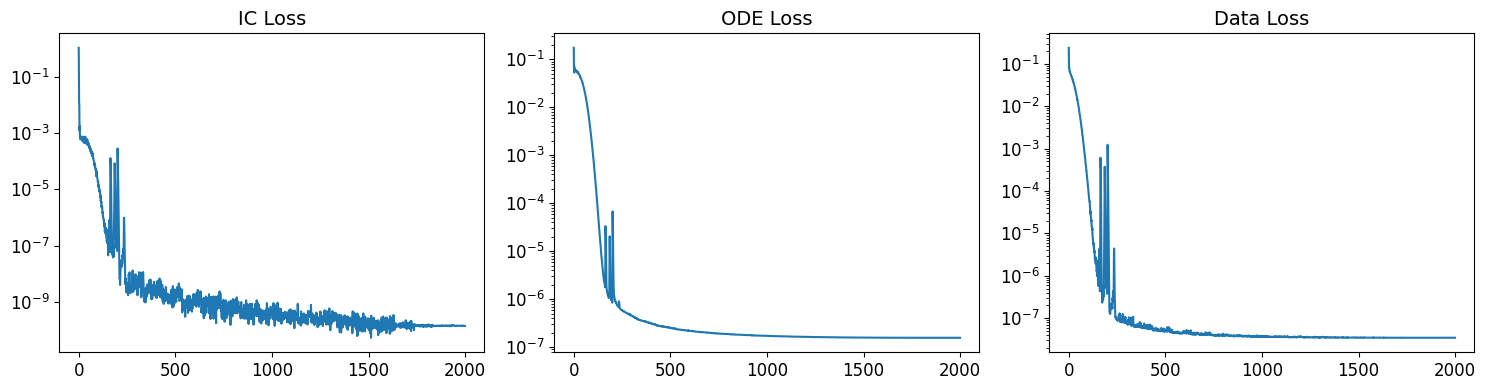

In [13]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'])
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

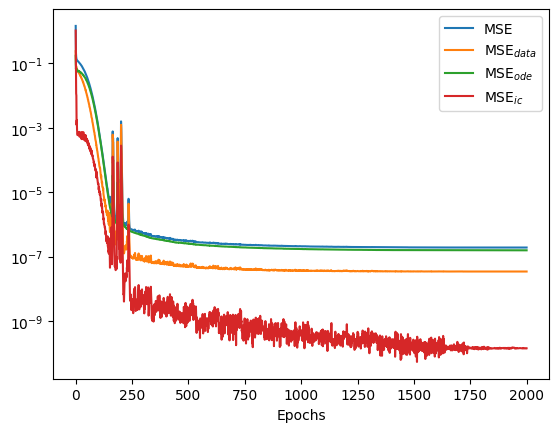

In [14]:
# History
ep = np.arange(n_epochs)
plt.semilogy(ep,loss_tracker.loss_history['total_loss'], label='MSE')
plt.semilogy(ep,loss_tracker.loss_history['Data_loss'], label=r'MSE$_{data}$')
plt.semilogy(ep,loss_tracker.loss_history['ODE_loss'], label=r'MSE$_{ode}$')
plt.semilogy(ep,loss_tracker.loss_history['IC_loss'], label=r'MSE$_{ic}$')
plt.xlabel('Epochs')
plt.legend()

### Plot for evolution of parameters over the epochs and losses

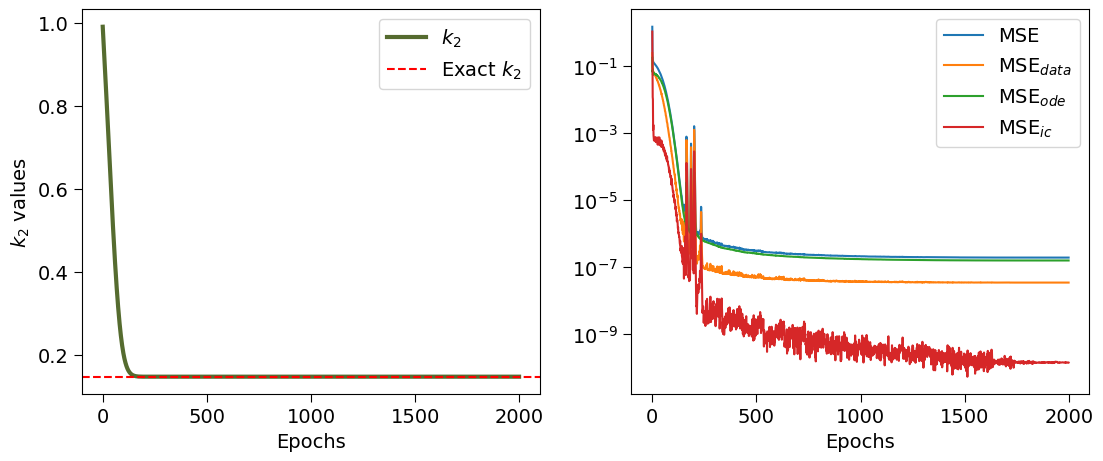

In [31]:
fig, axs = plt.subplots(1,2, figsize=(13,5))

color = 'darkolivegreen'
axs[0].set_xlabel('Epochs', size=14)
axs[0].set_ylabel(r'$k_2$ values', size=14)
axs[0].plot(a_list, color=color, linewidth=3, label=r'$k_2$')
axs[0].axhline(y=4.2*10**(-4)*350, color='red', linestyle='--', label=r'Exact $k_2$')
axs[0].tick_params(axis='y', labelsize=14, length=6)
axs[0].tick_params(axis='x', labelsize=14, length=6)
axs[0].legend(fontsize=14)

ep = np.arange(n_epochs)
#plt.semilogy(ep,loss_tracker.loss_history['Data_loss'] + loss_tracker.loss_history['ODE_loss'], label='loss')
axs[1].semilogy(ep,loss_tracker.loss_history['total_loss'], label='MSE')
axs[1].semilogy(ep,loss_tracker.loss_history['Data_loss'], label=r'MSE$_{data}$')
axs[1].semilogy(ep,loss_tracker.loss_history['ODE_loss'], label=r'MSE$_{ode}$')
axs[1].semilogy(ep,loss_tracker.loss_history['IC_loss'], label=r'MSE$_{ic}$')
axs[1].tick_params(axis='y', labelsize=14, length=6)
axs[1].tick_params(axis='x', labelsize=14, length=6)
axs[1].set_xlabel('Epochs', size=14)
axs[1].legend(fontsize=14)
#plt.savefig('' + 'Param_losses_epochs_systemident' + '.pdf', format="pdf", bbox_inches="tight")

### Parameter evolution over the epochs

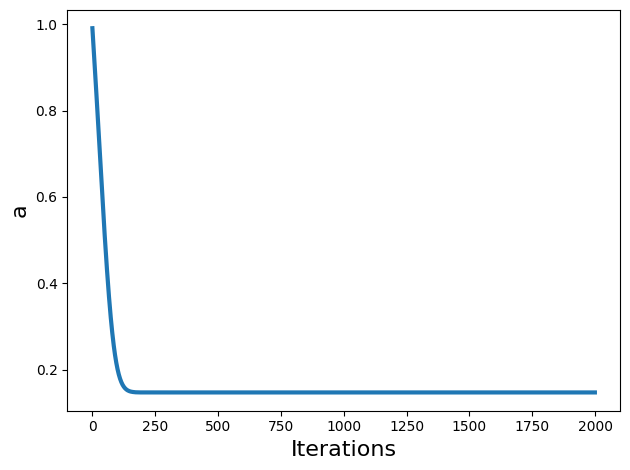

In [16]:
# Parameter history
%matplotlib inline
plt.plot(range(n_epochs), a_list, lw=3)
plt.ylabel('a', fontsize=16)
plt.xlabel('Iterations', fontsize=16)
#plt.set_ylim((-2.2, -0.7))
#plt.axhline(y=-2, color='r', linestyle='--')
plt.tight_layout()

### Save results
Save time, DP, k1, and the function f estimated by PINN to use with symbolic regression to find the mathematical expression

In [17]:
t = np.linspace(0, 10, 100).reshape(-1, 1)
u, f = PINN.predict(t, batch_size=12800)

# Configure dataframe
df = pd.DataFrame({
    't': t.flatten(),
    'u1': u[:, 0],
    'u2': u[:, 1],
    'f1': f[:, 0],
})
#df.to_csv('f_NN_DPk_2.csv', index=False)

1/1 [==============================] - 0s 17ms/step


In [29]:
# Generate testing data
u_init = [1.19, 1.6]
t_span = [0, 10]
u_obs_test1 = simulate_ODEs(u_init, t_span, 100)
X_test1, y_test1 = u_obs_test1[:, :1], u_obs_test1[:, 1:]

In [18]:
t = np.linspace(0, 10, 100).reshape(-1, 1)
pred_u, pred_f = PINN.predict(t, batch_size=12800)

1/1 [==============================] - 0s 16ms/step


### Plot the data and PINN results for DP and k1

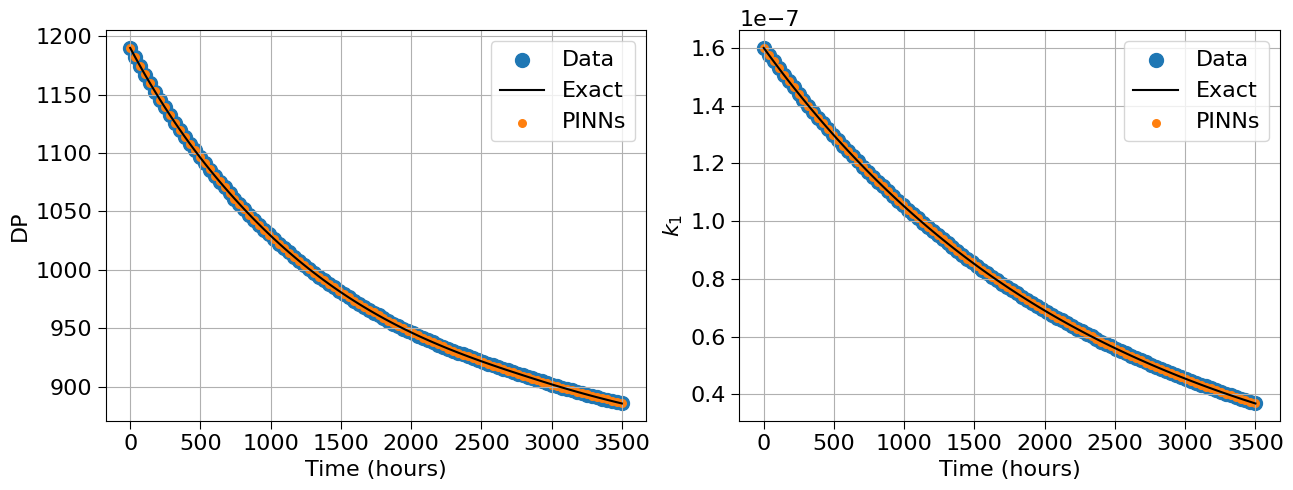

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].scatter(X_test1.flatten()*350, y_test1[:, 0]*1000, label='Data', s=100)
ax[0].plot(X_test1.flatten()*350, y_test1[:, 0]*1000, color='black', label='Exact')
ax[0].scatter(t.flatten()*350, pred_u[:, 0]*1000, label='PINNs', s=30)
#ax[0].plot(t.flatten()*350, pred_u[:, 0]*1000, 'tab:orange', label='PINNs', marker='.', markersize=10, linewidth='2', linestyle='--')
#ax[0].set_title('u1')
ax[1].scatter(X_test1.flatten()*350, y_test1[:, 1]*10**(-7), label='Data', s=100)
ax[1].plot(X_test1.flatten()*350, y_test1[:, 1]*10**(-7), color='black', label='Exact')
ax[1].scatter(t.flatten()*350, pred_u[:, 1]*10**(-7), label='PINNs', s=30)
#ax[1].set_title('u2')
ax[0].set_ylabel('DP', fontsize=16)
ax[1].set_ylabel(r'$k_1$', fontsize=16)

for axs in ax:
    axs.set_xlabel('Time (hours)', fontsize=16)
    axs.tick_params(axis='both', which='major', labelsize=16, length=6)
    axs.legend(fontsize=16, frameon=True)
    axs.grid(True)
    axs.yaxis.offsetText.set_fontsize(16)

plt.tight_layout()
#plt.savefig('' + 'System_ident_DP_k1preds' + '.pdf', format="pdf", bbox_inches="tight")

### Errors

In [ ]:
t = np.linspace(0, 10, 100).reshape(-1, 1)
pred_u, pred_f = PINN.predict(t, batch_size=12800)
error_u = np.linalg.norm(y_test[:,0]-pred_u[:,0],2)/np.linalg.norm(y_test[:,0],2)
print(error_u)
error_k1 = np.linalg.norm(y_test[:,1]-pred_u[:,1],2)/np.linalg.norm(y_test[:,1],2)
print(error_k1)